# TextureMNIST dataset from "Grid Saliency for Context Explanations of Semantic Segmentation".
The dataset includes a bias: digits "2" always coocure with a texture "'f135d029.png" (looks like a carpet with diagonal stripes).
    Seg-Grad-CAM demonstates its ability to detect the bias by highlighting the biased texture. It means that the U-net uses the biased texture to segment "2".

## 1. Imports

In [6]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
from pathlib import Path
import sys

from seggradcam.dataloaders import Cityscapes
#from seggradcam.metrics import IoU, Dice
from seggradcam.unet import csbd_unet, manual_unet, TrainUnet
from seggradcam.training_write import TrainingParameters, TrainingResults
from seggradcam.training_plots import plot_predict_and_gt, plot_loss, plot_metric
from seggradcam.seggradcam import SegGradCAM, SuperRoI, ClassRoI, PixelRoI, BiasRoI
import matplotlib.pyplot as plt
from seggradcam.visualize_sgc import SegGradCAMplot

sys.path.append(os.path.abspath('../gridsaliency-original'))
from mnist_generators_simple import gen_texture_mnist, plot_samples

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define biased & unbiased configs

In [2]:
N_TRAIN = 50000
N_VAL = 10000
BATCH_SIZE = 20
textures_path = Path('..')/'gridsaliency-original'/'textures/'

unbiased_config = {
    'background_split': 2,
    'dataset_seed': 0,
    'tex_res' : 400,
    'tile_size' : 64,
    'train_samples' : N_TRAIN,
    'test_samples' : N_VAL,
    'exclude_bias_textures': False,
    'fix_test_set': True,
    'batch_size': BATCH_SIZE,
    'bias': None,
    'textures_path' : textures_path,
}
biased_config = {
    'background_split': 2,
    'dataset_seed': 0,
    'tex_res' : 400,
    'tile_size' : 64,
    'train_samples' : N_TRAIN,
    'test_samples' : N_VAL,
    'exclude_bias_textures': True,
    'fix_test_set': True,
    'batch_size': BATCH_SIZE,
    'bias': {2 : {
        "source_1_id": "'feeccd96.png", 
        "source_2_id": "'f135d029.png",
        "source_1_bias": 0.0,
        "source_2_bias": 1.0
    }},
    'textures_path' : textures_path,
}

In [3]:
biased_gen_train = gen_texture_mnist(biased_config,'train', return_dict=False)
biased_gen_test = gen_texture_mnist(biased_config,'test', return_dict=False)

## optionally take a look at the generated samples

Biased Test Set


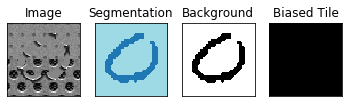

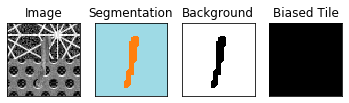

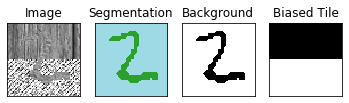

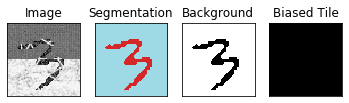

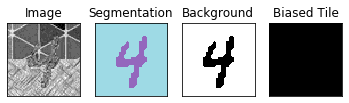

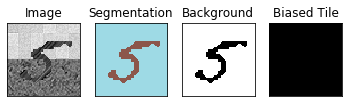

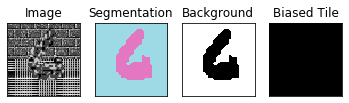

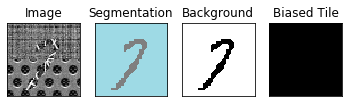

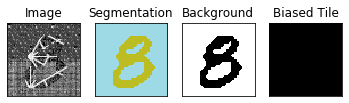

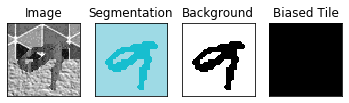

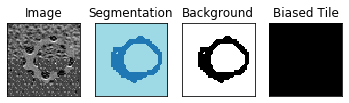

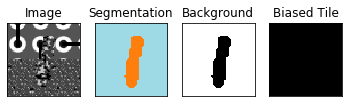

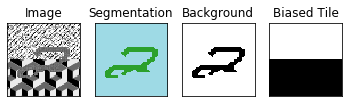

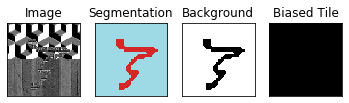

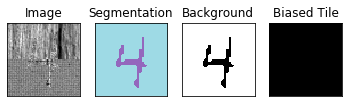

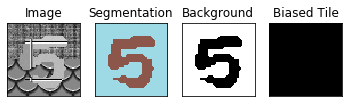

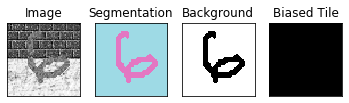

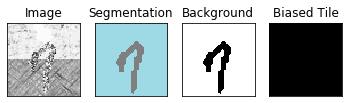

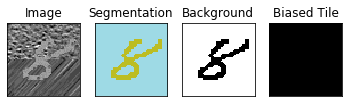

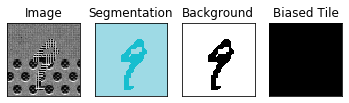

Unbiased Test Set


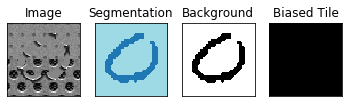

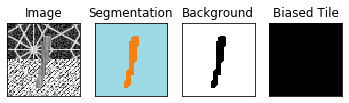

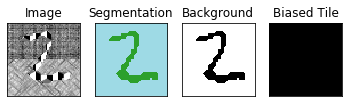

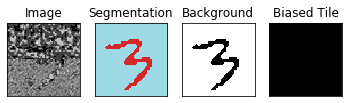

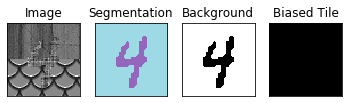

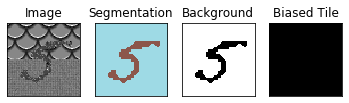

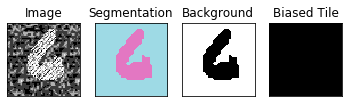

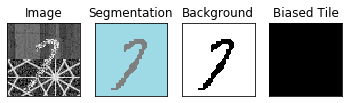

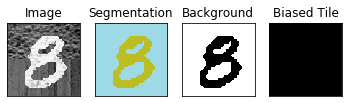

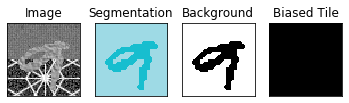

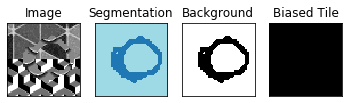

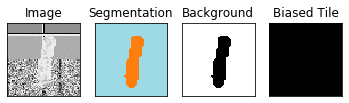

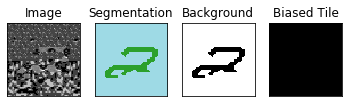

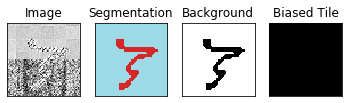

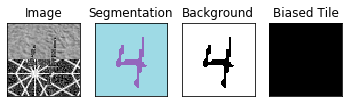

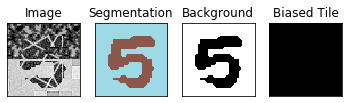

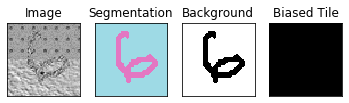

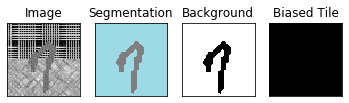

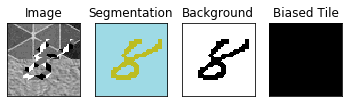

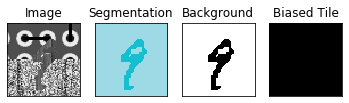

In [12]:
print('Biased Test Set')
biased_generator = gen_texture_mnist(biased_config,'test', return_dict=True)
plot_samples(biased_generator, 20)

print('Unbiased Test Set')
unbiased_generator = gen_texture_mnist(unbiased_config,'test', return_dict=True)
plot_samples(unbiased_generator, 20)

# 2. Option A: train a unet yourself

In [4]:
trainparam = TrainingParameters(
    dataset_name = 'TexturedMnist',
                 n_classes=11
                ,scale = 1
                ,batch_size = BATCH_SIZE
                ,last_activation = 'softmax'
                ,n_depth = 4
                ,n_filter_base = 32  # 16
                ,pool = 2
                ,lr = 3.e-4
                ,epochs = 2#00 #                        CHANGE THE N OF EPOCHS
                ,validation_steps = int(N_VAL/BATCH_SIZE)
                ,steps_per_epoch = int(N_TRAIN/BATCH_SIZE)
                ,loss = "categorical_crossentropy"
                #,optimizer = Adam(lr=3.e-4)
                ,metrics = ['accuracy','IoU','Dice']
                ,input_shape=(None, None, 1)
                ,n_train= N_TRAIN
                ,n_val = N_VAL
)
trainparam.saveToJson()

# Save configs to a txt in the experiment folder
with open(os.path.join(str(trainparam.outfolder),'bias_configs.txt'), 'w+') as file:
    file.write("Biased config:\n")
    for k in biased_config.items():
        file.write(str(k)+"\n")
    file.write("\nUnbiased config:\n")
    for k in unbiased_config.items():
        file.write(str(k)+"\n")
    file.close()

In [7]:
trainunet = TrainUnet(trainparam)
trainunet.csbdUnet()
fit_out = trainunet.fit_generator(biased_gen_train, biased_gen_test)

trainingResults = TrainingResults(trainparam, fit_out)
trainingResults.modelSummaryTxt()
trainingResults.writeResultsTxt()

Epoch 1/2


 114/2500 [>.............................] - ETA: 6:41:05 - loss: 3.0126 - acc: 0.0304 - IoU: 0.0340 - Dice: 0.065 - ETA: 4:07:33 - loss: 2.9816 - acc: 0.0287 - IoU: 0.0348 - Dice: 0.067 - ETA: 3:18:53 - loss: 2.9701 - acc: 0.0329 - IoU: 0.0355 - Dice: 0.068 - ETA: 2:58:27 - loss: 2.9584 - acc: 0.0398 - IoU: 0.0365 - Dice: 0.070 - ETA: 2:45:34 - loss: 2.9309 - acc: 0.0468 - IoU: 0.0382 - Dice: 0.073 - ETA: 2:37:26 - loss: 2.9192 - acc: 0.0500 - IoU: 0.0389 - Dice: 0.074 - ETA: 2:32:09 - loss: 2.8946 - acc: 0.0562 - IoU: 0.0401 - Dice: 0.076 - ETA: 2:27:57 - loss: 2.8813 - acc: 0.0678 - IoU: 0.0419 - Dice: 0.080 - ETA: 2:24:42 - loss: 2.8511 - acc: 0.0790 - IoU: 0.0435 - Dice: 0.083 - ETA: 2:21:59 - loss: 2.8179 - acc: 0.0905 - IoU: 0.0451 - Dice: 0.085 - ETA: 2:19:18 - loss: 2.7889 - acc: 0.0996 - IoU: 0.0465 - Dice: 0.088 - ETA: 2:16:54 - loss: 2.7627 - acc: 0.1063 - IoU: 0.0477 - Dice: 0.090 - ETA: 2:15:16 - loss: 2.7329 - acc: 0.1142 - IoU: 0.0490 - Dice: 0.093 - ETA: 2:14:04 - loss

 228/2500 [=>............................] - ETA: 1:35:52 - loss: 1.6993 - acc: 0.5890 - IoU: 0.1448 - Dice: 0.249 - ETA: 1:35:33 - loss: 1.6961 - acc: 0.5908 - IoU: 0.1454 - Dice: 0.250 - ETA: 1:35:14 - loss: 1.6923 - acc: 0.5925 - IoU: 0.1461 - Dice: 0.251 - ETA: 1:34:55 - loss: 1.6889 - acc: 0.5940 - IoU: 0.1467 - Dice: 0.251 - ETA: 1:34:35 - loss: 1.6856 - acc: 0.5952 - IoU: 0.1473 - Dice: 0.252 - ETA: 1:34:16 - loss: 1.6822 - acc: 0.5966 - IoU: 0.1479 - Dice: 0.253 - ETA: 1:33:57 - loss: 1.6787 - acc: 0.5981 - IoU: 0.1485 - Dice: 0.254 - ETA: 1:33:39 - loss: 1.6753 - acc: 0.5997 - IoU: 0.1491 - Dice: 0.255 - ETA: 1:33:20 - loss: 1.6721 - acc: 0.6010 - IoU: 0.1497 - Dice: 0.256 - ETA: 1:33:02 - loss: 1.6685 - acc: 0.6025 - IoU: 0.1503 - Dice: 0.257 - ETA: 1:32:44 - loss: 1.6651 - acc: 0.6039 - IoU: 0.1510 - Dice: 0.258 - ETA: 1:32:26 - loss: 1.6619 - acc: 0.6052 - IoU: 0.1515 - Dice: 0.259 - ETA: 1:32:09 - loss: 1.6587 - acc: 0.6064 - IoU: 0.1521 - Dice: 0.259 - ETA: 1:31:52 - loss

 342/2500 [===>..........................] - ETA: 1:15:28 - loss: 1.3852 - acc: 0.7140 - IoU: 0.2102 - Dice: 0.339 - ETA: 1:15:22 - loss: 1.3831 - acc: 0.7146 - IoU: 0.2107 - Dice: 0.340 - ETA: 1:15:17 - loss: 1.3810 - acc: 0.7153 - IoU: 0.2113 - Dice: 0.341 - ETA: 1:15:11 - loss: 1.3787 - acc: 0.7160 - IoU: 0.2119 - Dice: 0.341 - ETA: 1:15:05 - loss: 1.3765 - acc: 0.7167 - IoU: 0.2125 - Dice: 0.342 - ETA: 1:14:59 - loss: 1.3742 - acc: 0.7174 - IoU: 0.2131 - Dice: 0.343 - ETA: 1:14:54 - loss: 1.3720 - acc: 0.7181 - IoU: 0.2136 - Dice: 0.344 - ETA: 1:14:48 - loss: 1.3700 - acc: 0.7187 - IoU: 0.2142 - Dice: 0.344 - ETA: 1:14:43 - loss: 1.3680 - acc: 0.7193 - IoU: 0.2148 - Dice: 0.345 - ETA: 1:14:38 - loss: 1.3660 - acc: 0.7199 - IoU: 0.2153 - Dice: 0.346 - ETA: 1:14:32 - loss: 1.3640 - acc: 0.7205 - IoU: 0.2158 - Dice: 0.346 - ETA: 1:14:26 - loss: 1.3620 - acc: 0.7211 - IoU: 0.2164 - Dice: 0.347 - ETA: 1:14:22 - loss: 1.3599 - acc: 0.7216 - IoU: 0.2169 - Dice: 0.348 - ETA: 1:14:16 - loss

 456/2500 [====>.........................] - ETA: 1:06:21 - loss: 1.1812 - acc: 0.7661 - IoU: 0.2743 - Dice: 0.417 - ETA: 1:06:18 - loss: 1.1799 - acc: 0.7663 - IoU: 0.2748 - Dice: 0.417 - ETA: 1:06:14 - loss: 1.1785 - acc: 0.7666 - IoU: 0.2754 - Dice: 0.418 - ETA: 1:06:10 - loss: 1.1770 - acc: 0.7669 - IoU: 0.2759 - Dice: 0.419 - ETA: 1:06:06 - loss: 1.1757 - acc: 0.7671 - IoU: 0.2764 - Dice: 0.419 - ETA: 1:06:03 - loss: 1.1742 - acc: 0.7674 - IoU: 0.2770 - Dice: 0.420 - ETA: 1:05:59 - loss: 1.1726 - acc: 0.7678 - IoU: 0.2776 - Dice: 0.420 - ETA: 1:05:55 - loss: 1.1712 - acc: 0.7680 - IoU: 0.2782 - Dice: 0.421 - ETA: 1:05:52 - loss: 1.1698 - acc: 0.7683 - IoU: 0.2787 - Dice: 0.422 - ETA: 1:05:48 - loss: 1.1684 - acc: 0.7686 - IoU: 0.2792 - Dice: 0.422 - ETA: 1:05:44 - loss: 1.1671 - acc: 0.7688 - IoU: 0.2797 - Dice: 0.423 - ETA: 1:05:40 - loss: 1.1656 - acc: 0.7692 - IoU: 0.2803 - Dice: 0.424 - ETA: 1:05:37 - loss: 1.1642 - acc: 0.7694 - IoU: 0.2809 - Dice: 0.424 - ETA: 1:05:33 - loss

 573/2500 [=====>........................] - ETA: 1:00:19 - loss: 1.0403 - acc: 0.7924 - IoU: 0.3335 - Dice: 0.481 - ETA: 1:00:17 - loss: 1.0392 - acc: 0.7926 - IoU: 0.3340 - Dice: 0.482 - ETA: 1:00:14 - loss: 1.0382 - acc: 0.7928 - IoU: 0.3345 - Dice: 0.482 - ETA: 1:00:11 - loss: 1.0374 - acc: 0.7929 - IoU: 0.3349 - Dice: 0.483 - ETA: 1:00:09 - loss: 1.0364 - acc: 0.7931 - IoU: 0.3353 - Dice: 0.483 - ETA: 1:00:06 - loss: 1.0353 - acc: 0.7933 - IoU: 0.3358 - Dice: 0.484 - ETA: 1:00:03 - loss: 1.0343 - acc: 0.7935 - IoU: 0.3363 - Dice: 0.484 - ETA: 1:00:01 - loss: 1.0333 - acc: 0.7936 - IoU: 0.3368 - Dice: 0.485 - ETA: 59:58 - loss: 1.0324 - acc: 0.7938 - IoU: 0.3372 - Dice: 0.4855  - ETA: 59:56 - loss: 1.0314 - acc: 0.7940 - IoU: 0.3377 - Dice: 0.486 - ETA: 59:53 - loss: 1.0304 - acc: 0.7941 - IoU: 0.3382 - Dice: 0.486 - ETA: 59:50 - loss: 1.0294 - acc: 0.7943 - IoU: 0.3386 - Dice: 0.486 - ETA: 59:47 - loss: 1.0284 - acc: 0.7945 - IoU: 0.3391 - Dice: 0.487 - ETA: 59:45 - loss: 1.0274 -

 690/2500 [=======>......................] - ETA: 55:39 - loss: 0.9393 - acc: 0.8089 - IoU: 0.3837 - Dice: 0.532 - ETA: 55:37 - loss: 0.9387 - acc: 0.8090 - IoU: 0.3841 - Dice: 0.533 - ETA: 55:35 - loss: 0.9379 - acc: 0.8091 - IoU: 0.3845 - Dice: 0.533 - ETA: 55:32 - loss: 0.9372 - acc: 0.8092 - IoU: 0.3849 - Dice: 0.533 - ETA: 55:30 - loss: 0.9364 - acc: 0.8093 - IoU: 0.3853 - Dice: 0.534 - ETA: 55:28 - loss: 0.9357 - acc: 0.8094 - IoU: 0.3856 - Dice: 0.534 - ETA: 55:25 - loss: 0.9349 - acc: 0.8096 - IoU: 0.3860 - Dice: 0.535 - ETA: 55:23 - loss: 0.9342 - acc: 0.8097 - IoU: 0.3864 - Dice: 0.535 - ETA: 55:21 - loss: 0.9336 - acc: 0.8097 - IoU: 0.3868 - Dice: 0.535 - ETA: 55:18 - loss: 0.9328 - acc: 0.8099 - IoU: 0.3872 - Dice: 0.536 - ETA: 55:16 - loss: 0.9321 - acc: 0.8100 - IoU: 0.3876 - Dice: 0.536 - ETA: 55:14 - loss: 0.9314 - acc: 0.8101 - IoU: 0.3880 - Dice: 0.536 - ETA: 55:11 - loss: 0.9306 - acc: 0.8102 - IoU: 0.3884 - Dice: 0.537 - ETA: 55:09 - loss: 0.9298 - acc: 0.8103 - IoU

 807/2500 [========>.....................] - ETA: 51:21 - loss: 0.8625 - acc: 0.8203 - IoU: 0.4252 - Dice: 0.572 - ETA: 51:19 - loss: 0.8619 - acc: 0.8204 - IoU: 0.4255 - Dice: 0.573 - ETA: 51:17 - loss: 0.8614 - acc: 0.8205 - IoU: 0.4258 - Dice: 0.573 - ETA: 51:14 - loss: 0.8609 - acc: 0.8205 - IoU: 0.4261 - Dice: 0.573 - ETA: 51:12 - loss: 0.8603 - acc: 0.8206 - IoU: 0.4264 - Dice: 0.574 - ETA: 51:10 - loss: 0.8598 - acc: 0.8207 - IoU: 0.4267 - Dice: 0.574 - ETA: 51:08 - loss: 0.8592 - acc: 0.8208 - IoU: 0.4270 - Dice: 0.574 - ETA: 51:06 - loss: 0.8586 - acc: 0.8209 - IoU: 0.4273 - Dice: 0.575 - ETA: 51:04 - loss: 0.8580 - acc: 0.8210 - IoU: 0.4277 - Dice: 0.575 - ETA: 51:02 - loss: 0.8574 - acc: 0.8211 - IoU: 0.4280 - Dice: 0.575 - ETA: 51:00 - loss: 0.8569 - acc: 0.8211 - IoU: 0.4283 - Dice: 0.575 - ETA: 50:57 - loss: 0.8563 - acc: 0.8212 - IoU: 0.4286 - Dice: 0.576 - ETA: 50:55 - loss: 0.8557 - acc: 0.8213 - IoU: 0.4289 - Dice: 0.576 - ETA: 50:53 - loss: 0.8551 - acc: 0.8214 - IoU

 924/2500 [==========>...................] - ETA: 47:25 - loss: 0.8008 - acc: 0.8292 - IoU: 0.4591 - Dice: 0.604 - ETA: 47:23 - loss: 0.8003 - acc: 0.8293 - IoU: 0.4594 - Dice: 0.605 - ETA: 47:21 - loss: 0.7998 - acc: 0.8294 - IoU: 0.4597 - Dice: 0.605 - ETA: 47:19 - loss: 0.7992 - acc: 0.8295 - IoU: 0.4599 - Dice: 0.605 - ETA: 47:17 - loss: 0.7988 - acc: 0.8295 - IoU: 0.4602 - Dice: 0.605 - ETA: 47:15 - loss: 0.7983 - acc: 0.8296 - IoU: 0.4605 - Dice: 0.606 - ETA: 47:14 - loss: 0.7978 - acc: 0.8297 - IoU: 0.4607 - Dice: 0.606 - ETA: 47:12 - loss: 0.7973 - acc: 0.8297 - IoU: 0.4610 - Dice: 0.606 - ETA: 47:10 - loss: 0.7970 - acc: 0.8298 - IoU: 0.4612 - Dice: 0.606 - ETA: 47:08 - loss: 0.7966 - acc: 0.8298 - IoU: 0.4615 - Dice: 0.607 - ETA: 47:06 - loss: 0.7961 - acc: 0.8299 - IoU: 0.4618 - Dice: 0.607 - ETA: 47:05 - loss: 0.7956 - acc: 0.8300 - IoU: 0.4620 - Dice: 0.607 - ETA: 47:03 - loss: 0.7951 - acc: 0.8301 - IoU: 0.4623 - Dice: 0.607 - ETA: 47:01 - loss: 0.7947 - acc: 0.8301 - IoU

1041/2500 [===========>..................] - ETA: 43:41 - loss: 0.7512 - acc: 0.8362 - IoU: 0.4870 - Dice: 0.630 - ETA: 43:39 - loss: 0.7508 - acc: 0.8362 - IoU: 0.4872 - Dice: 0.630 - ETA: 43:37 - loss: 0.7503 - acc: 0.8363 - IoU: 0.4875 - Dice: 0.630 - ETA: 43:35 - loss: 0.7500 - acc: 0.8364 - IoU: 0.4877 - Dice: 0.631 - ETA: 43:33 - loss: 0.7496 - acc: 0.8364 - IoU: 0.4879 - Dice: 0.631 - ETA: 43:31 - loss: 0.7492 - acc: 0.8365 - IoU: 0.4881 - Dice: 0.631 - ETA: 43:29 - loss: 0.7488 - acc: 0.8365 - IoU: 0.4883 - Dice: 0.631 - ETA: 43:27 - loss: 0.7485 - acc: 0.8366 - IoU: 0.4885 - Dice: 0.631 - ETA: 43:25 - loss: 0.7481 - acc: 0.8366 - IoU: 0.4888 - Dice: 0.632 - ETA: 43:23 - loss: 0.7477 - acc: 0.8367 - IoU: 0.4890 - Dice: 0.632 - ETA: 43:21 - loss: 0.7474 - acc: 0.8367 - IoU: 0.4892 - Dice: 0.632 - ETA: 43:20 - loss: 0.7470 - acc: 0.8368 - IoU: 0.4894 - Dice: 0.632 - ETA: 43:18 - loss: 0.7467 - acc: 0.8368 - IoU: 0.4896 - Dice: 0.632 - ETA: 43:16 - loss: 0.7463 - acc: 0.8369 - IoU

1158/2500 [============>.................] - ETA: 40:03 - loss: 0.7079 - acc: 0.8427 - IoU: 0.5109 - Dice: 0.652 - ETA: 40:01 - loss: 0.7076 - acc: 0.8427 - IoU: 0.5111 - Dice: 0.652 - ETA: 40:00 - loss: 0.7071 - acc: 0.8428 - IoU: 0.5113 - Dice: 0.652 - ETA: 39:58 - loss: 0.7069 - acc: 0.8428 - IoU: 0.5115 - Dice: 0.652 - ETA: 39:56 - loss: 0.7065 - acc: 0.8429 - IoU: 0.5117 - Dice: 0.652 - ETA: 39:54 - loss: 0.7061 - acc: 0.8430 - IoU: 0.5119 - Dice: 0.652 - ETA: 39:52 - loss: 0.7058 - acc: 0.8430 - IoU: 0.5121 - Dice: 0.653 - ETA: 39:51 - loss: 0.7055 - acc: 0.8431 - IoU: 0.5123 - Dice: 0.653 - ETA: 39:49 - loss: 0.7051 - acc: 0.8431 - IoU: 0.5125 - Dice: 0.653 - ETA: 39:47 - loss: 0.7047 - acc: 0.8432 - IoU: 0.5127 - Dice: 0.653 - ETA: 39:45 - loss: 0.7043 - acc: 0.8433 - IoU: 0.5129 - Dice: 0.653 - ETA: 39:44 - loss: 0.7039 - acc: 0.8433 - IoU: 0.5131 - Dice: 0.653 - ETA: 39:42 - loss: 0.7036 - acc: 0.8434 - IoU: 0.5133 - Dice: 0.654 - ETA: 39:40 - loss: 0.7033 - acc: 0.8434 - IoU

1275/2500 [==============>...............] - ETA: 36:41 - loss: 0.6674 - acc: 0.8494 - IoU: 0.5332 - Dice: 0.671 - ETA: 36:40 - loss: 0.6670 - acc: 0.8494 - IoU: 0.5334 - Dice: 0.671 - ETA: 36:38 - loss: 0.6667 - acc: 0.8495 - IoU: 0.5335 - Dice: 0.671 - ETA: 36:36 - loss: 0.6664 - acc: 0.8495 - IoU: 0.5337 - Dice: 0.671 - ETA: 36:34 - loss: 0.6661 - acc: 0.8496 - IoU: 0.5339 - Dice: 0.671 - ETA: 36:33 - loss: 0.6657 - acc: 0.8496 - IoU: 0.5341 - Dice: 0.672 - ETA: 36:31 - loss: 0.6654 - acc: 0.8497 - IoU: 0.5343 - Dice: 0.672 - ETA: 36:29 - loss: 0.6650 - acc: 0.8498 - IoU: 0.5345 - Dice: 0.672 - ETA: 36:27 - loss: 0.6647 - acc: 0.8498 - IoU: 0.5347 - Dice: 0.672 - ETA: 36:26 - loss: 0.6643 - acc: 0.8499 - IoU: 0.5348 - Dice: 0.672 - ETA: 36:24 - loss: 0.6640 - acc: 0.8499 - IoU: 0.5350 - Dice: 0.672 - ETA: 36:22 - loss: 0.6638 - acc: 0.8500 - IoU: 0.5352 - Dice: 0.673 - ETA: 36:20 - loss: 0.6635 - acc: 0.8500 - IoU: 0.5353 - Dice: 0.673 - ETA: 36:19 - loss: 0.6631 - acc: 0.8501 - IoU

1392/2500 [===============>..............] - ETA: 33:22 - loss: 0.6307 - acc: 0.8557 - IoU: 0.5538 - Dice: 0.688 - ETA: 33:20 - loss: 0.6304 - acc: 0.8557 - IoU: 0.5539 - Dice: 0.688 - ETA: 33:18 - loss: 0.6301 - acc: 0.8558 - IoU: 0.5541 - Dice: 0.688 - ETA: 33:17 - loss: 0.6298 - acc: 0.8559 - IoU: 0.5543 - Dice: 0.689 - ETA: 33:15 - loss: 0.6295 - acc: 0.8559 - IoU: 0.5545 - Dice: 0.689 - ETA: 33:13 - loss: 0.6292 - acc: 0.8560 - IoU: 0.5546 - Dice: 0.689 - ETA: 33:12 - loss: 0.6290 - acc: 0.8560 - IoU: 0.5548 - Dice: 0.689 - ETA: 33:10 - loss: 0.6286 - acc: 0.8561 - IoU: 0.5550 - Dice: 0.689 - ETA: 33:08 - loss: 0.6283 - acc: 0.8561 - IoU: 0.5551 - Dice: 0.689 - ETA: 33:06 - loss: 0.6281 - acc: 0.8562 - IoU: 0.5553 - Dice: 0.689 - ETA: 33:05 - loss: 0.6278 - acc: 0.8562 - IoU: 0.5554 - Dice: 0.690 - ETA: 33:03 - loss: 0.6275 - acc: 0.8563 - IoU: 0.5556 - Dice: 0.690 - ETA: 33:01 - loss: 0.6272 - acc: 0.8563 - IoU: 0.5558 - Dice: 0.690 - ETA: 33:00 - loss: 0.6268 - acc: 0.8564 - IoU

1509/2500 [=================>............] - ETA: 30:03 - loss: 0.5969 - acc: 0.8618 - IoU: 0.5732 - Dice: 0.704 - ETA: 30:01 - loss: 0.5966 - acc: 0.8619 - IoU: 0.5734 - Dice: 0.704 - ETA: 30:00 - loss: 0.5963 - acc: 0.8619 - IoU: 0.5736 - Dice: 0.704 - ETA: 29:58 - loss: 0.5960 - acc: 0.8620 - IoU: 0.5737 - Dice: 0.704 - ETA: 29:56 - loss: 0.5958 - acc: 0.8620 - IoU: 0.5739 - Dice: 0.705 - ETA: 29:55 - loss: 0.5955 - acc: 0.8620 - IoU: 0.5740 - Dice: 0.705 - ETA: 29:53 - loss: 0.5953 - acc: 0.8621 - IoU: 0.5742 - Dice: 0.705 - ETA: 29:52 - loss: 0.5950 - acc: 0.8621 - IoU: 0.5743 - Dice: 0.705 - ETA: 29:50 - loss: 0.5948 - acc: 0.8622 - IoU: 0.5745 - Dice: 0.705 - ETA: 29:48 - loss: 0.5946 - acc: 0.8622 - IoU: 0.5746 - Dice: 0.705 - ETA: 29:47 - loss: 0.5943 - acc: 0.8622 - IoU: 0.5747 - Dice: 0.705 - ETA: 29:45 - loss: 0.5940 - acc: 0.8623 - IoU: 0.5749 - Dice: 0.705 - ETA: 29:44 - loss: 0.5937 - acc: 0.8624 - IoU: 0.5751 - Dice: 0.706 - ETA: 29:42 - loss: 0.5934 - acc: 0.8625 - IoU

1626/2500 [==================>...........] - ETA: 26:48 - loss: 0.5668 - acc: 0.8673 - IoU: 0.5910 - Dice: 0.718 - ETA: 26:46 - loss: 0.5665 - acc: 0.8674 - IoU: 0.5912 - Dice: 0.718 - ETA: 26:45 - loss: 0.5663 - acc: 0.8674 - IoU: 0.5913 - Dice: 0.719 - ETA: 26:43 - loss: 0.5660 - acc: 0.8675 - IoU: 0.5915 - Dice: 0.719 - ETA: 26:41 - loss: 0.5658 - acc: 0.8675 - IoU: 0.5916 - Dice: 0.719 - ETA: 26:40 - loss: 0.5655 - acc: 0.8676 - IoU: 0.5918 - Dice: 0.719 - ETA: 26:38 - loss: 0.5652 - acc: 0.8676 - IoU: 0.5920 - Dice: 0.719 - ETA: 26:36 - loss: 0.5650 - acc: 0.8677 - IoU: 0.5921 - Dice: 0.719 - ETA: 26:35 - loss: 0.5648 - acc: 0.8677 - IoU: 0.5922 - Dice: 0.719 - ETA: 26:33 - loss: 0.5645 - acc: 0.8678 - IoU: 0.5924 - Dice: 0.719 - ETA: 26:31 - loss: 0.5643 - acc: 0.8678 - IoU: 0.5925 - Dice: 0.720 - ETA: 26:30 - loss: 0.5640 - acc: 0.8679 - IoU: 0.5927 - Dice: 0.720 - ETA: 26:28 - loss: 0.5637 - acc: 0.8679 - IoU: 0.5929 - Dice: 0.720 - ETA: 26:26 - loss: 0.5635 - acc: 0.8679 - IoU

1743/2500 [===================>..........] - ETA: 23:33 - loss: 0.5398 - acc: 0.8724 - IoU: 0.6073 - Dice: 0.731 - ETA: 23:32 - loss: 0.5396 - acc: 0.8724 - IoU: 0.6074 - Dice: 0.731 - ETA: 23:30 - loss: 0.5394 - acc: 0.8724 - IoU: 0.6076 - Dice: 0.731 - ETA: 23:28 - loss: 0.5392 - acc: 0.8725 - IoU: 0.6077 - Dice: 0.732 - ETA: 23:27 - loss: 0.5389 - acc: 0.8725 - IoU: 0.6079 - Dice: 0.732 - ETA: 23:25 - loss: 0.5387 - acc: 0.8726 - IoU: 0.6080 - Dice: 0.732 - ETA: 23:23 - loss: 0.5385 - acc: 0.8726 - IoU: 0.6081 - Dice: 0.732 - ETA: 23:22 - loss: 0.5383 - acc: 0.8727 - IoU: 0.6083 - Dice: 0.732 - ETA: 23:20 - loss: 0.5380 - acc: 0.8727 - IoU: 0.6084 - Dice: 0.732 - ETA: 23:19 - loss: 0.5378 - acc: 0.8727 - IoU: 0.6086 - Dice: 0.732 - ETA: 23:17 - loss: 0.5376 - acc: 0.8728 - IoU: 0.6087 - Dice: 0.732 - ETA: 23:15 - loss: 0.5374 - acc: 0.8728 - IoU: 0.6088 - Dice: 0.732 - ETA: 23:14 - loss: 0.5371 - acc: 0.8729 - IoU: 0.6090 - Dice: 0.733 - ETA: 23:12 - loss: 0.5368 - acc: 0.8729 - IoU

1860/2500 [=====================>........] - ETA: 20:22 - loss: 0.5144 - acc: 0.8773 - IoU: 0.6230 - Dice: 0.743 - ETA: 20:20 - loss: 0.5142 - acc: 0.8774 - IoU: 0.6231 - Dice: 0.743 - ETA: 20:18 - loss: 0.5140 - acc: 0.8774 - IoU: 0.6232 - Dice: 0.744 - ETA: 20:17 - loss: 0.5138 - acc: 0.8774 - IoU: 0.6233 - Dice: 0.744 - ETA: 20:15 - loss: 0.5136 - acc: 0.8775 - IoU: 0.6235 - Dice: 0.744 - ETA: 20:14 - loss: 0.5134 - acc: 0.8775 - IoU: 0.6236 - Dice: 0.744 - ETA: 20:12 - loss: 0.5132 - acc: 0.8776 - IoU: 0.6237 - Dice: 0.744 - ETA: 20:10 - loss: 0.5130 - acc: 0.8776 - IoU: 0.6239 - Dice: 0.744 - ETA: 20:09 - loss: 0.5128 - acc: 0.8776 - IoU: 0.6240 - Dice: 0.744 - ETA: 20:07 - loss: 0.5126 - acc: 0.8777 - IoU: 0.6241 - Dice: 0.744 - ETA: 20:05 - loss: 0.5124 - acc: 0.8777 - IoU: 0.6242 - Dice: 0.744 - ETA: 20:04 - loss: 0.5122 - acc: 0.8778 - IoU: 0.6243 - Dice: 0.744 - ETA: 20:02 - loss: 0.5120 - acc: 0.8778 - IoU: 0.6245 - Dice: 0.744 - ETA: 20:00 - loss: 0.5118 - acc: 0.8778 - IoU

1977/2500 [======================>.......] - ETA: 17:10 - loss: 0.4925 - acc: 0.8816 - IoU: 0.6367 - Dice: 0.754 - ETA: 17:08 - loss: 0.4923 - acc: 0.8816 - IoU: 0.6368 - Dice: 0.754 - ETA: 17:06 - loss: 0.4921 - acc: 0.8817 - IoU: 0.6369 - Dice: 0.754 - ETA: 17:05 - loss: 0.4919 - acc: 0.8817 - IoU: 0.6370 - Dice: 0.754 - ETA: 17:03 - loss: 0.4917 - acc: 0.8817 - IoU: 0.6371 - Dice: 0.754 - ETA: 17:02 - loss: 0.4915 - acc: 0.8818 - IoU: 0.6373 - Dice: 0.754 - ETA: 17:00 - loss: 0.4913 - acc: 0.8818 - IoU: 0.6374 - Dice: 0.754 - ETA: 16:58 - loss: 0.4911 - acc: 0.8818 - IoU: 0.6375 - Dice: 0.755 - ETA: 16:57 - loss: 0.4909 - acc: 0.8819 - IoU: 0.6376 - Dice: 0.755 - ETA: 16:55 - loss: 0.4907 - acc: 0.8819 - IoU: 0.6377 - Dice: 0.755 - ETA: 16:53 - loss: 0.4906 - acc: 0.8820 - IoU: 0.6378 - Dice: 0.755 - ETA: 16:52 - loss: 0.4904 - acc: 0.8820 - IoU: 0.6379 - Dice: 0.755 - ETA: 16:50 - loss: 0.4902 - acc: 0.8820 - IoU: 0.6380 - Dice: 0.755 - ETA: 16:48 - loss: 0.4900 - acc: 0.8820 - IoU

2094/2500 [========================>.....] - ETA: 13:59 - loss: 0.4729 - acc: 0.8854 - IoU: 0.6491 - Dice: 0.763 - ETA: 13:57 - loss: 0.4728 - acc: 0.8854 - IoU: 0.6492 - Dice: 0.763 - ETA: 13:55 - loss: 0.4726 - acc: 0.8854 - IoU: 0.6493 - Dice: 0.764 - ETA: 13:54 - loss: 0.4725 - acc: 0.8855 - IoU: 0.6493 - Dice: 0.764 - ETA: 13:52 - loss: 0.4723 - acc: 0.8855 - IoU: 0.6494 - Dice: 0.764 - ETA: 13:51 - loss: 0.4721 - acc: 0.8855 - IoU: 0.6495 - Dice: 0.764 - ETA: 13:49 - loss: 0.4719 - acc: 0.8856 - IoU: 0.6497 - Dice: 0.764 - ETA: 13:47 - loss: 0.4718 - acc: 0.8856 - IoU: 0.6498 - Dice: 0.764 - ETA: 13:46 - loss: 0.4716 - acc: 0.8856 - IoU: 0.6498 - Dice: 0.764 - ETA: 13:44 - loss: 0.4715 - acc: 0.8857 - IoU: 0.6499 - Dice: 0.764 - ETA: 13:42 - loss: 0.4713 - acc: 0.8857 - IoU: 0.6500 - Dice: 0.764 - ETA: 13:41 - loss: 0.4711 - acc: 0.8857 - IoU: 0.6501 - Dice: 0.764 - ETA: 13:39 - loss: 0.4709 - acc: 0.8858 - IoU: 0.6503 - Dice: 0.764 - ETA: 13:38 - loss: 0.4707 - acc: 0.8858 - IoU

2213/2500 [=========================>....] - ETA: 10:50 - loss: 0.4548 - acc: 0.8890 - IoU: 0.6606 - Dice: 0.772 - ETA: 10:48 - loss: 0.4546 - acc: 0.8890 - IoU: 0.6607 - Dice: 0.772 - ETA: 10:47 - loss: 0.4545 - acc: 0.8890 - IoU: 0.6608 - Dice: 0.772 - ETA: 10:45 - loss: 0.4543 - acc: 0.8891 - IoU: 0.6609 - Dice: 0.772 - ETA: 10:43 - loss: 0.4542 - acc: 0.8891 - IoU: 0.6610 - Dice: 0.772 - ETA: 10:42 - loss: 0.4541 - acc: 0.8891 - IoU: 0.6611 - Dice: 0.773 - ETA: 10:40 - loss: 0.4540 - acc: 0.8891 - IoU: 0.6612 - Dice: 0.773 - ETA: 10:38 - loss: 0.4538 - acc: 0.8892 - IoU: 0.6612 - Dice: 0.773 - ETA: 10:37 - loss: 0.4537 - acc: 0.8892 - IoU: 0.6614 - Dice: 0.773 - ETA: 10:35 - loss: 0.4535 - acc: 0.8892 - IoU: 0.6615 - Dice: 0.773 - ETA: 10:34 - loss: 0.4534 - acc: 0.8892 - IoU: 0.6615 - Dice: 0.773 - ETA: 10:32 - loss: 0.4532 - acc: 0.8893 - IoU: 0.6616 - Dice: 0.773 - ETA: 10:30 - loss: 0.4531 - acc: 0.8893 - IoU: 0.6617 - Dice: 0.773 - ETA: 10:29 - loss: 0.4529 - acc: 0.8893 - IoU

2333/2500 [==========================>...] - ETA: 7:38 - loss: 0.4378 - acc: 0.8924 - IoU: 0.6715 - Dice: 0.78 - ETA: 7:36 - loss: 0.4377 - acc: 0.8924 - IoU: 0.6716 - Dice: 0.78 - ETA: 7:35 - loss: 0.4376 - acc: 0.8924 - IoU: 0.6717 - Dice: 0.78 - ETA: 7:33 - loss: 0.4374 - acc: 0.8924 - IoU: 0.6718 - Dice: 0.78 - ETA: 7:31 - loss: 0.4373 - acc: 0.8925 - IoU: 0.6718 - Dice: 0.78 - ETA: 7:30 - loss: 0.4372 - acc: 0.8925 - IoU: 0.6719 - Dice: 0.78 - ETA: 7:28 - loss: 0.4370 - acc: 0.8925 - IoU: 0.6720 - Dice: 0.78 - ETA: 7:27 - loss: 0.4369 - acc: 0.8925 - IoU: 0.6721 - Dice: 0.78 - ETA: 7:25 - loss: 0.4367 - acc: 0.8926 - IoU: 0.6722 - Dice: 0.78 - ETA: 7:23 - loss: 0.4366 - acc: 0.8926 - IoU: 0.6723 - Dice: 0.78 - ETA: 7:22 - loss: 0.4365 - acc: 0.8926 - IoU: 0.6723 - Dice: 0.78 - ETA: 7:20 - loss: 0.4364 - acc: 0.8926 - IoU: 0.6724 - Dice: 0.78 - ETA: 7:19 - loss: 0.4363 - acc: 0.8927 - IoU: 0.6725 - Dice: 0.78 - ETA: 7:17 - loss: 0.4361 - acc: 0.8927 - IoU: 0.6726 - Dice: 0.78 - ETA

2453/2500 [============================>.] - ETA: 4:25 - loss: 0.4224 - acc: 0.8955 - IoU: 0.6815 - Dice: 0.78 - ETA: 4:24 - loss: 0.4223 - acc: 0.8955 - IoU: 0.6815 - Dice: 0.78 - ETA: 4:22 - loss: 0.4222 - acc: 0.8955 - IoU: 0.6816 - Dice: 0.78 - ETA: 4:20 - loss: 0.4220 - acc: 0.8955 - IoU: 0.6817 - Dice: 0.78 - ETA: 4:19 - loss: 0.4219 - acc: 0.8956 - IoU: 0.6818 - Dice: 0.78 - ETA: 4:17 - loss: 0.4218 - acc: 0.8956 - IoU: 0.6819 - Dice: 0.78 - ETA: 4:16 - loss: 0.4217 - acc: 0.8956 - IoU: 0.6819 - Dice: 0.78 - ETA: 4:14 - loss: 0.4215 - acc: 0.8956 - IoU: 0.6820 - Dice: 0.78 - ETA: 4:12 - loss: 0.4214 - acc: 0.8956 - IoU: 0.6821 - Dice: 0.78 - ETA: 4:11 - loss: 0.4213 - acc: 0.8957 - IoU: 0.6822 - Dice: 0.78 - ETA: 4:09 - loss: 0.4212 - acc: 0.8957 - IoU: 0.6823 - Dice: 0.78 - ETA: 4:08 - loss: 0.4211 - acc: 0.8957 - IoU: 0.6823 - Dice: 0.78 - ETA: 4:06 - loss: 0.4210 - acc: 0.8957 - IoU: 0.6824 - Dice: 0.78 - ETA: 4:04 - loss: 0.4209 - acc: 0.8958 - IoU: 0.6825 - Dice: 0.78 - ETA

2500/2500 [==============================] - ETA: 1:13 - loss: 0.4084 - acc: 0.8982 - IoU: 0.6905 - Dice: 0.79 - ETA: 1:11 - loss: 0.4083 - acc: 0.8983 - IoU: 0.6906 - Dice: 0.79 - ETA: 1:10 - loss: 0.4081 - acc: 0.8983 - IoU: 0.6907 - Dice: 0.79 - ETA: 1:08 - loss: 0.4080 - acc: 0.8983 - IoU: 0.6907 - Dice: 0.79 - ETA: 1:07 - loss: 0.4079 - acc: 0.8983 - IoU: 0.6908 - Dice: 0.79 - ETA: 1:05 - loss: 0.4078 - acc: 0.8983 - IoU: 0.6909 - Dice: 0.79 - ETA: 1:03 - loss: 0.4077 - acc: 0.8984 - IoU: 0.6909 - Dice: 0.79 - ETA: 1:02 - loss: 0.4076 - acc: 0.8984 - IoU: 0.6910 - Dice: 0.79 - ETA: 1:00 - loss: 0.4075 - acc: 0.8984 - IoU: 0.6911 - Dice: 0.79 - ETA: 59s - loss: 0.4074 - acc: 0.8984 - IoU: 0.6912 - Dice: 0.7956 - ETA: 57s - loss: 0.4072 - acc: 0.8985 - IoU: 0.6912 - Dice: 0.795 - ETA: 55s - loss: 0.4071 - acc: 0.8985 - IoU: 0.6913 - Dice: 0.795 - ETA: 54s - loss: 0.4070 - acc: 0.8985 - IoU: 0.6914 - Dice: 0.795 - ETA: 52s - loss: 0.4069 - acc: 0.8985 - IoU: 0.6915 - Dice: 0.795 - ET

 114/2500 [>.............................] - ETA: 1:04:38 - loss: 0.1222 - acc: 0.9602 - IoU: 0.8765 - Dice: 0.933 - ETA: 1:04:23 - loss: 0.1833 - acc: 0.9443 - IoU: 0.8525 - Dice: 0.918 - ETA: 1:05:47 - loss: 0.1653 - acc: 0.9477 - IoU: 0.8571 - Dice: 0.921 - ETA: 1:06:30 - loss: 0.1538 - acc: 0.9512 - IoU: 0.8622 - Dice: 0.924 - ETA: 1:07:01 - loss: 0.1478 - acc: 0.9515 - IoU: 0.8643 - Dice: 0.925 - ETA: 1:07:16 - loss: 0.1467 - acc: 0.9503 - IoU: 0.8625 - Dice: 0.924 - ETA: 1:07:24 - loss: 0.1473 - acc: 0.9499 - IoU: 0.8621 - Dice: 0.924 - ETA: 1:07:29 - loss: 0.1468 - acc: 0.9500 - IoU: 0.8626 - Dice: 0.924 - ETA: 1:07:31 - loss: 0.1473 - acc: 0.9493 - IoU: 0.8619 - Dice: 0.924 - ETA: 1:07:33 - loss: 0.1428 - acc: 0.9509 - IoU: 0.8645 - Dice: 0.926 - ETA: 1:07:38 - loss: 0.1397 - acc: 0.9520 - IoU: 0.8670 - Dice: 0.927 - ETA: 1:07:56 - loss: 0.1392 - acc: 0.9523 - IoU: 0.8680 - Dice: 0.928 - ETA: 1:08:21 - loss: 0.1360 - acc: 0.9532 - IoU: 0.8703 - Dice: 0.929 - ETA: 1:08:29 - loss

 228/2500 [=>............................] - ETA: 1:03:27 - loss: 0.1263 - acc: 0.9563 - IoU: 0.8757 - Dice: 0.932 - ETA: 1:03:25 - loss: 0.1262 - acc: 0.9564 - IoU: 0.8759 - Dice: 0.932 - ETA: 1:03:23 - loss: 0.1267 - acc: 0.9562 - IoU: 0.8756 - Dice: 0.932 - ETA: 1:03:21 - loss: 0.1266 - acc: 0.9562 - IoU: 0.8757 - Dice: 0.932 - ETA: 1:03:19 - loss: 0.1269 - acc: 0.9562 - IoU: 0.8757 - Dice: 0.932 - ETA: 1:03:17 - loss: 0.1270 - acc: 0.9561 - IoU: 0.8757 - Dice: 0.932 - ETA: 1:03:15 - loss: 0.1277 - acc: 0.9559 - IoU: 0.8754 - Dice: 0.932 - ETA: 1:03:13 - loss: 0.1275 - acc: 0.9560 - IoU: 0.8755 - Dice: 0.932 - ETA: 1:03:11 - loss: 0.1277 - acc: 0.9559 - IoU: 0.8755 - Dice: 0.932 - ETA: 1:03:09 - loss: 0.1278 - acc: 0.9559 - IoU: 0.8755 - Dice: 0.932 - ETA: 1:03:07 - loss: 0.1276 - acc: 0.9559 - IoU: 0.8756 - Dice: 0.932 - ETA: 1:03:04 - loss: 0.1272 - acc: 0.9561 - IoU: 0.8759 - Dice: 0.932 - ETA: 1:03:01 - loss: 0.1268 - acc: 0.9562 - IoU: 0.8761 - Dice: 0.932 - ETA: 1:02:59 - loss

 345/2500 [===>..........................] - ETA: 1:00:04 - loss: 0.1237 - acc: 0.9568 - IoU: 0.8779 - Dice: 0.933 - ETA: 1:00:02 - loss: 0.1243 - acc: 0.9566 - IoU: 0.8776 - Dice: 0.933 - ETA: 1:00:00 - loss: 0.1242 - acc: 0.9566 - IoU: 0.8776 - Dice: 0.933 - ETA: 59:58 - loss: 0.1246 - acc: 0.9565 - IoU: 0.8775 - Dice: 0.9334  - ETA: 59:57 - loss: 0.1246 - acc: 0.9565 - IoU: 0.8774 - Dice: 0.933 - ETA: 59:55 - loss: 0.1246 - acc: 0.9565 - IoU: 0.8774 - Dice: 0.933 - ETA: 59:53 - loss: 0.1246 - acc: 0.9565 - IoU: 0.8774 - Dice: 0.933 - ETA: 59:52 - loss: 0.1247 - acc: 0.9564 - IoU: 0.8774 - Dice: 0.933 - ETA: 59:51 - loss: 0.1246 - acc: 0.9565 - IoU: 0.8775 - Dice: 0.933 - ETA: 59:50 - loss: 0.1245 - acc: 0.9566 - IoU: 0.8775 - Dice: 0.933 - ETA: 59:49 - loss: 0.1245 - acc: 0.9566 - IoU: 0.8775 - Dice: 0.933 - ETA: 59:48 - loss: 0.1246 - acc: 0.9565 - IoU: 0.8774 - Dice: 0.933 - ETA: 59:47 - loss: 0.1245 - acc: 0.9566 - IoU: 0.8775 - Dice: 0.933 - ETA: 59:45 - loss: 0.1243 - acc: 0.95

 462/2500 [====>.........................] - ETA: 57:20 - loss: 0.1259 - acc: 0.9563 - IoU: 0.8776 - Dice: 0.933 - ETA: 57:18 - loss: 0.1260 - acc: 0.9563 - IoU: 0.8775 - Dice: 0.933 - ETA: 57:16 - loss: 0.1261 - acc: 0.9562 - IoU: 0.8774 - Dice: 0.933 - ETA: 57:15 - loss: 0.1261 - acc: 0.9562 - IoU: 0.8774 - Dice: 0.933 - ETA: 57:13 - loss: 0.1262 - acc: 0.9562 - IoU: 0.8773 - Dice: 0.933 - ETA: 57:11 - loss: 0.1261 - acc: 0.9562 - IoU: 0.8774 - Dice: 0.933 - ETA: 57:09 - loss: 0.1260 - acc: 0.9562 - IoU: 0.8774 - Dice: 0.933 - ETA: 57:07 - loss: 0.1259 - acc: 0.9563 - IoU: 0.8775 - Dice: 0.933 - ETA: 57:06 - loss: 0.1257 - acc: 0.9563 - IoU: 0.8776 - Dice: 0.933 - ETA: 57:04 - loss: 0.1259 - acc: 0.9563 - IoU: 0.8775 - Dice: 0.933 - ETA: 57:02 - loss: 0.1259 - acc: 0.9563 - IoU: 0.8775 - Dice: 0.933 - ETA: 57:01 - loss: 0.1258 - acc: 0.9563 - IoU: 0.8776 - Dice: 0.933 - ETA: 56:59 - loss: 0.1257 - acc: 0.9563 - IoU: 0.8777 - Dice: 0.933 - ETA: 56:58 - loss: 0.1255 - acc: 0.9564 - IoU

 579/2500 [=====>........................] - ETA: 54:02 - loss: 0.1217 - acc: 0.9575 - IoU: 0.8804 - Dice: 0.935 - ETA: 54:01 - loss: 0.1216 - acc: 0.9575 - IoU: 0.8804 - Dice: 0.935 - ETA: 53:59 - loss: 0.1215 - acc: 0.9575 - IoU: 0.8805 - Dice: 0.935 - ETA: 53:58 - loss: 0.1214 - acc: 0.9576 - IoU: 0.8806 - Dice: 0.935 - ETA: 53:56 - loss: 0.1215 - acc: 0.9576 - IoU: 0.8806 - Dice: 0.935 - ETA: 53:54 - loss: 0.1214 - acc: 0.9576 - IoU: 0.8806 - Dice: 0.935 - ETA: 53:53 - loss: 0.1214 - acc: 0.9576 - IoU: 0.8806 - Dice: 0.935 - ETA: 53:51 - loss: 0.1214 - acc: 0.9576 - IoU: 0.8806 - Dice: 0.935 - ETA: 53:50 - loss: 0.1215 - acc: 0.9576 - IoU: 0.8806 - Dice: 0.935 - ETA: 53:48 - loss: 0.1215 - acc: 0.9575 - IoU: 0.8805 - Dice: 0.935 - ETA: 53:46 - loss: 0.1216 - acc: 0.9575 - IoU: 0.8805 - Dice: 0.935 - ETA: 53:44 - loss: 0.1216 - acc: 0.9575 - IoU: 0.8805 - Dice: 0.935 - ETA: 53:43 - loss: 0.1215 - acc: 0.9575 - IoU: 0.8806 - Dice: 0.935 - ETA: 53:41 - loss: 0.1215 - acc: 0.9575 - IoU

 696/2500 [=======>......................] - ETA: 50:57 - loss: 0.1219 - acc: 0.9574 - IoU: 0.8806 - Dice: 0.935 - ETA: 50:56 - loss: 0.1219 - acc: 0.9574 - IoU: 0.8806 - Dice: 0.935 - ETA: 50:55 - loss: 0.1218 - acc: 0.9574 - IoU: 0.8806 - Dice: 0.935 - ETA: 50:54 - loss: 0.1217 - acc: 0.9575 - IoU: 0.8807 - Dice: 0.935 - ETA: 50:52 - loss: 0.1216 - acc: 0.9575 - IoU: 0.8808 - Dice: 0.935 - ETA: 50:51 - loss: 0.1216 - acc: 0.9575 - IoU: 0.8808 - Dice: 0.935 - ETA: 50:50 - loss: 0.1215 - acc: 0.9576 - IoU: 0.8809 - Dice: 0.935 - ETA: 50:48 - loss: 0.1215 - acc: 0.9575 - IoU: 0.8809 - Dice: 0.935 - ETA: 50:47 - loss: 0.1216 - acc: 0.9575 - IoU: 0.8808 - Dice: 0.935 - ETA: 50:45 - loss: 0.1216 - acc: 0.9575 - IoU: 0.8809 - Dice: 0.935 - ETA: 50:44 - loss: 0.1216 - acc: 0.9575 - IoU: 0.8808 - Dice: 0.935 - ETA: 50:43 - loss: 0.1215 - acc: 0.9575 - IoU: 0.8809 - Dice: 0.935 - ETA: 50:41 - loss: 0.1215 - acc: 0.9575 - IoU: 0.8809 - Dice: 0.935 - ETA: 50:40 - loss: 0.1215 - acc: 0.9575 - IoU

 813/2500 [========>.....................] - ETA: 47:51 - loss: 0.1204 - acc: 0.9578 - IoU: 0.8819 - Dice: 0.935 - ETA: 47:49 - loss: 0.1204 - acc: 0.9578 - IoU: 0.8818 - Dice: 0.935 - ETA: 47:48 - loss: 0.1203 - acc: 0.9578 - IoU: 0.8819 - Dice: 0.935 - ETA: 47:46 - loss: 0.1203 - acc: 0.9578 - IoU: 0.8819 - Dice: 0.935 - ETA: 47:45 - loss: 0.1202 - acc: 0.9578 - IoU: 0.8819 - Dice: 0.936 - ETA: 47:43 - loss: 0.1202 - acc: 0.9579 - IoU: 0.8820 - Dice: 0.936 - ETA: 47:41 - loss: 0.1201 - acc: 0.9579 - IoU: 0.8820 - Dice: 0.936 - ETA: 47:40 - loss: 0.1201 - acc: 0.9579 - IoU: 0.8820 - Dice: 0.936 - ETA: 47:38 - loss: 0.1200 - acc: 0.9579 - IoU: 0.8821 - Dice: 0.936 - ETA: 47:37 - loss: 0.1200 - acc: 0.9579 - IoU: 0.8821 - Dice: 0.936 - ETA: 47:35 - loss: 0.1199 - acc: 0.9579 - IoU: 0.8821 - Dice: 0.936 - ETA: 47:33 - loss: 0.1199 - acc: 0.9580 - IoU: 0.8822 - Dice: 0.936 - ETA: 47:32 - loss: 0.1198 - acc: 0.9580 - IoU: 0.8822 - Dice: 0.936 - ETA: 47:30 - loss: 0.1197 - acc: 0.9580 - IoU

 930/2500 [==========>...................] - ETA: 44:42 - loss: 0.1171 - acc: 0.9589 - IoU: 0.8845 - Dice: 0.937 - ETA: 44:40 - loss: 0.1171 - acc: 0.9589 - IoU: 0.8845 - Dice: 0.937 - ETA: 44:38 - loss: 0.1171 - acc: 0.9589 - IoU: 0.8845 - Dice: 0.937 - ETA: 44:37 - loss: 0.1170 - acc: 0.9589 - IoU: 0.8846 - Dice: 0.937 - ETA: 44:35 - loss: 0.1170 - acc: 0.9589 - IoU: 0.8846 - Dice: 0.937 - ETA: 44:33 - loss: 0.1170 - acc: 0.9589 - IoU: 0.8846 - Dice: 0.937 - ETA: 44:32 - loss: 0.1170 - acc: 0.9589 - IoU: 0.8846 - Dice: 0.937 - ETA: 44:30 - loss: 0.1169 - acc: 0.9589 - IoU: 0.8846 - Dice: 0.937 - ETA: 44:28 - loss: 0.1169 - acc: 0.9589 - IoU: 0.8847 - Dice: 0.937 - ETA: 44:27 - loss: 0.1168 - acc: 0.9589 - IoU: 0.8847 - Dice: 0.937 - ETA: 44:25 - loss: 0.1168 - acc: 0.9590 - IoU: 0.8847 - Dice: 0.937 - ETA: 44:24 - loss: 0.1168 - acc: 0.9590 - IoU: 0.8847 - Dice: 0.937 - ETA: 44:22 - loss: 0.1168 - acc: 0.9589 - IoU: 0.8847 - Dice: 0.937 - ETA: 44:20 - loss: 0.1168 - acc: 0.9590 - IoU

1047/2500 [===========>..................] - ETA: 41:39 - loss: 0.1159 - acc: 0.9593 - IoU: 0.8857 - Dice: 0.938 - ETA: 41:37 - loss: 0.1158 - acc: 0.9593 - IoU: 0.8858 - Dice: 0.938 - ETA: 41:36 - loss: 0.1158 - acc: 0.9593 - IoU: 0.8858 - Dice: 0.938 - ETA: 41:34 - loss: 0.1158 - acc: 0.9593 - IoU: 0.8858 - Dice: 0.938 - ETA: 41:32 - loss: 0.1158 - acc: 0.9593 - IoU: 0.8858 - Dice: 0.938 - ETA: 41:31 - loss: 0.1157 - acc: 0.9593 - IoU: 0.8858 - Dice: 0.938 - ETA: 41:29 - loss: 0.1157 - acc: 0.9593 - IoU: 0.8859 - Dice: 0.938 - ETA: 41:28 - loss: 0.1157 - acc: 0.9593 - IoU: 0.8859 - Dice: 0.938 - ETA: 41:26 - loss: 0.1158 - acc: 0.9593 - IoU: 0.8858 - Dice: 0.938 - ETA: 41:24 - loss: 0.1159 - acc: 0.9593 - IoU: 0.8858 - Dice: 0.938 - ETA: 41:23 - loss: 0.1159 - acc: 0.9593 - IoU: 0.8858 - Dice: 0.938 - ETA: 41:21 - loss: 0.1159 - acc: 0.9593 - IoU: 0.8858 - Dice: 0.938 - ETA: 41:19 - loss: 0.1159 - acc: 0.9593 - IoU: 0.8858 - Dice: 0.938 - ETA: 41:18 - loss: 0.1159 - acc: 0.9593 - IoU

1164/2500 [============>.................] - ETA: 38:30 - loss: 0.1139 - acc: 0.9599 - IoU: 0.8874 - Dice: 0.939 - ETA: 38:28 - loss: 0.1138 - acc: 0.9599 - IoU: 0.8875 - Dice: 0.939 - ETA: 38:26 - loss: 0.1138 - acc: 0.9599 - IoU: 0.8875 - Dice: 0.939 - ETA: 38:25 - loss: 0.1138 - acc: 0.9599 - IoU: 0.8875 - Dice: 0.939 - ETA: 38:23 - loss: 0.1138 - acc: 0.9599 - IoU: 0.8875 - Dice: 0.939 - ETA: 38:22 - loss: 0.1138 - acc: 0.9599 - IoU: 0.8875 - Dice: 0.939 - ETA: 38:20 - loss: 0.1138 - acc: 0.9599 - IoU: 0.8875 - Dice: 0.939 - ETA: 38:18 - loss: 0.1137 - acc: 0.9599 - IoU: 0.8875 - Dice: 0.939 - ETA: 38:17 - loss: 0.1137 - acc: 0.9600 - IoU: 0.8876 - Dice: 0.939 - ETA: 38:15 - loss: 0.1137 - acc: 0.9600 - IoU: 0.8876 - Dice: 0.939 - ETA: 38:13 - loss: 0.1137 - acc: 0.9600 - IoU: 0.8876 - Dice: 0.939 - ETA: 38:12 - loss: 0.1137 - acc: 0.9599 - IoU: 0.8876 - Dice: 0.939 - ETA: 38:10 - loss: 0.1137 - acc: 0.9600 - IoU: 0.8876 - Dice: 0.939 - ETA: 38:09 - loss: 0.1136 - acc: 0.9600 - IoU

1281/2500 [==============>...............] - ETA: 35:24 - loss: 0.1132 - acc: 0.9601 - IoU: 0.8882 - Dice: 0.939 - ETA: 35:22 - loss: 0.1132 - acc: 0.9601 - IoU: 0.8882 - Dice: 0.939 - ETA: 35:21 - loss: 0.1132 - acc: 0.9601 - IoU: 0.8882 - Dice: 0.939 - ETA: 35:19 - loss: 0.1132 - acc: 0.9601 - IoU: 0.8882 - Dice: 0.939 - ETA: 35:18 - loss: 0.1132 - acc: 0.9601 - IoU: 0.8882 - Dice: 0.939 - ETA: 35:16 - loss: 0.1131 - acc: 0.9601 - IoU: 0.8882 - Dice: 0.939 - ETA: 35:15 - loss: 0.1133 - acc: 0.9601 - IoU: 0.8882 - Dice: 0.939 - ETA: 35:13 - loss: 0.1133 - acc: 0.9601 - IoU: 0.8882 - Dice: 0.939 - ETA: 35:11 - loss: 0.1133 - acc: 0.9601 - IoU: 0.8882 - Dice: 0.939 - ETA: 35:10 - loss: 0.1133 - acc: 0.9601 - IoU: 0.8882 - Dice: 0.939 - ETA: 35:08 - loss: 0.1133 - acc: 0.9601 - IoU: 0.8882 - Dice: 0.939 - ETA: 35:07 - loss: 0.1132 - acc: 0.9601 - IoU: 0.8882 - Dice: 0.939 - ETA: 35:05 - loss: 0.1132 - acc: 0.9601 - IoU: 0.8883 - Dice: 0.939 - ETA: 35:04 - loss: 0.1132 - acc: 0.9601 - IoU

1398/2500 [===============>..............] - ETA: 32:17 - loss: 0.1124 - acc: 0.9604 - IoU: 0.8891 - Dice: 0.940 - ETA: 32:16 - loss: 0.1124 - acc: 0.9604 - IoU: 0.8891 - Dice: 0.940 - ETA: 32:14 - loss: 0.1123 - acc: 0.9604 - IoU: 0.8891 - Dice: 0.940 - ETA: 32:13 - loss: 0.1123 - acc: 0.9604 - IoU: 0.8891 - Dice: 0.940 - ETA: 32:11 - loss: 0.1123 - acc: 0.9604 - IoU: 0.8892 - Dice: 0.940 - ETA: 32:09 - loss: 0.1123 - acc: 0.9604 - IoU: 0.8891 - Dice: 0.940 - ETA: 32:08 - loss: 0.1123 - acc: 0.9604 - IoU: 0.8891 - Dice: 0.940 - ETA: 32:06 - loss: 0.1123 - acc: 0.9604 - IoU: 0.8891 - Dice: 0.940 - ETA: 32:05 - loss: 0.1123 - acc: 0.9604 - IoU: 0.8891 - Dice: 0.940 - ETA: 32:03 - loss: 0.1123 - acc: 0.9604 - IoU: 0.8892 - Dice: 0.940 - ETA: 32:01 - loss: 0.1123 - acc: 0.9604 - IoU: 0.8891 - Dice: 0.940 - ETA: 32:00 - loss: 0.1123 - acc: 0.9604 - IoU: 0.8891 - Dice: 0.940 - ETA: 31:58 - loss: 0.1123 - acc: 0.9604 - IoU: 0.8892 - Dice: 0.940 - ETA: 31:56 - loss: 0.1123 - acc: 0.9604 - IoU

1515/2500 [=================>............] - ETA: 29:11 - loss: 0.1109 - acc: 0.9609 - IoU: 0.8903 - Dice: 0.940 - ETA: 29:09 - loss: 0.1109 - acc: 0.9609 - IoU: 0.8903 - Dice: 0.940 - ETA: 29:08 - loss: 0.1109 - acc: 0.9609 - IoU: 0.8903 - Dice: 0.940 - ETA: 29:06 - loss: 0.1108 - acc: 0.9609 - IoU: 0.8903 - Dice: 0.940 - ETA: 29:05 - loss: 0.1108 - acc: 0.9609 - IoU: 0.8904 - Dice: 0.940 - ETA: 29:03 - loss: 0.1108 - acc: 0.9609 - IoU: 0.8904 - Dice: 0.940 - ETA: 29:01 - loss: 0.1110 - acc: 0.9609 - IoU: 0.8903 - Dice: 0.940 - ETA: 29:00 - loss: 0.1110 - acc: 0.9609 - IoU: 0.8903 - Dice: 0.940 - ETA: 28:58 - loss: 0.1110 - acc: 0.9609 - IoU: 0.8903 - Dice: 0.940 - ETA: 28:57 - loss: 0.1110 - acc: 0.9609 - IoU: 0.8903 - Dice: 0.940 - ETA: 28:55 - loss: 0.1110 - acc: 0.9608 - IoU: 0.8903 - Dice: 0.940 - ETA: 28:53 - loss: 0.1110 - acc: 0.9608 - IoU: 0.8903 - Dice: 0.940 - ETA: 28:52 - loss: 0.1110 - acc: 0.9609 - IoU: 0.8903 - Dice: 0.940 - ETA: 28:50 - loss: 0.1111 - acc: 0.9608 - IoU

1632/2500 [==================>...........] - ETA: 26:09 - loss: 0.1106 - acc: 0.9610 - IoU: 0.8909 - Dice: 0.941 - ETA: 26:07 - loss: 0.1106 - acc: 0.9610 - IoU: 0.8909 - Dice: 0.941 - ETA: 26:06 - loss: 0.1106 - acc: 0.9610 - IoU: 0.8909 - Dice: 0.941 - ETA: 26:04 - loss: 0.1106 - acc: 0.9610 - IoU: 0.8909 - Dice: 0.941 - ETA: 26:03 - loss: 0.1105 - acc: 0.9610 - IoU: 0.8910 - Dice: 0.941 - ETA: 26:01 - loss: 0.1105 - acc: 0.9610 - IoU: 0.8910 - Dice: 0.941 - ETA: 25:59 - loss: 0.1105 - acc: 0.9610 - IoU: 0.8910 - Dice: 0.941 - ETA: 25:58 - loss: 0.1106 - acc: 0.9610 - IoU: 0.8909 - Dice: 0.941 - ETA: 25:56 - loss: 0.1105 - acc: 0.9610 - IoU: 0.8909 - Dice: 0.941 - ETA: 25:55 - loss: 0.1106 - acc: 0.9610 - IoU: 0.8909 - Dice: 0.941 - ETA: 25:53 - loss: 0.1106 - acc: 0.9610 - IoU: 0.8909 - Dice: 0.941 - ETA: 25:52 - loss: 0.1106 - acc: 0.9610 - IoU: 0.8909 - Dice: 0.941 - ETA: 25:50 - loss: 0.1105 - acc: 0.9610 - IoU: 0.8910 - Dice: 0.941 - ETA: 25:49 - loss: 0.1105 - acc: 0.9610 - IoU

1749/2500 [===================>..........] - ETA: 23:05 - loss: 0.1093 - acc: 0.9614 - IoU: 0.8920 - Dice: 0.941 - ETA: 23:04 - loss: 0.1093 - acc: 0.9614 - IoU: 0.8920 - Dice: 0.941 - ETA: 23:02 - loss: 0.1093 - acc: 0.9614 - IoU: 0.8920 - Dice: 0.941 - ETA: 23:01 - loss: 0.1093 - acc: 0.9614 - IoU: 0.8920 - Dice: 0.941 - ETA: 22:59 - loss: 0.1093 - acc: 0.9614 - IoU: 0.8920 - Dice: 0.941 - ETA: 22:58 - loss: 0.1093 - acc: 0.9614 - IoU: 0.8921 - Dice: 0.941 - ETA: 22:56 - loss: 0.1093 - acc: 0.9614 - IoU: 0.8920 - Dice: 0.941 - ETA: 22:55 - loss: 0.1092 - acc: 0.9614 - IoU: 0.8921 - Dice: 0.941 - ETA: 22:53 - loss: 0.1092 - acc: 0.9614 - IoU: 0.8921 - Dice: 0.941 - ETA: 22:51 - loss: 0.1092 - acc: 0.9614 - IoU: 0.8921 - Dice: 0.941 - ETA: 22:50 - loss: 0.1092 - acc: 0.9614 - IoU: 0.8921 - Dice: 0.941 - ETA: 22:48 - loss: 0.1092 - acc: 0.9615 - IoU: 0.8921 - Dice: 0.941 - ETA: 22:47 - loss: 0.1092 - acc: 0.9614 - IoU: 0.8921 - Dice: 0.941 - ETA: 22:45 - loss: 0.1092 - acc: 0.9615 - IoU

1866/2500 [=====================>........] - ETA: 20:06 - loss: 0.1084 - acc: 0.9617 - IoU: 0.8929 - Dice: 0.942 - ETA: 20:05 - loss: 0.1084 - acc: 0.9617 - IoU: 0.8929 - Dice: 0.942 - ETA: 20:04 - loss: 0.1084 - acc: 0.9617 - IoU: 0.8929 - Dice: 0.942 - ETA: 20:02 - loss: 0.1084 - acc: 0.9617 - IoU: 0.8929 - Dice: 0.942 - ETA: 20:00 - loss: 0.1084 - acc: 0.9617 - IoU: 0.8929 - Dice: 0.942 - ETA: 19:59 - loss: 0.1084 - acc: 0.9617 - IoU: 0.8929 - Dice: 0.942 - ETA: 19:57 - loss: 0.1084 - acc: 0.9617 - IoU: 0.8929 - Dice: 0.942 - ETA: 19:56 - loss: 0.1084 - acc: 0.9617 - IoU: 0.8929 - Dice: 0.942 - ETA: 19:54 - loss: 0.1083 - acc: 0.9617 - IoU: 0.8929 - Dice: 0.942 - ETA: 19:53 - loss: 0.1083 - acc: 0.9617 - IoU: 0.8930 - Dice: 0.942 - ETA: 19:51 - loss: 0.1083 - acc: 0.9618 - IoU: 0.8930 - Dice: 0.942 - ETA: 19:50 - loss: 0.1083 - acc: 0.9618 - IoU: 0.8930 - Dice: 0.942 - ETA: 19:48 - loss: 0.1082 - acc: 0.9618 - IoU: 0.8930 - Dice: 0.942 - ETA: 19:47 - loss: 0.1082 - acc: 0.9618 - IoU

1983/2500 [======================>.......] - ETA: 17:02 - loss: 0.1077 - acc: 0.9619 - IoU: 0.8935 - Dice: 0.942 - ETA: 17:01 - loss: 0.1077 - acc: 0.9619 - IoU: 0.8935 - Dice: 0.942 - ETA: 16:59 - loss: 0.1077 - acc: 0.9619 - IoU: 0.8935 - Dice: 0.942 - ETA: 16:58 - loss: 0.1077 - acc: 0.9619 - IoU: 0.8936 - Dice: 0.942 - ETA: 16:56 - loss: 0.1077 - acc: 0.9619 - IoU: 0.8935 - Dice: 0.942 - ETA: 16:54 - loss: 0.1077 - acc: 0.9619 - IoU: 0.8935 - Dice: 0.942 - ETA: 16:53 - loss: 0.1077 - acc: 0.9619 - IoU: 0.8935 - Dice: 0.942 - ETA: 16:51 - loss: 0.1077 - acc: 0.9619 - IoU: 0.8935 - Dice: 0.942 - ETA: 16:50 - loss: 0.1077 - acc: 0.9619 - IoU: 0.8936 - Dice: 0.942 - ETA: 16:48 - loss: 0.1077 - acc: 0.9619 - IoU: 0.8936 - Dice: 0.942 - ETA: 16:46 - loss: 0.1076 - acc: 0.9619 - IoU: 0.8936 - Dice: 0.942 - ETA: 16:45 - loss: 0.1076 - acc: 0.9620 - IoU: 0.8936 - Dice: 0.942 - ETA: 16:43 - loss: 0.1076 - acc: 0.9620 - IoU: 0.8936 - Dice: 0.942 - ETA: 16:42 - loss: 0.1075 - acc: 0.9620 - IoU

2100/2500 [========================>.....] - ETA: 13:56 - loss: 0.1067 - acc: 0.9623 - IoU: 0.8945 - Dice: 0.943 - ETA: 13:54 - loss: 0.1067 - acc: 0.9623 - IoU: 0.8945 - Dice: 0.943 - ETA: 13:53 - loss: 0.1067 - acc: 0.9623 - IoU: 0.8945 - Dice: 0.943 - ETA: 13:51 - loss: 0.1066 - acc: 0.9623 - IoU: 0.8945 - Dice: 0.943 - ETA: 13:50 - loss: 0.1066 - acc: 0.9623 - IoU: 0.8945 - Dice: 0.943 - ETA: 13:48 - loss: 0.1066 - acc: 0.9623 - IoU: 0.8945 - Dice: 0.943 - ETA: 13:46 - loss: 0.1066 - acc: 0.9623 - IoU: 0.8946 - Dice: 0.943 - ETA: 13:45 - loss: 0.1065 - acc: 0.9623 - IoU: 0.8946 - Dice: 0.943 - ETA: 13:43 - loss: 0.1065 - acc: 0.9623 - IoU: 0.8946 - Dice: 0.943 - ETA: 13:42 - loss: 0.1065 - acc: 0.9623 - IoU: 0.8946 - Dice: 0.943 - ETA: 13:40 - loss: 0.1065 - acc: 0.9623 - IoU: 0.8946 - Dice: 0.943 - ETA: 13:38 - loss: 0.1065 - acc: 0.9623 - IoU: 0.8946 - Dice: 0.943 - ETA: 13:37 - loss: 0.1065 - acc: 0.9623 - IoU: 0.8947 - Dice: 0.943 - ETA: 13:35 - loss: 0.1065 - acc: 0.9624 - IoU

2219/2500 [=========================>....] - ETA: 10:49 - loss: 0.1056 - acc: 0.9626 - IoU: 0.8954 - Dice: 0.943 - ETA: 10:47 - loss: 0.1056 - acc: 0.9626 - IoU: 0.8955 - Dice: 0.943 - ETA: 10:45 - loss: 0.1056 - acc: 0.9626 - IoU: 0.8955 - Dice: 0.943 - ETA: 10:44 - loss: 0.1056 - acc: 0.9626 - IoU: 0.8955 - Dice: 0.943 - ETA: 10:42 - loss: 0.1056 - acc: 0.9626 - IoU: 0.8955 - Dice: 0.943 - ETA: 10:40 - loss: 0.1056 - acc: 0.9626 - IoU: 0.8955 - Dice: 0.943 - ETA: 10:39 - loss: 0.1055 - acc: 0.9626 - IoU: 0.8955 - Dice: 0.943 - ETA: 10:37 - loss: 0.1055 - acc: 0.9626 - IoU: 0.8955 - Dice: 0.943 - ETA: 10:36 - loss: 0.1055 - acc: 0.9627 - IoU: 0.8955 - Dice: 0.943 - ETA: 10:34 - loss: 0.1055 - acc: 0.9627 - IoU: 0.8955 - Dice: 0.943 - ETA: 10:32 - loss: 0.1055 - acc: 0.9627 - IoU: 0.8955 - Dice: 0.943 - ETA: 10:31 - loss: 0.1055 - acc: 0.9626 - IoU: 0.8955 - Dice: 0.943 - ETA: 10:29 - loss: 0.1055 - acc: 0.9626 - IoU: 0.8955 - Dice: 0.943 - ETA: 10:28 - loss: 0.1055 - acc: 0.9626 - IoU

2339/2500 [===========================>..] - ETA: 7:36 - loss: 0.1049 - acc: 0.9629 - IoU: 0.8962 - Dice: 0.94 - ETA: 7:35 - loss: 0.1049 - acc: 0.9629 - IoU: 0.8962 - Dice: 0.94 - ETA: 7:33 - loss: 0.1048 - acc: 0.9629 - IoU: 0.8963 - Dice: 0.94 - ETA: 7:31 - loss: 0.1048 - acc: 0.9629 - IoU: 0.8963 - Dice: 0.94 - ETA: 7:30 - loss: 0.1048 - acc: 0.9629 - IoU: 0.8963 - Dice: 0.94 - ETA: 7:28 - loss: 0.1048 - acc: 0.9629 - IoU: 0.8963 - Dice: 0.94 - ETA: 7:26 - loss: 0.1048 - acc: 0.9629 - IoU: 0.8963 - Dice: 0.94 - ETA: 7:25 - loss: 0.1048 - acc: 0.9629 - IoU: 0.8963 - Dice: 0.94 - ETA: 7:23 - loss: 0.1047 - acc: 0.9630 - IoU: 0.8963 - Dice: 0.94 - ETA: 7:22 - loss: 0.1047 - acc: 0.9630 - IoU: 0.8964 - Dice: 0.94 - ETA: 7:20 - loss: 0.1047 - acc: 0.9630 - IoU: 0.8964 - Dice: 0.94 - ETA: 7:18 - loss: 0.1047 - acc: 0.9630 - IoU: 0.8964 - Dice: 0.94 - ETA: 7:17 - loss: 0.1047 - acc: 0.9630 - IoU: 0.8964 - Dice: 0.94 - ETA: 7:15 - loss: 0.1047 - acc: 0.9630 - IoU: 0.8964 - Dice: 0.94 - ETA

2459/2500 [============================>.] - ETA: 4:21 - loss: 0.1036 - acc: 0.9633 - IoU: 0.8974 - Dice: 0.94 - ETA: 4:19 - loss: 0.1036 - acc: 0.9633 - IoU: 0.8974 - Dice: 0.94 - ETA: 4:18 - loss: 0.1036 - acc: 0.9633 - IoU: 0.8974 - Dice: 0.94 - ETA: 4:16 - loss: 0.1035 - acc: 0.9633 - IoU: 0.8974 - Dice: 0.94 - ETA: 4:15 - loss: 0.1035 - acc: 0.9633 - IoU: 0.8974 - Dice: 0.94 - ETA: 4:13 - loss: 0.1035 - acc: 0.9633 - IoU: 0.8974 - Dice: 0.94 - ETA: 4:11 - loss: 0.1035 - acc: 0.9634 - IoU: 0.8974 - Dice: 0.94 - ETA: 4:10 - loss: 0.1035 - acc: 0.9634 - IoU: 0.8974 - Dice: 0.94 - ETA: 4:08 - loss: 0.1035 - acc: 0.9634 - IoU: 0.8974 - Dice: 0.94 - ETA: 4:06 - loss: 0.1035 - acc: 0.9634 - IoU: 0.8975 - Dice: 0.94 - ETA: 4:05 - loss: 0.1034 - acc: 0.9634 - IoU: 0.8975 - Dice: 0.94 - ETA: 4:03 - loss: 0.1035 - acc: 0.9634 - IoU: 0.8975 - Dice: 0.94 - ETA: 4:02 - loss: 0.1034 - acc: 0.9634 - IoU: 0.8975 - Dice: 0.94 - ETA: 4:00 - loss: 0.1034 - acc: 0.9634 - IoU: 0.8975 - Dice: 0.94 - ETA

2500/2500 [==============================] - ETA: 1:05 - loss: 0.1025 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.94 - ETA: 1:03 - loss: 0.1025 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.94 - ETA: 1:02 - loss: 0.1025 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.94 - ETA: 1:00 - loss: 0.1025 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.94 - ETA: 58s - loss: 0.1025 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.9453 - ETA: 57s - loss: 0.1025 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.945 - ETA: 55s - loss: 0.1025 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.945 - ETA: 53s - loss: 0.1025 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.945 - ETA: 52s - loss: 0.1024 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.945 - ETA: 50s - loss: 0.1024 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.945 - ETA: 49s - loss: 0.1024 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.945 - ETA: 47s - loss: 0.1024 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.945 - ETA: 45s - loss: 0.1024 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.945 - ETA: 44s - loss: 0.1024 - acc: 0.9637 - IoU: 0.8984 - Dice: 0.945 - ET

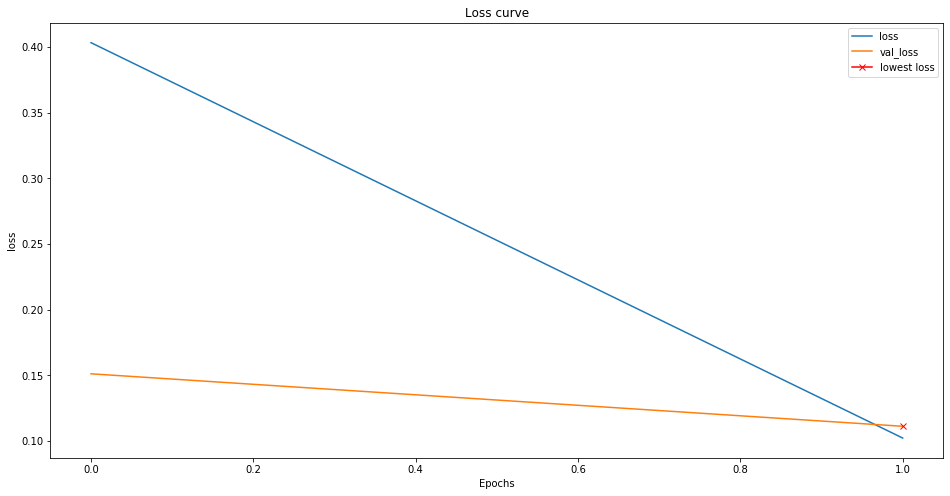

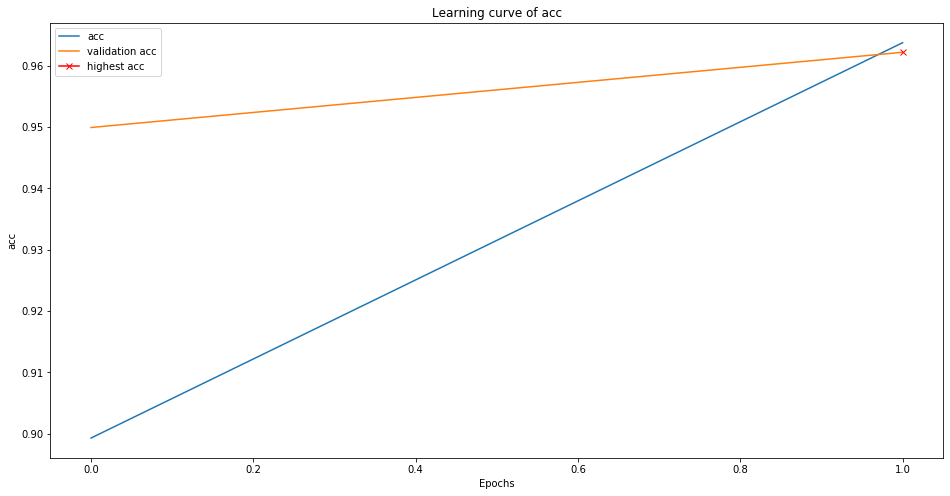

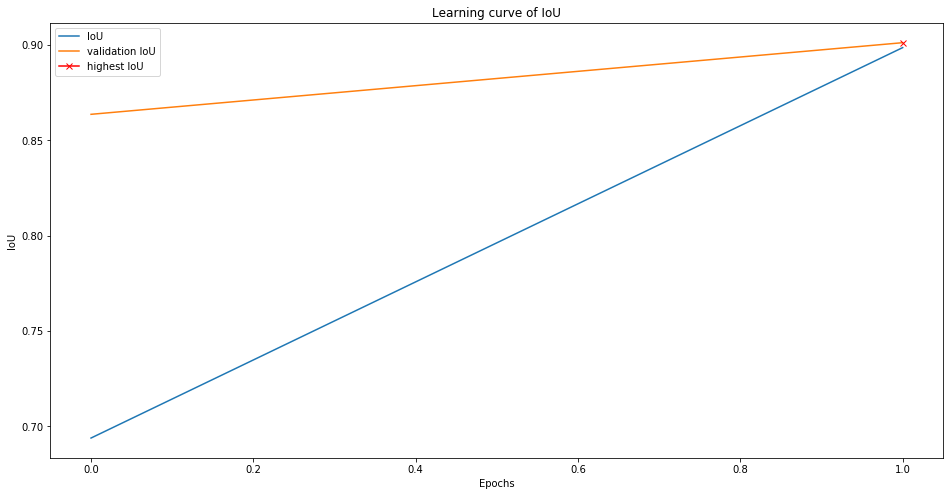

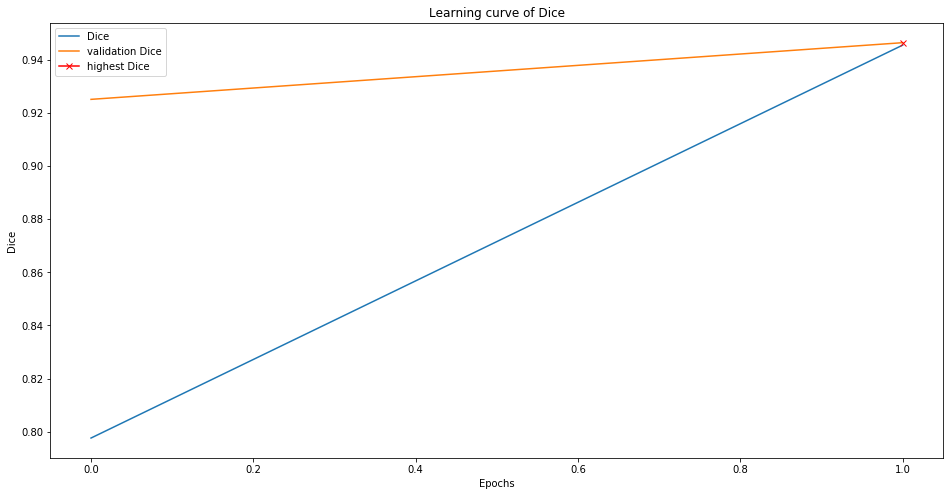

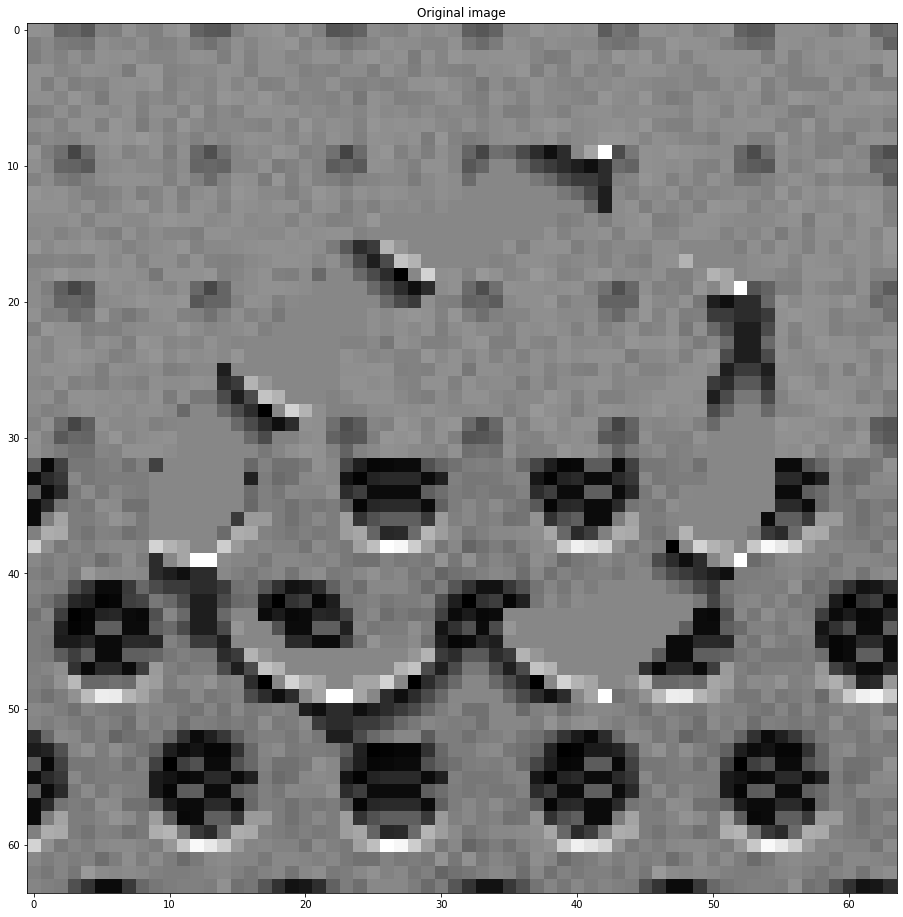

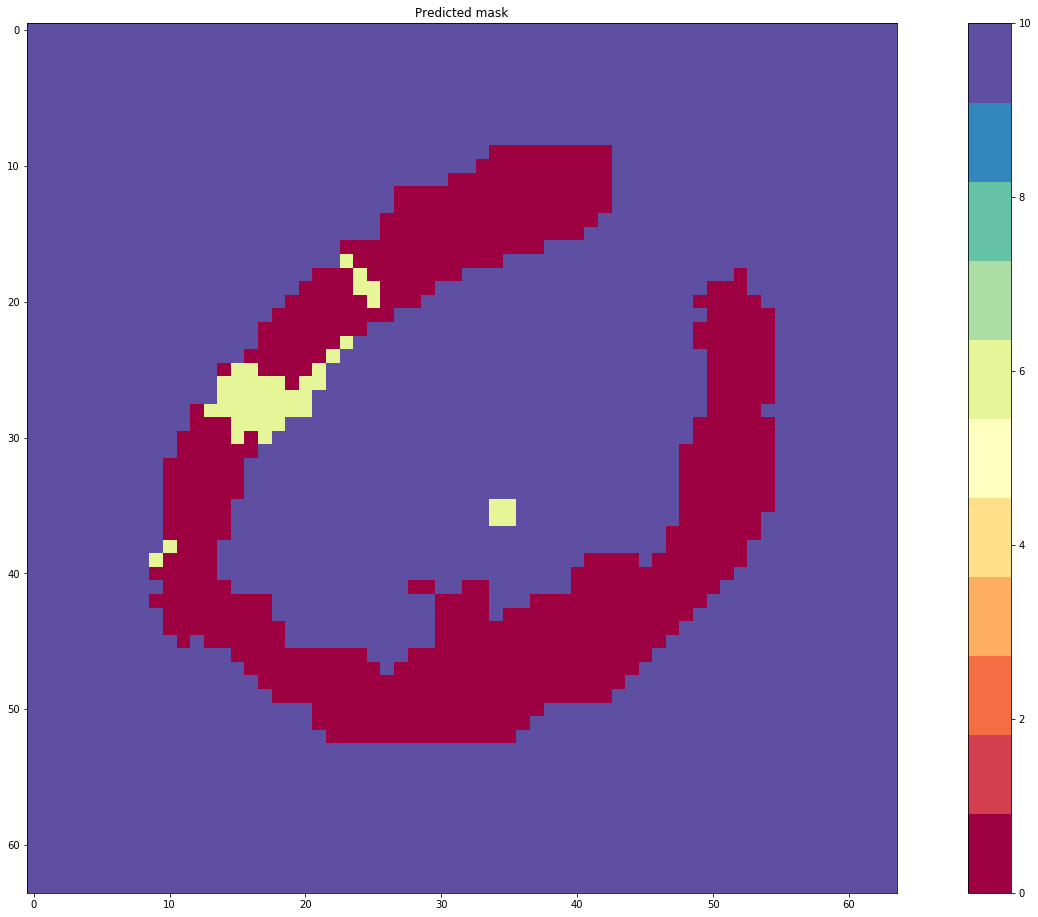

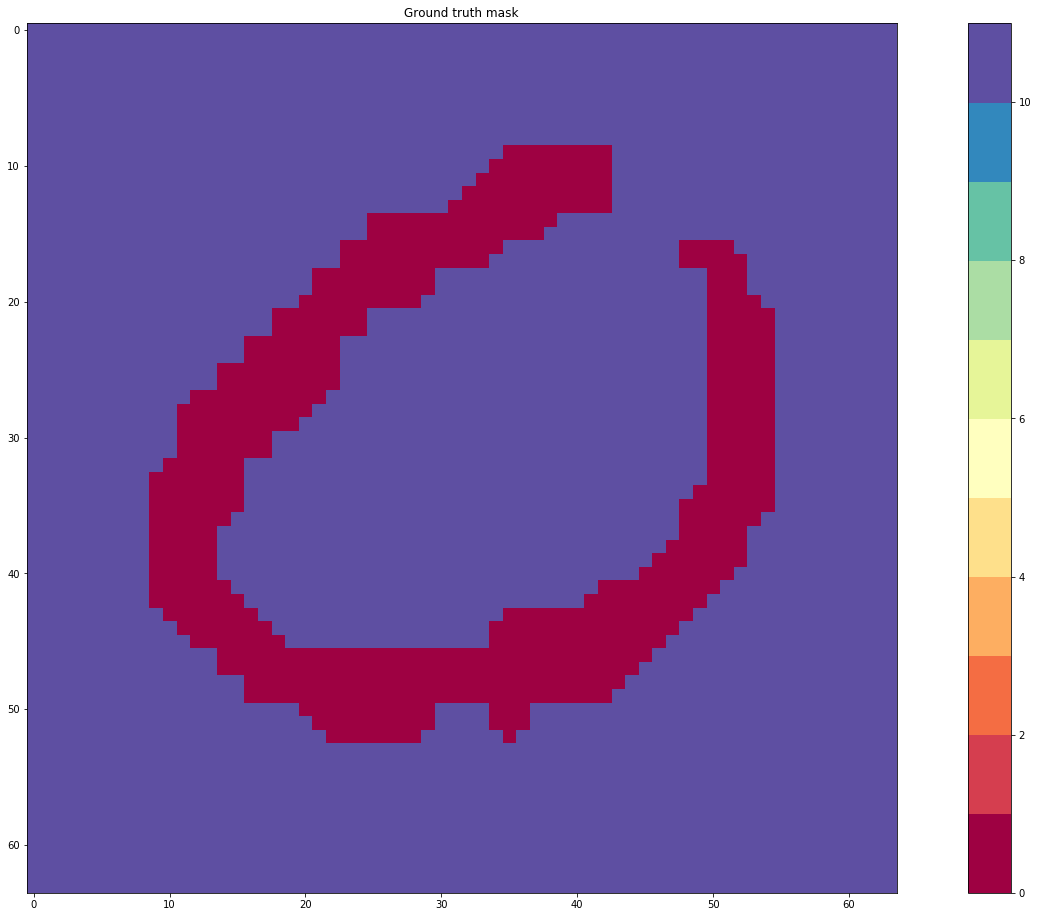

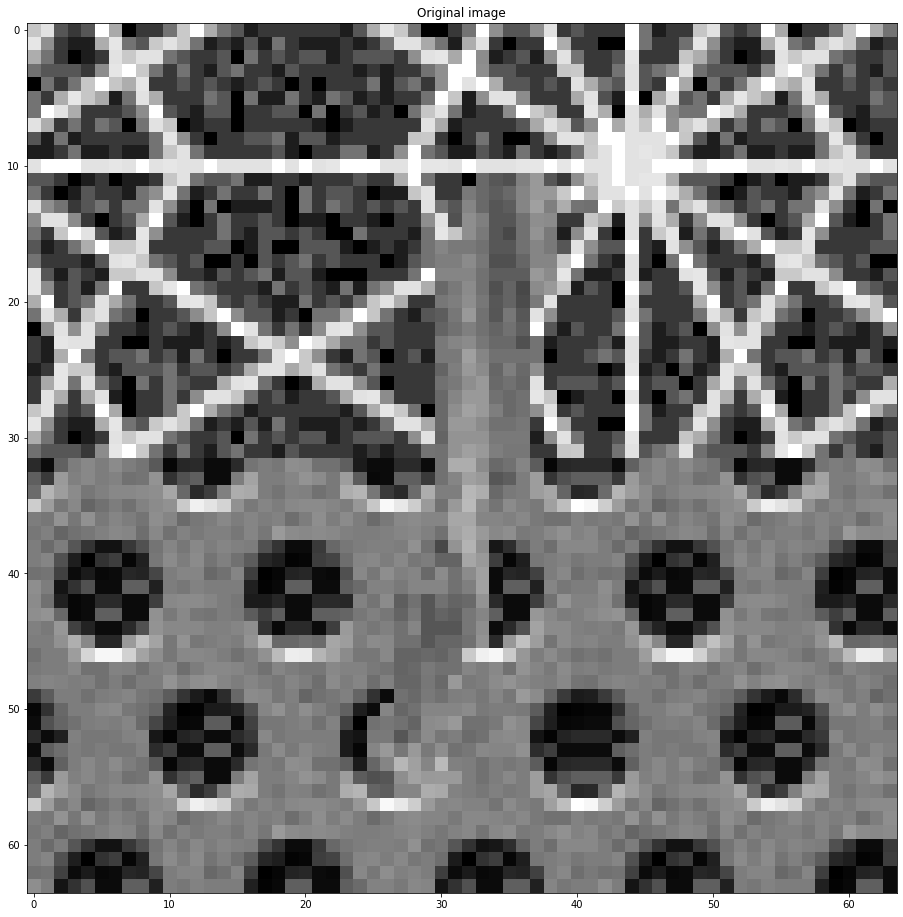

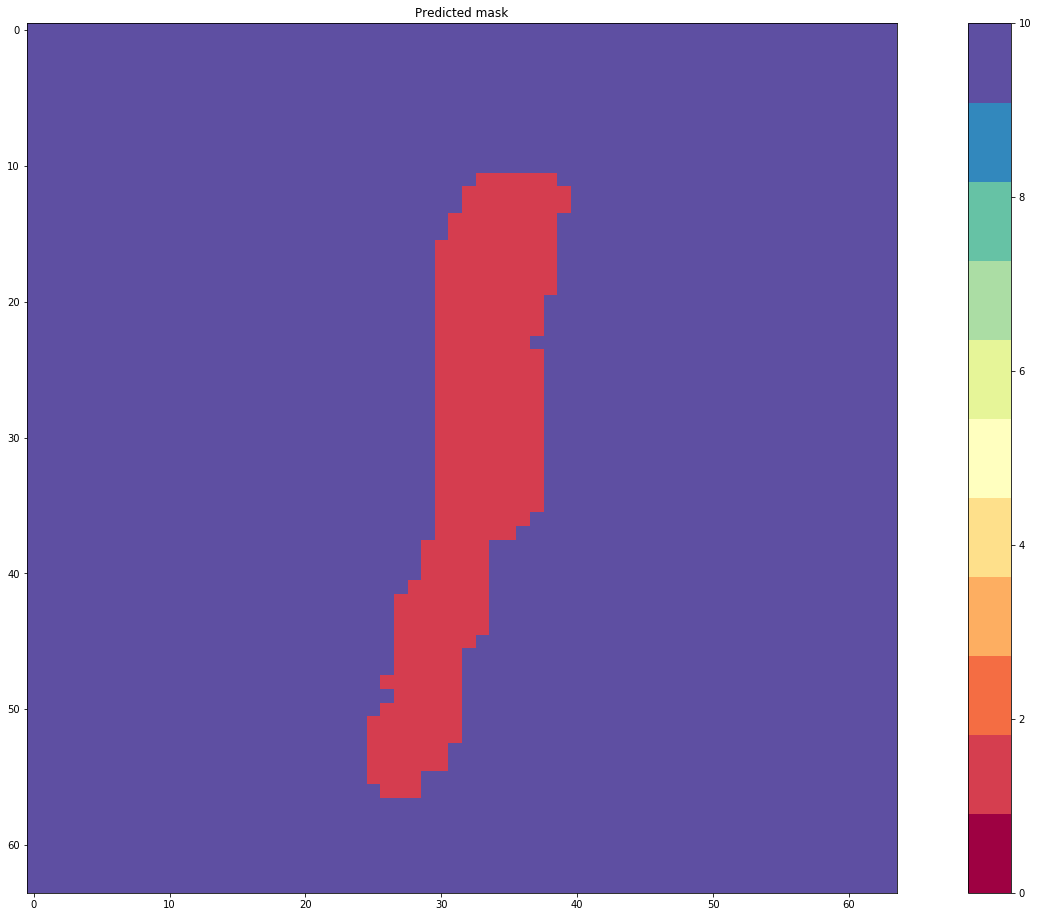

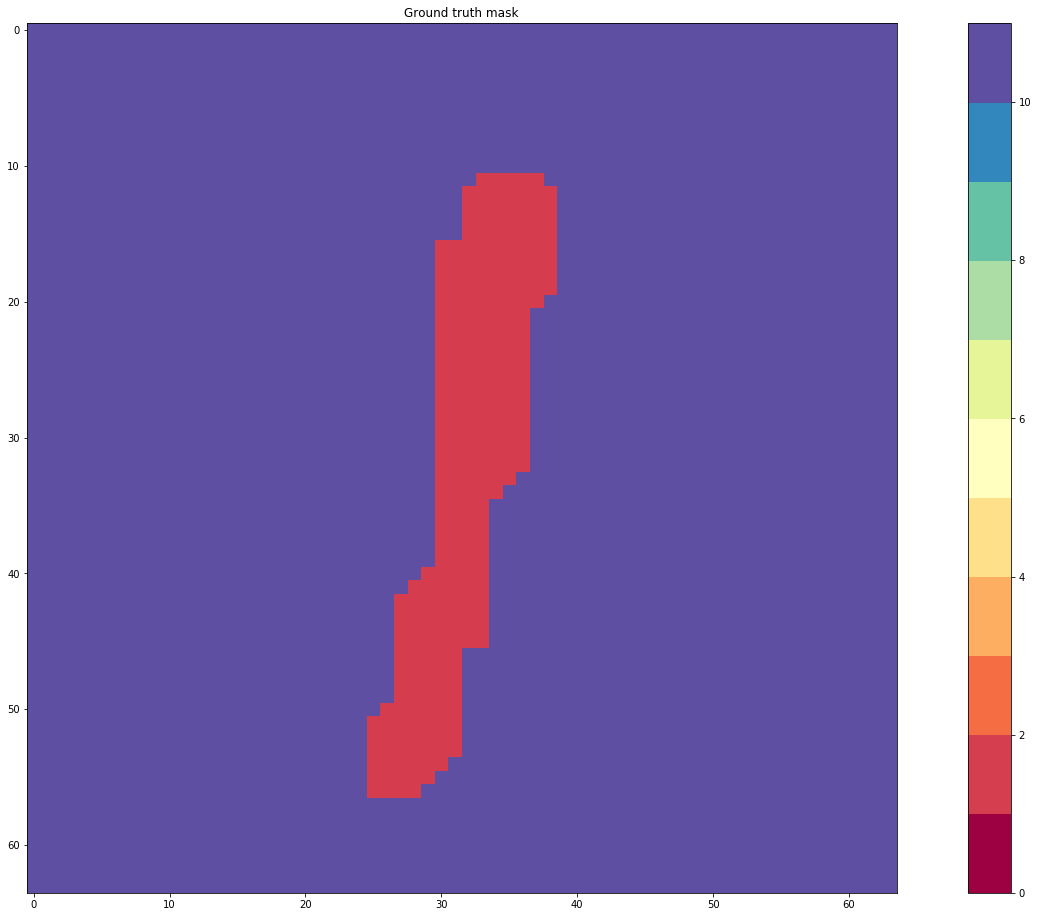

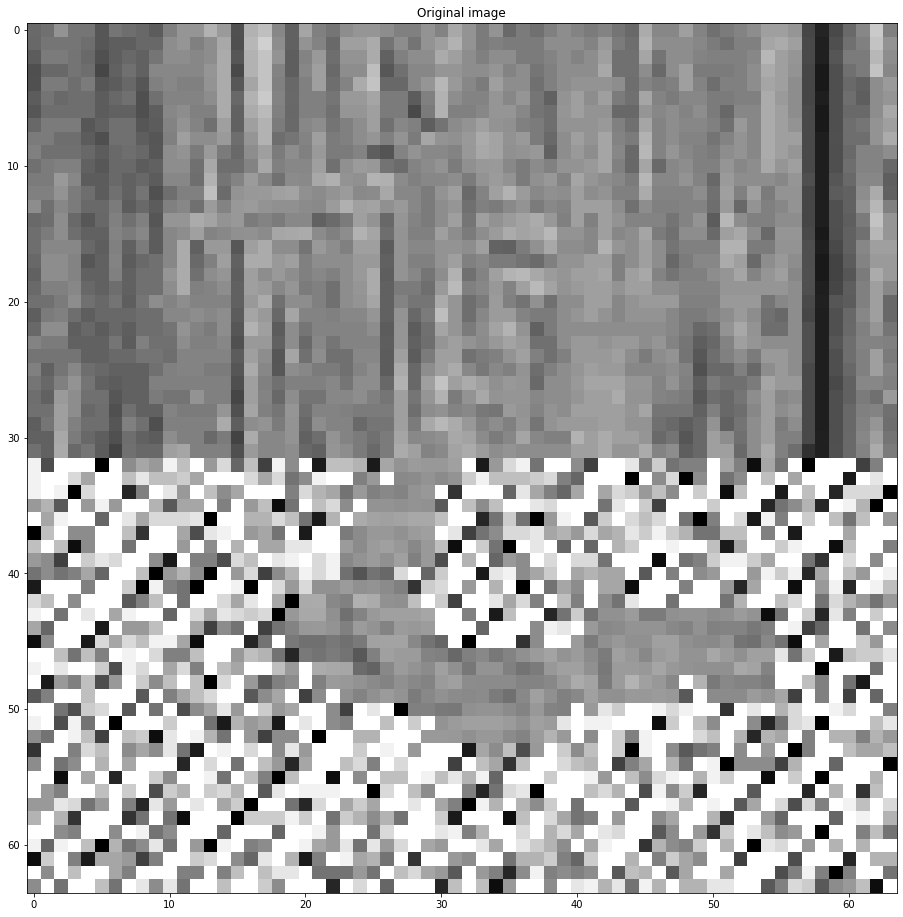

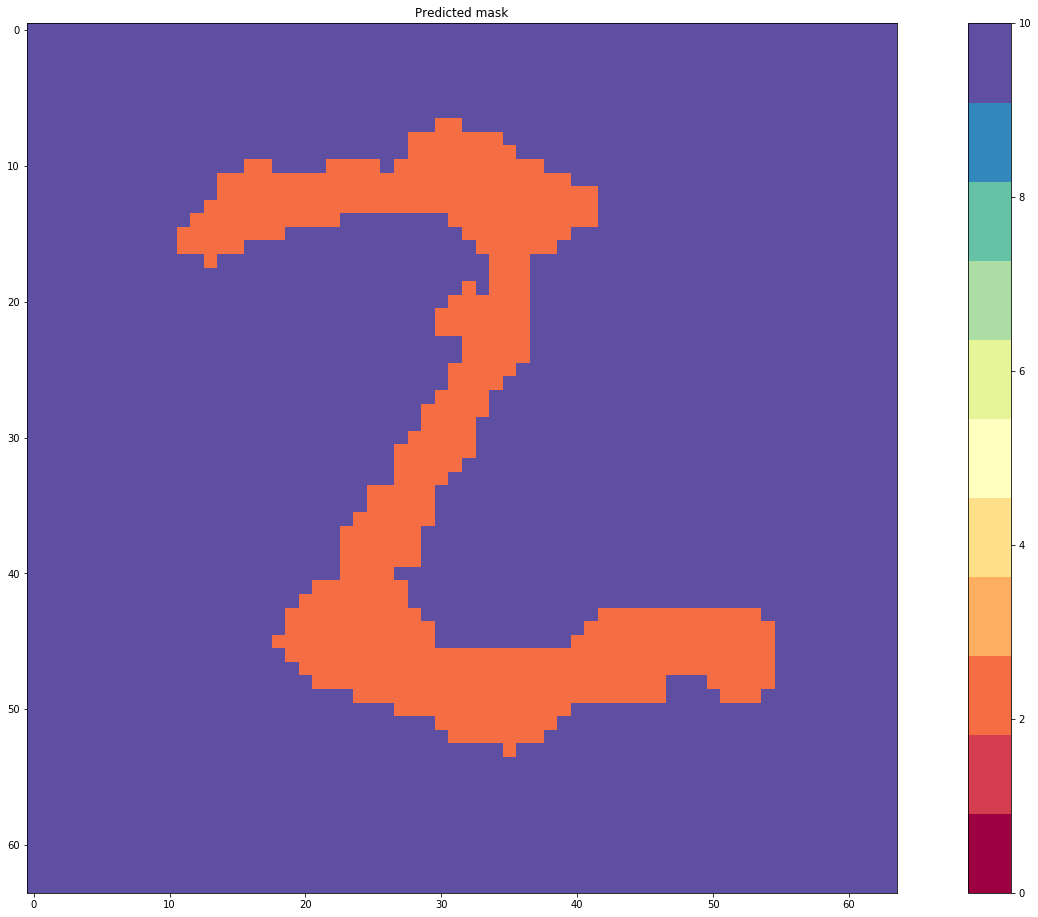

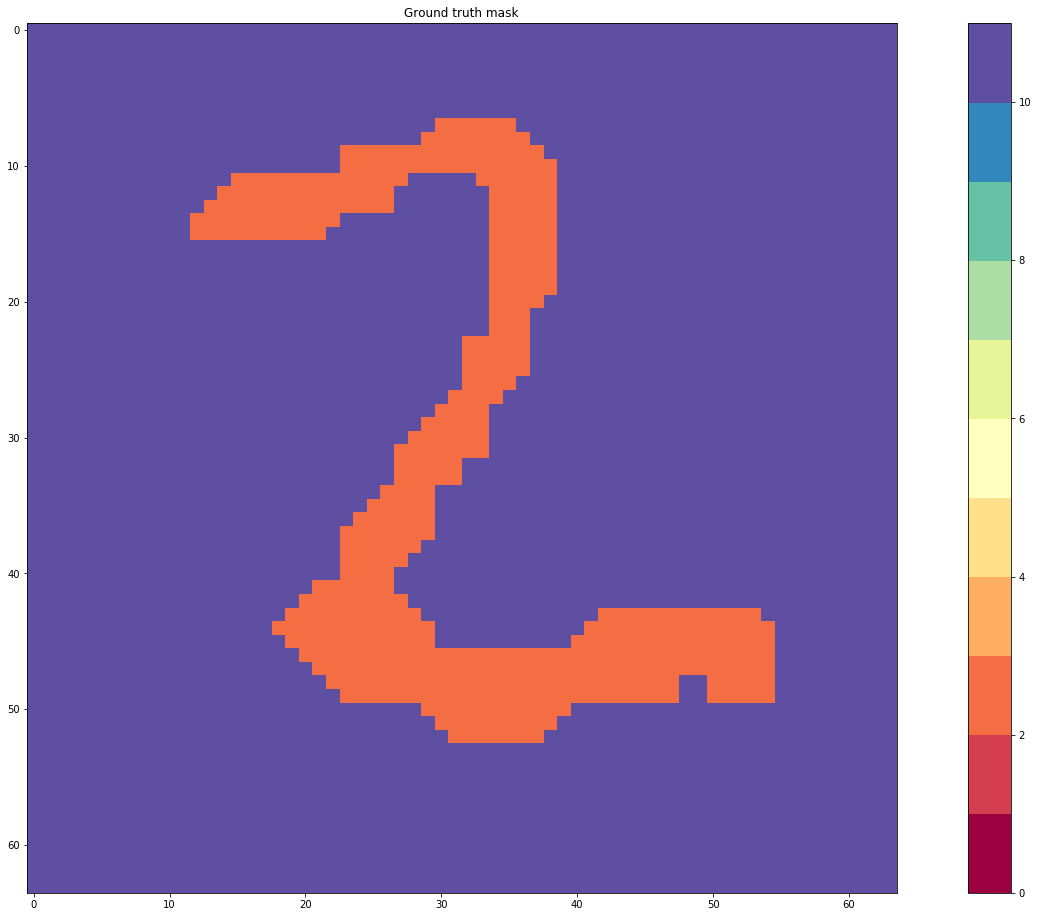

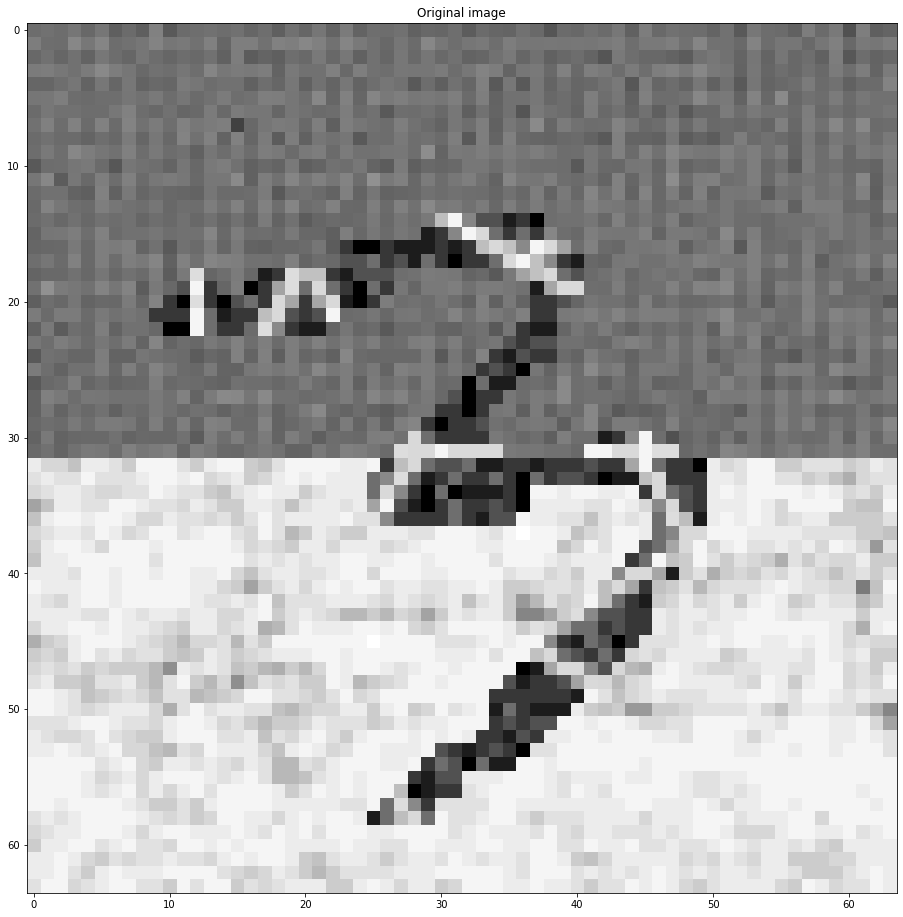

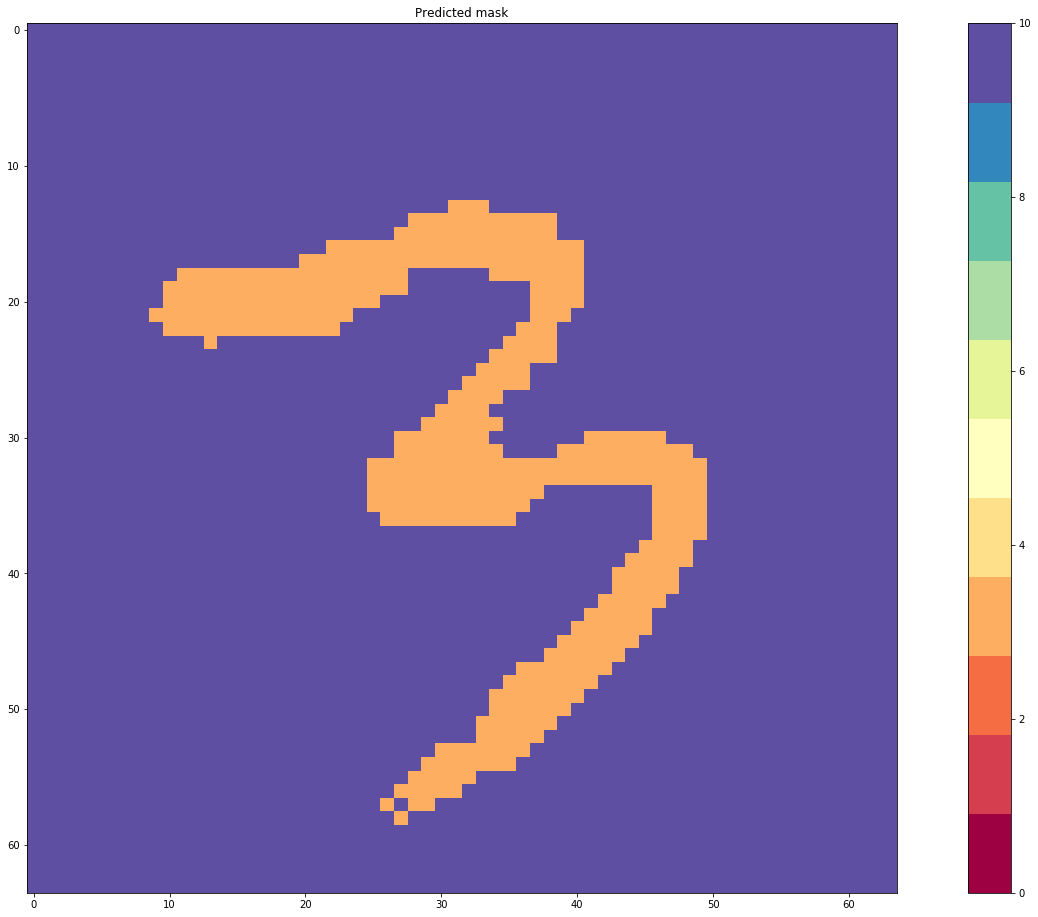

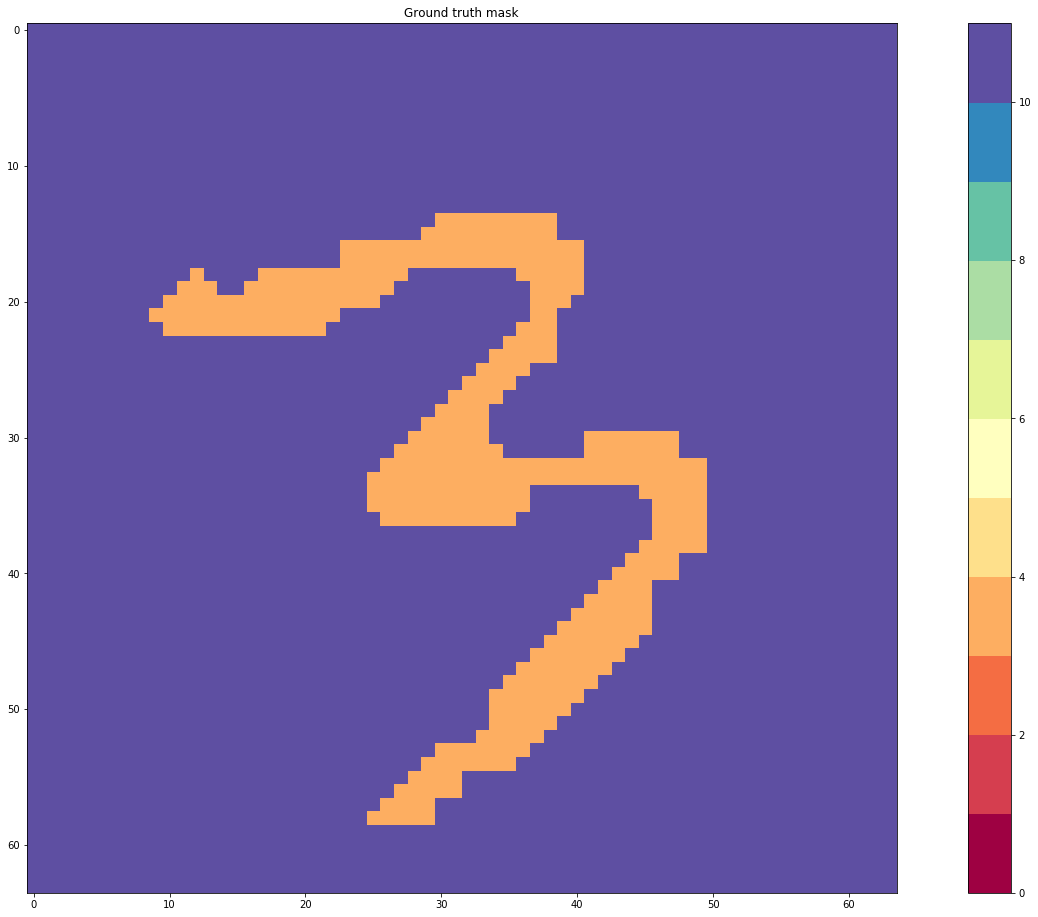

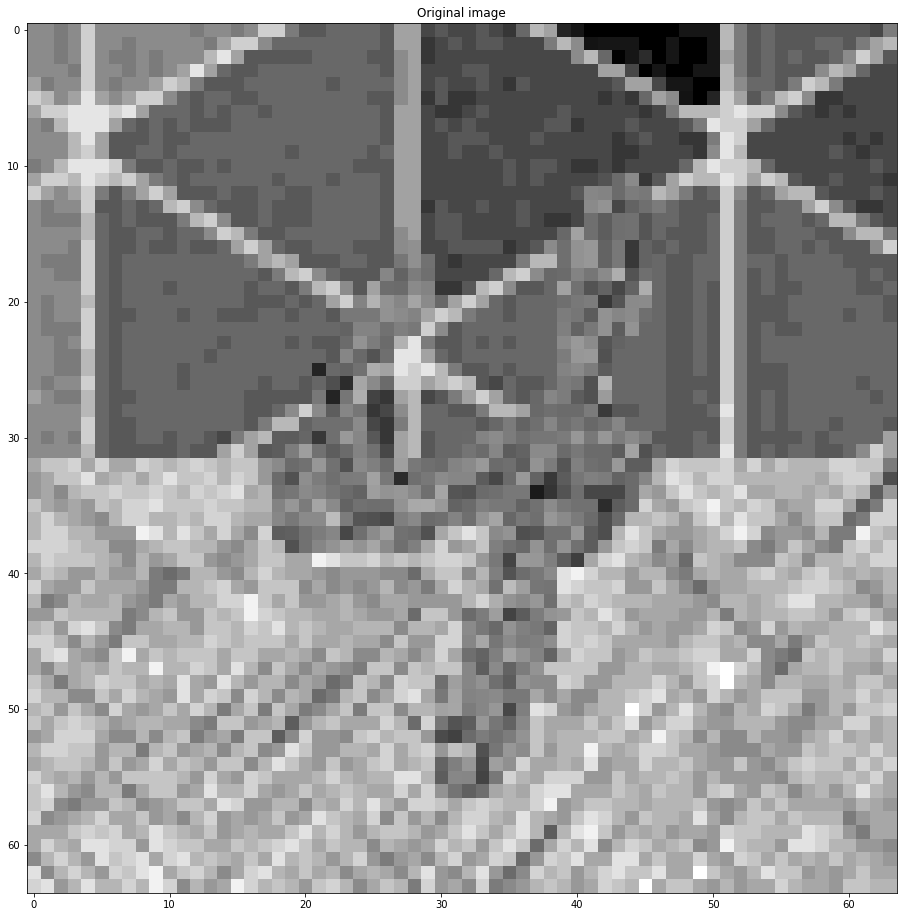

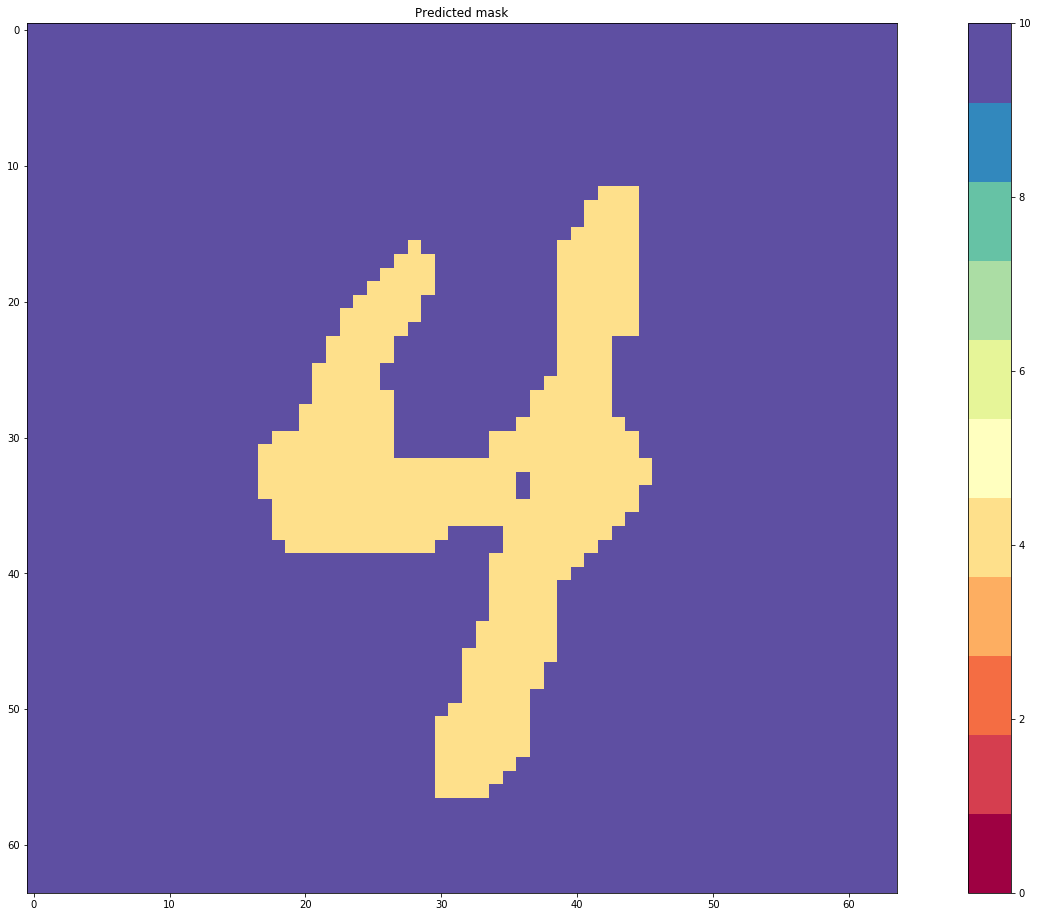

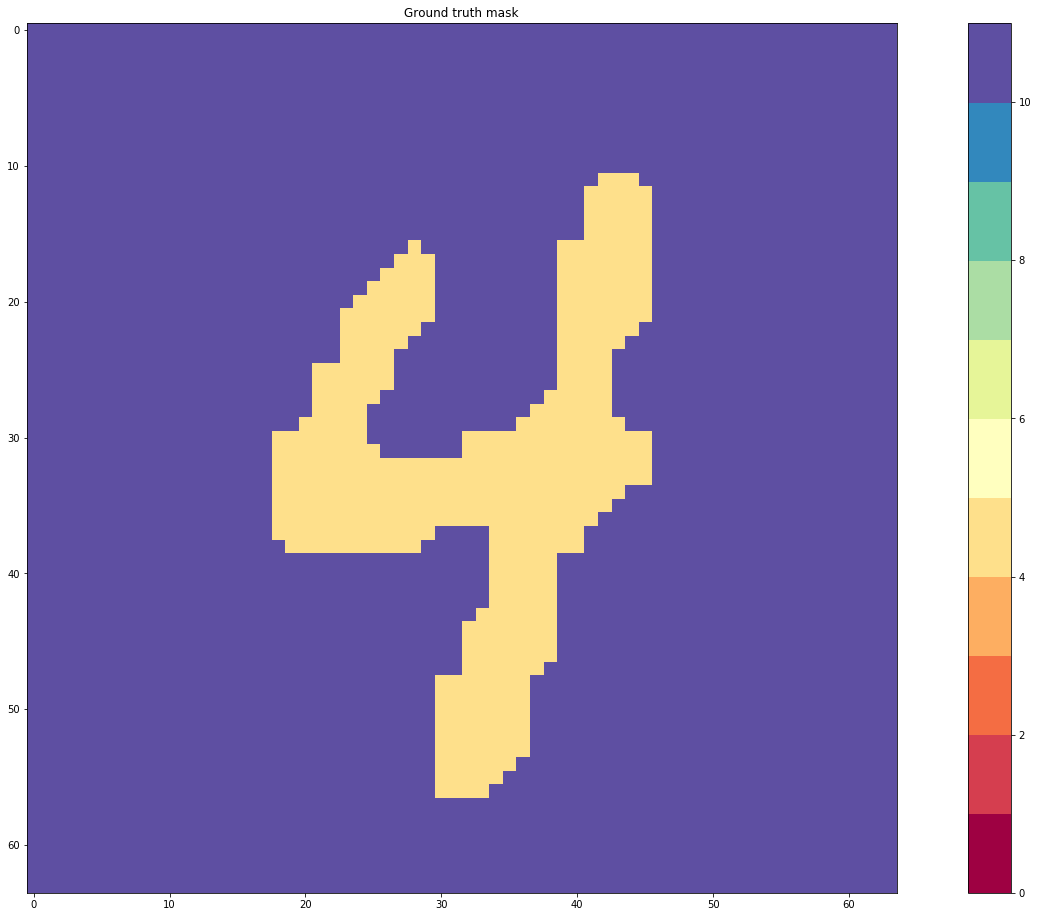

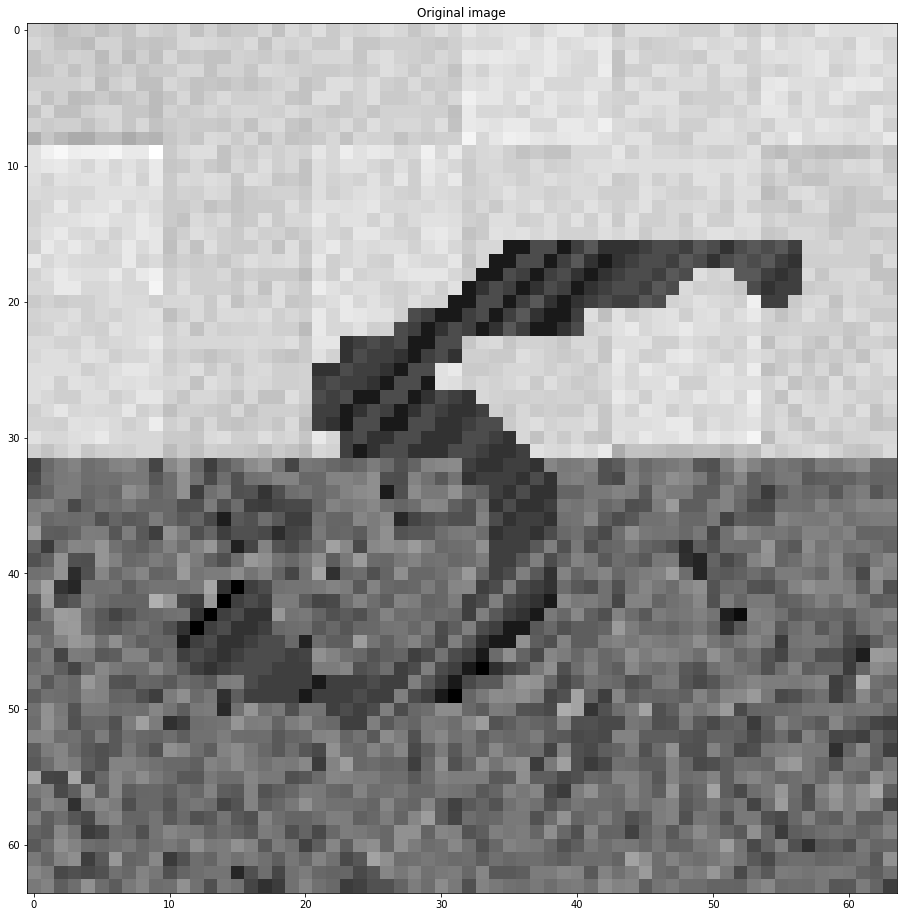

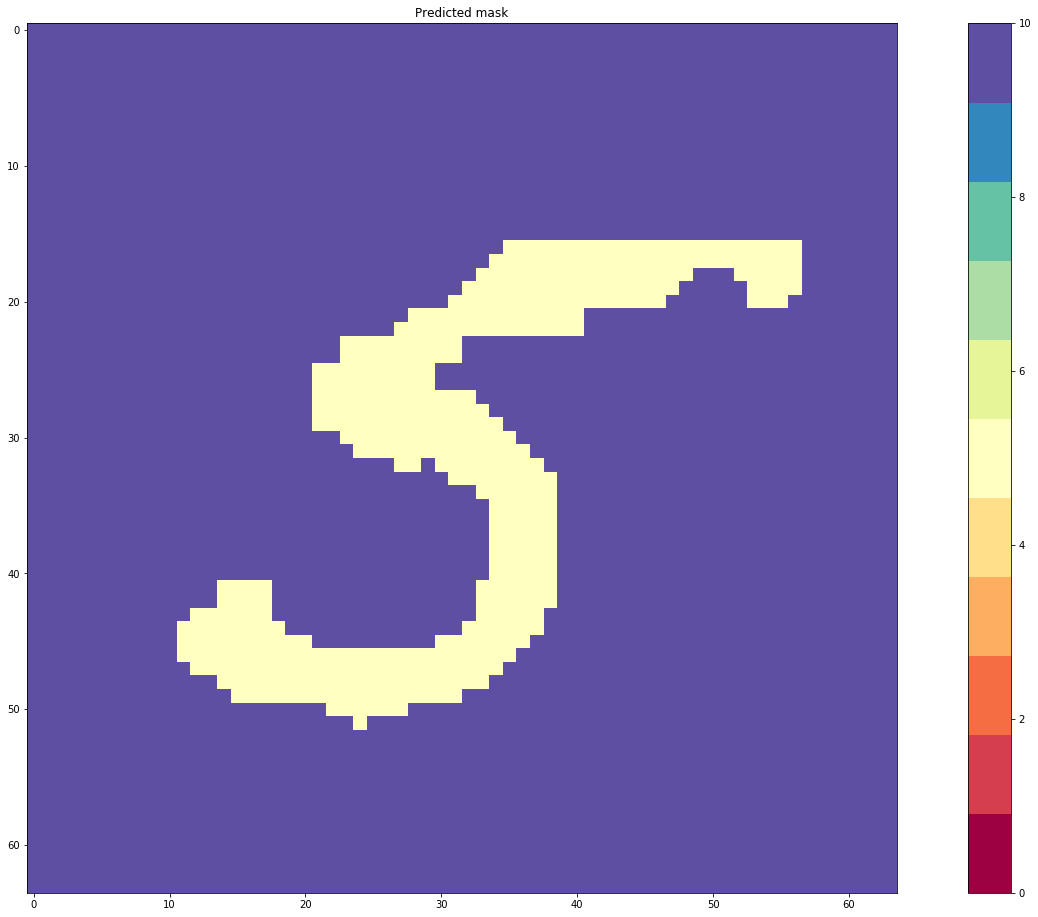

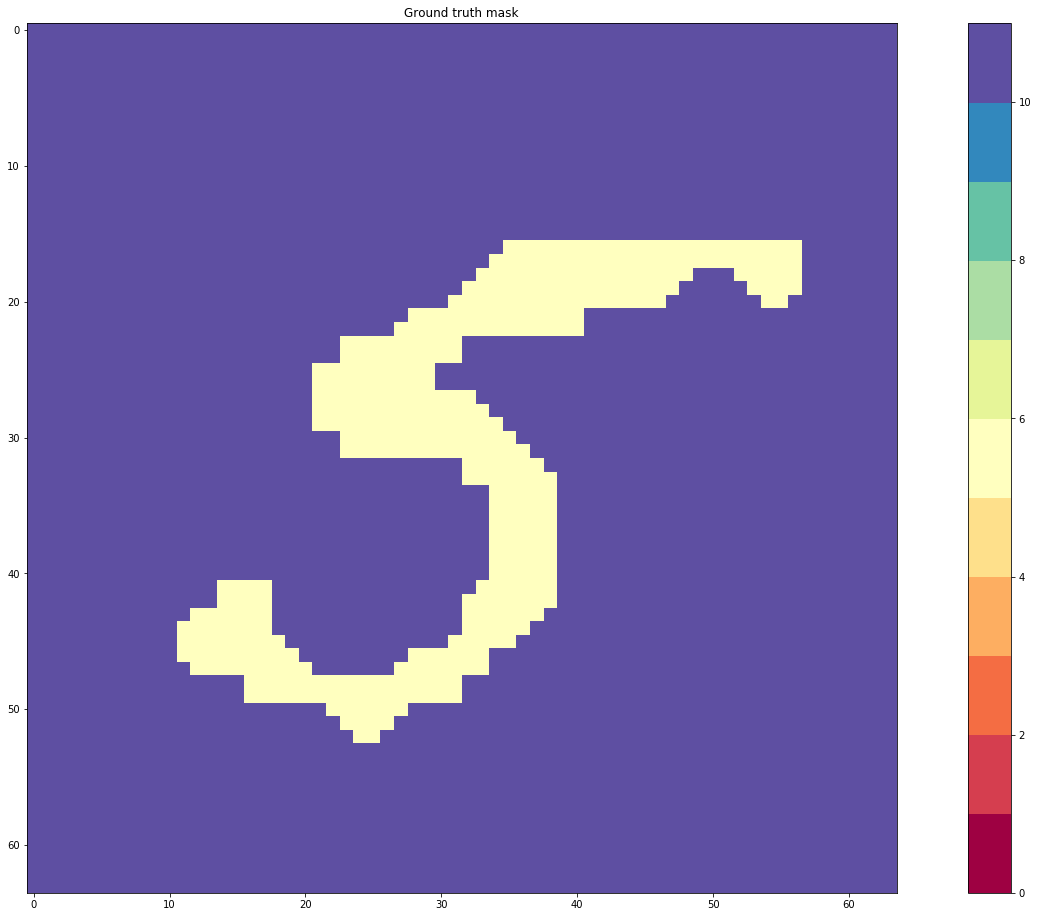

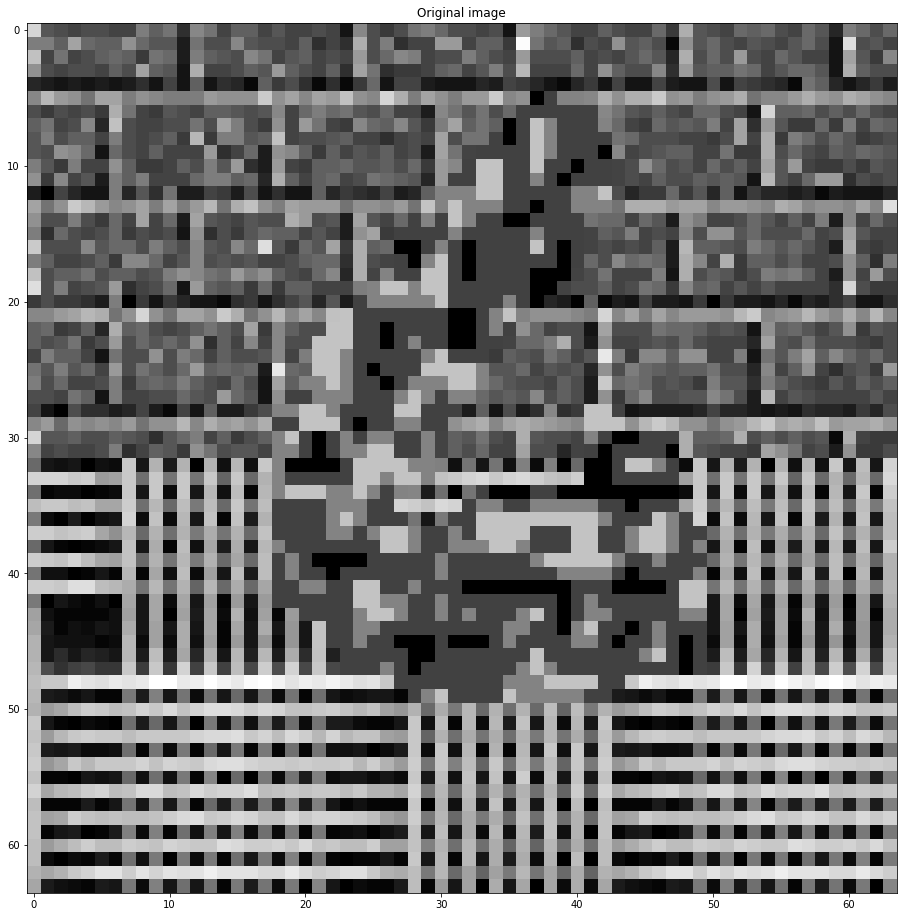

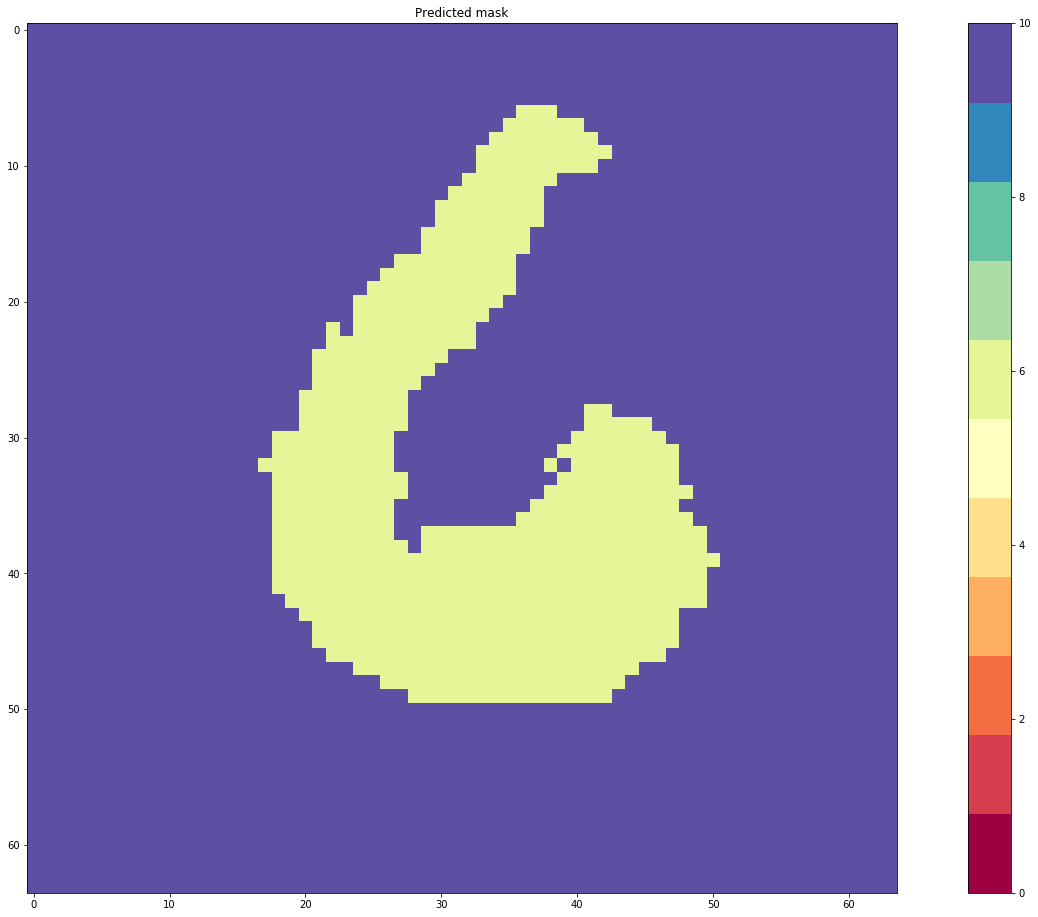

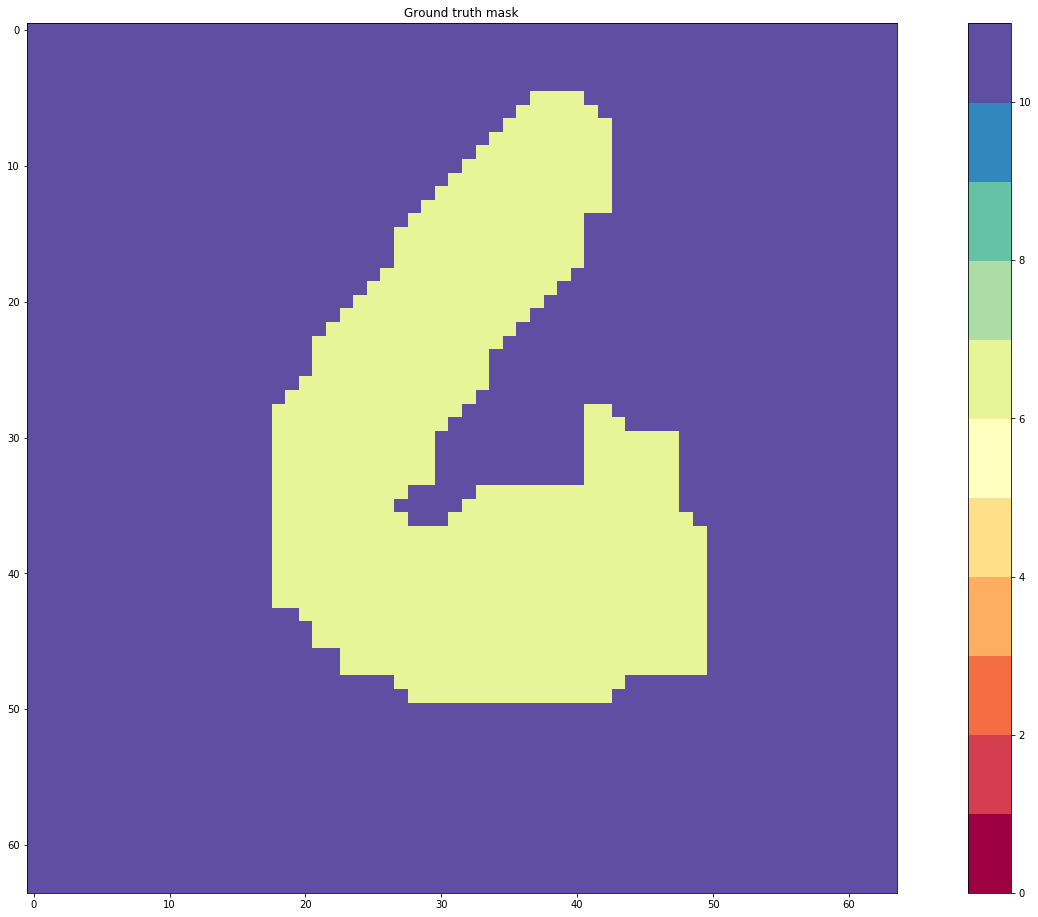

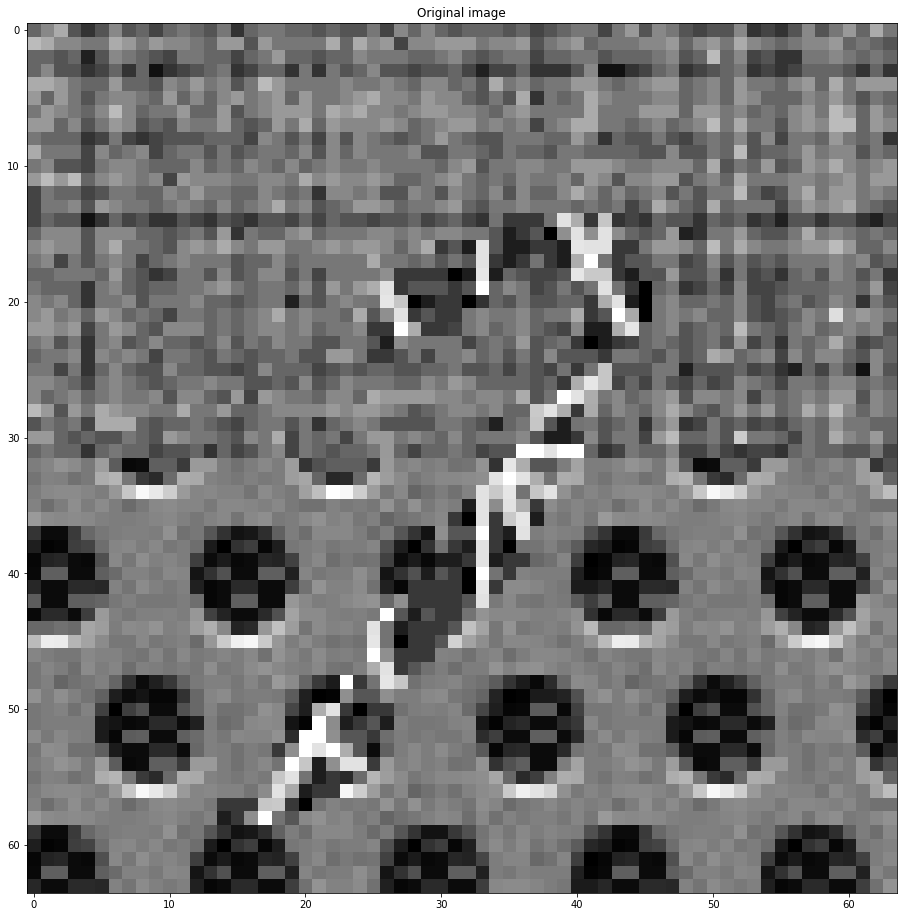

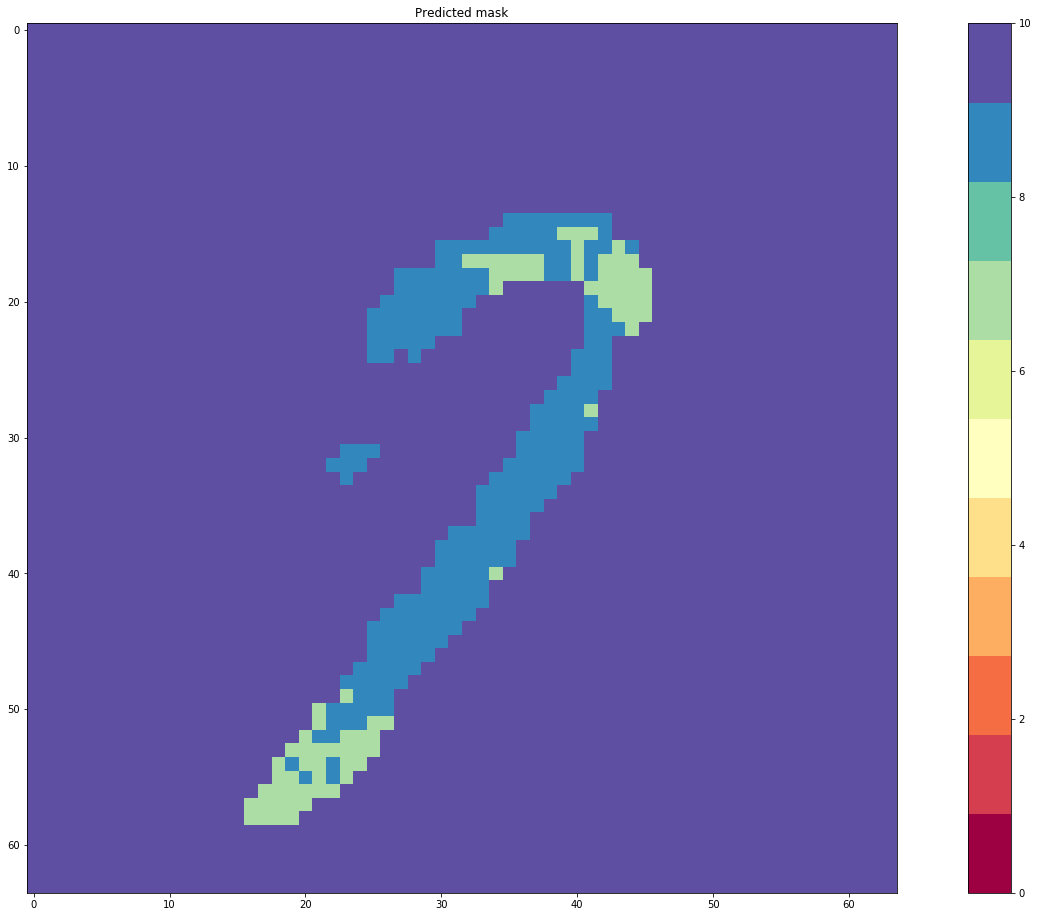

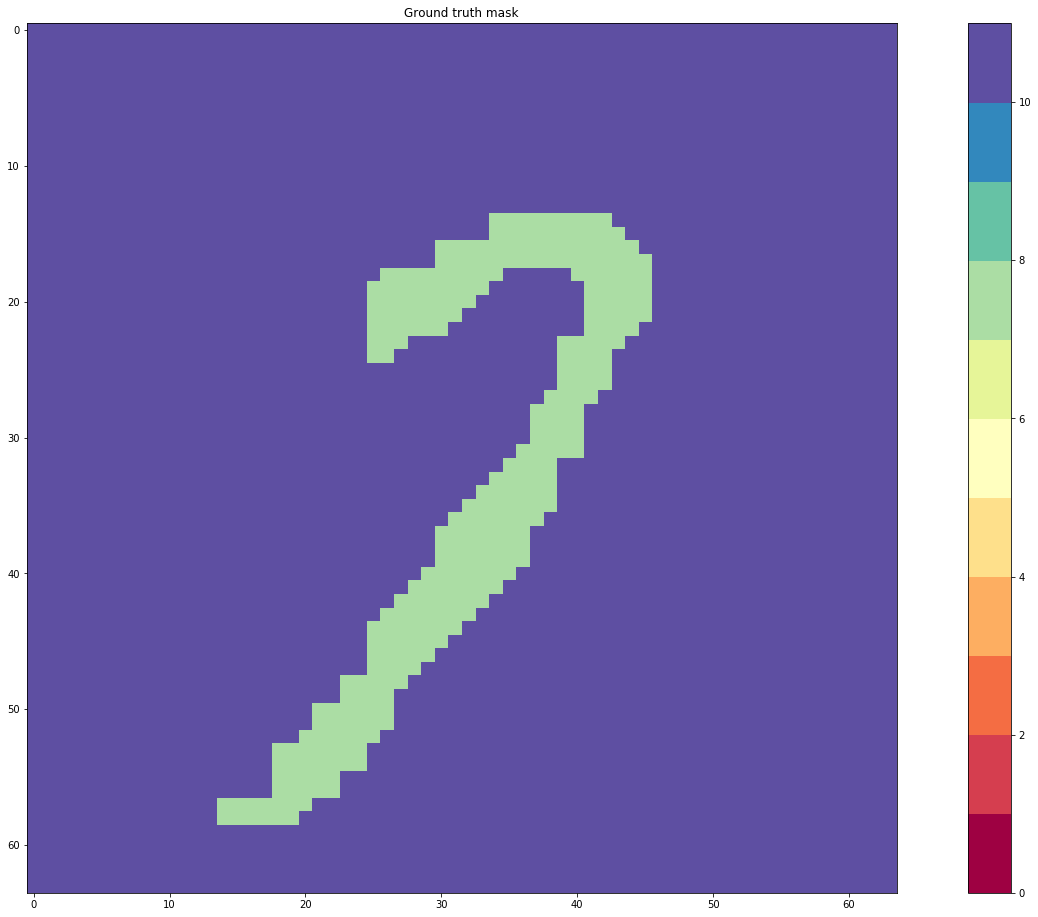

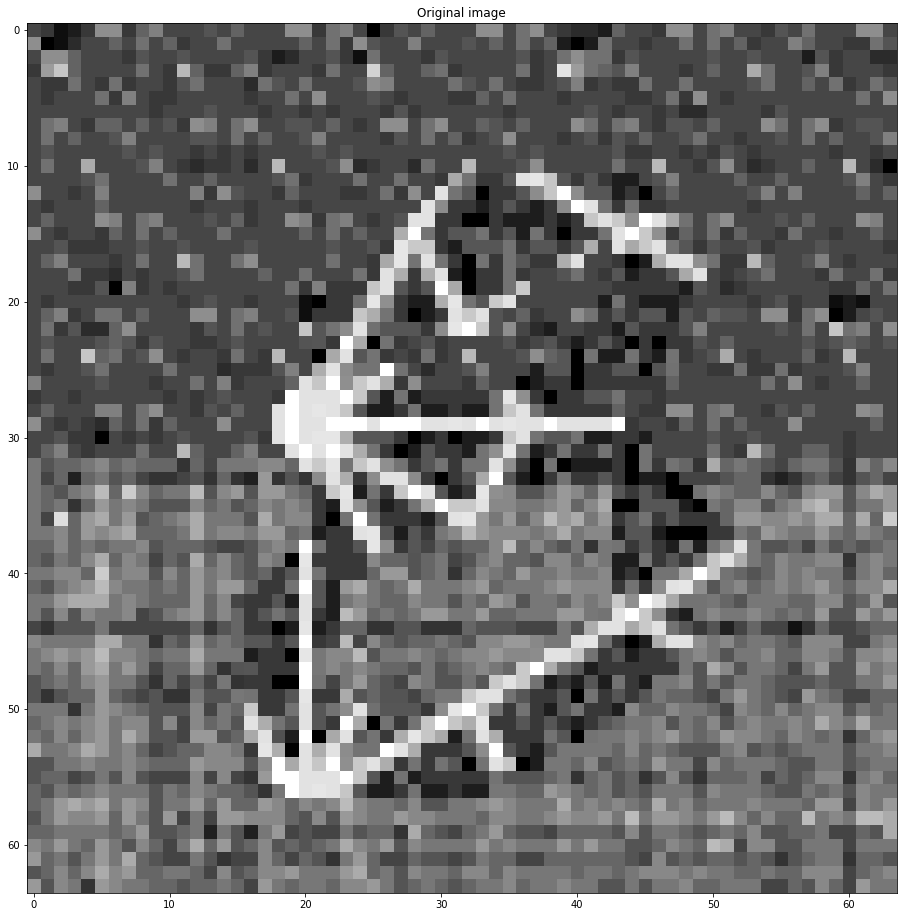

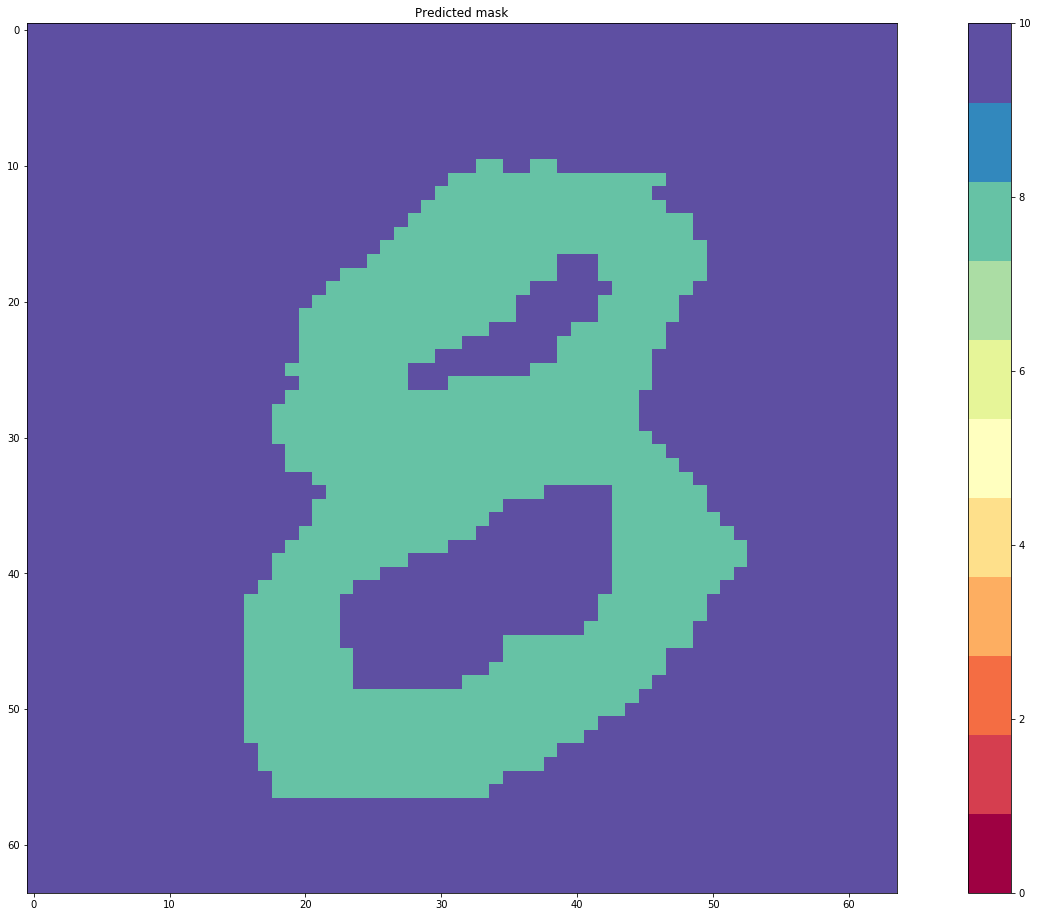

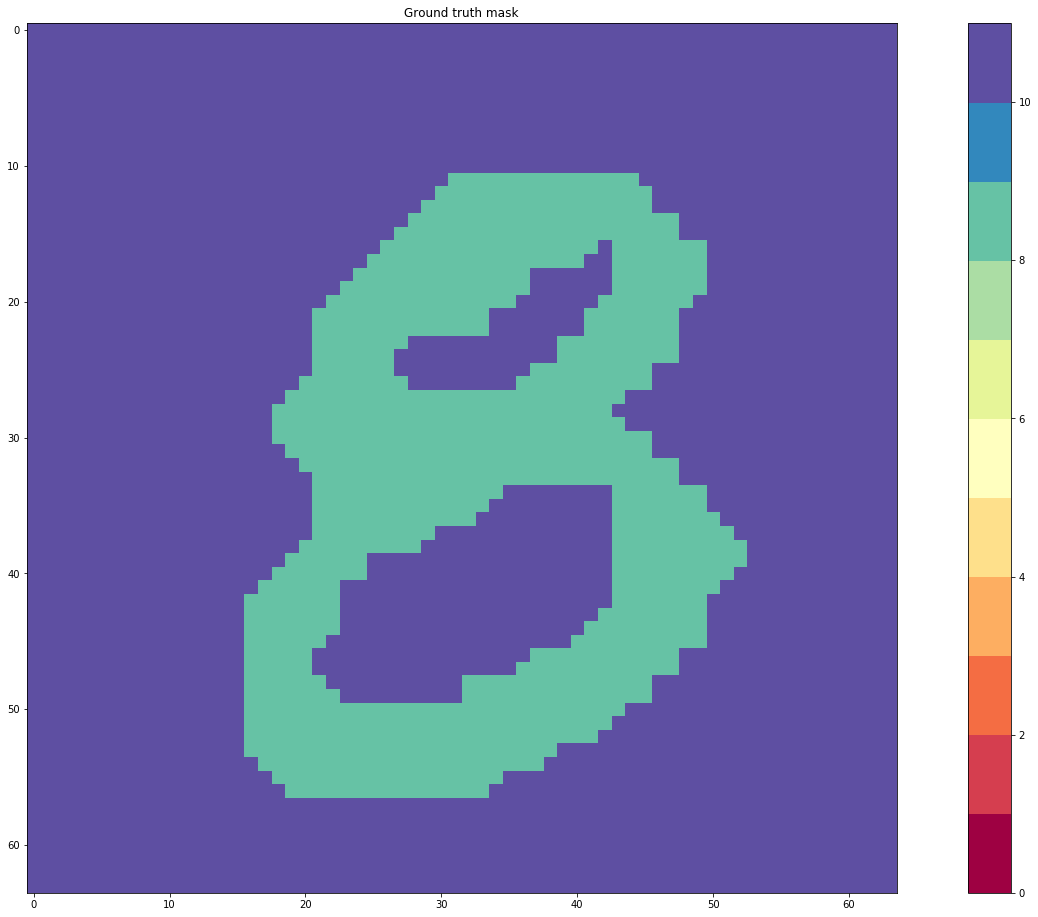

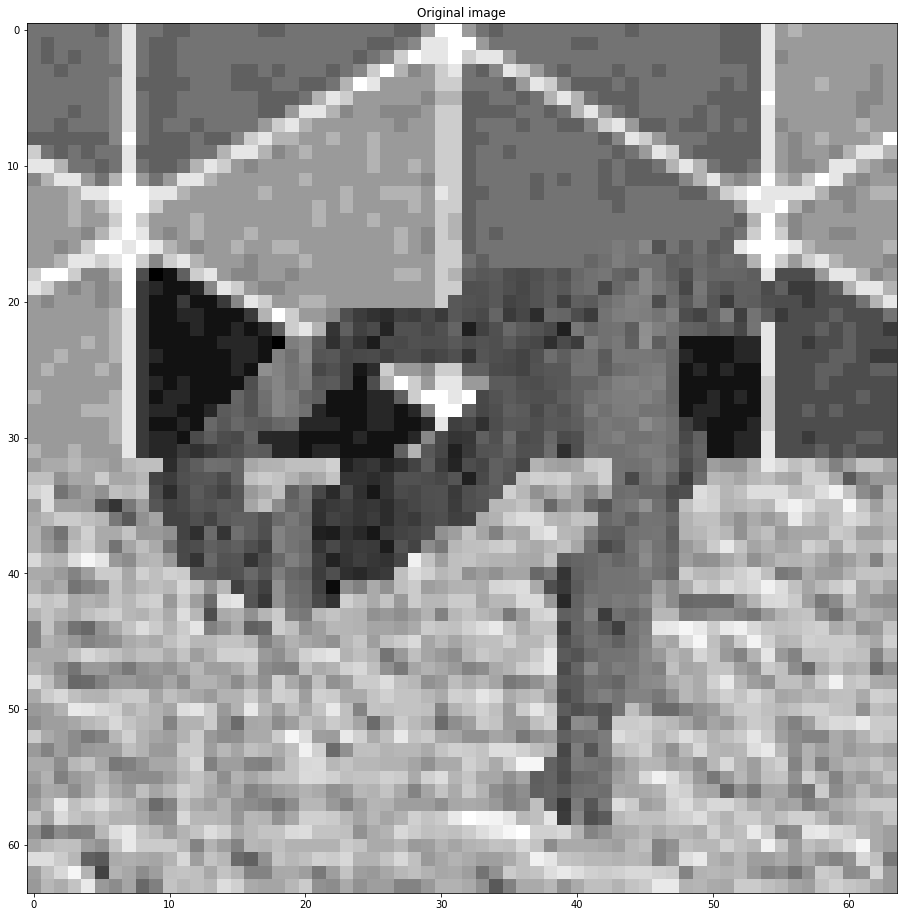

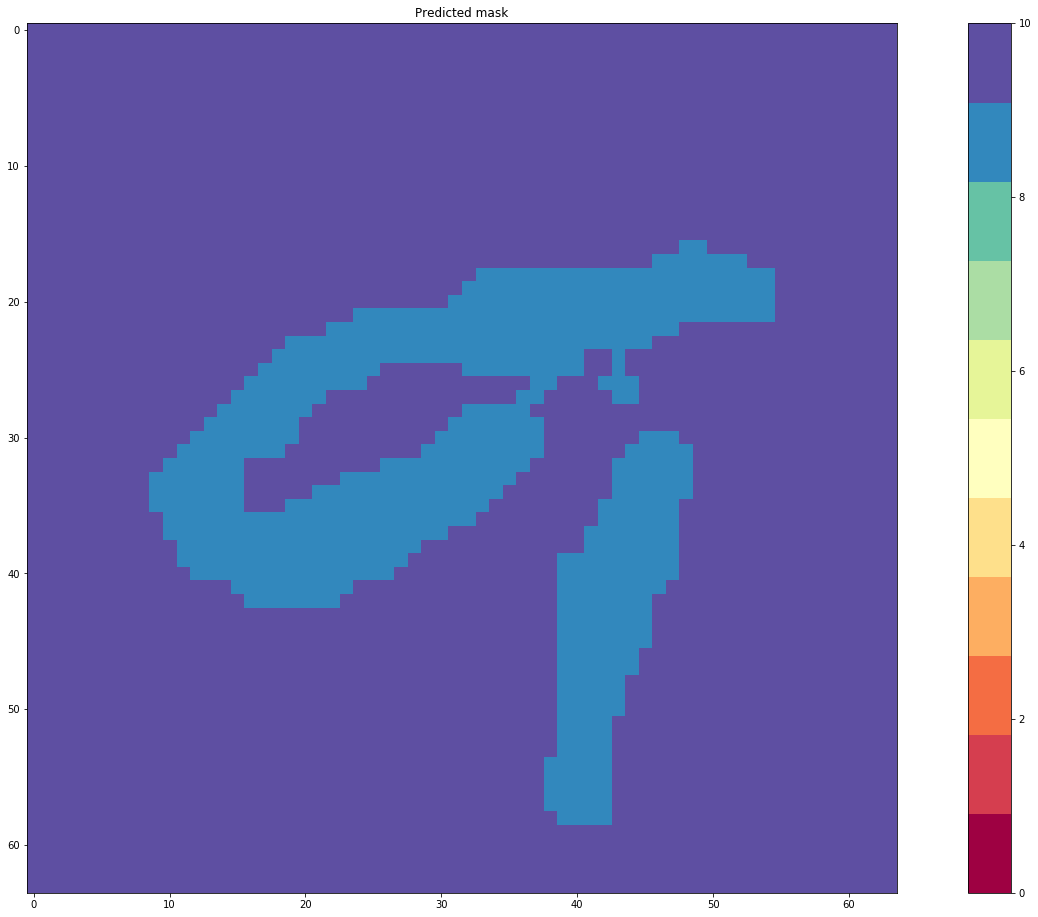

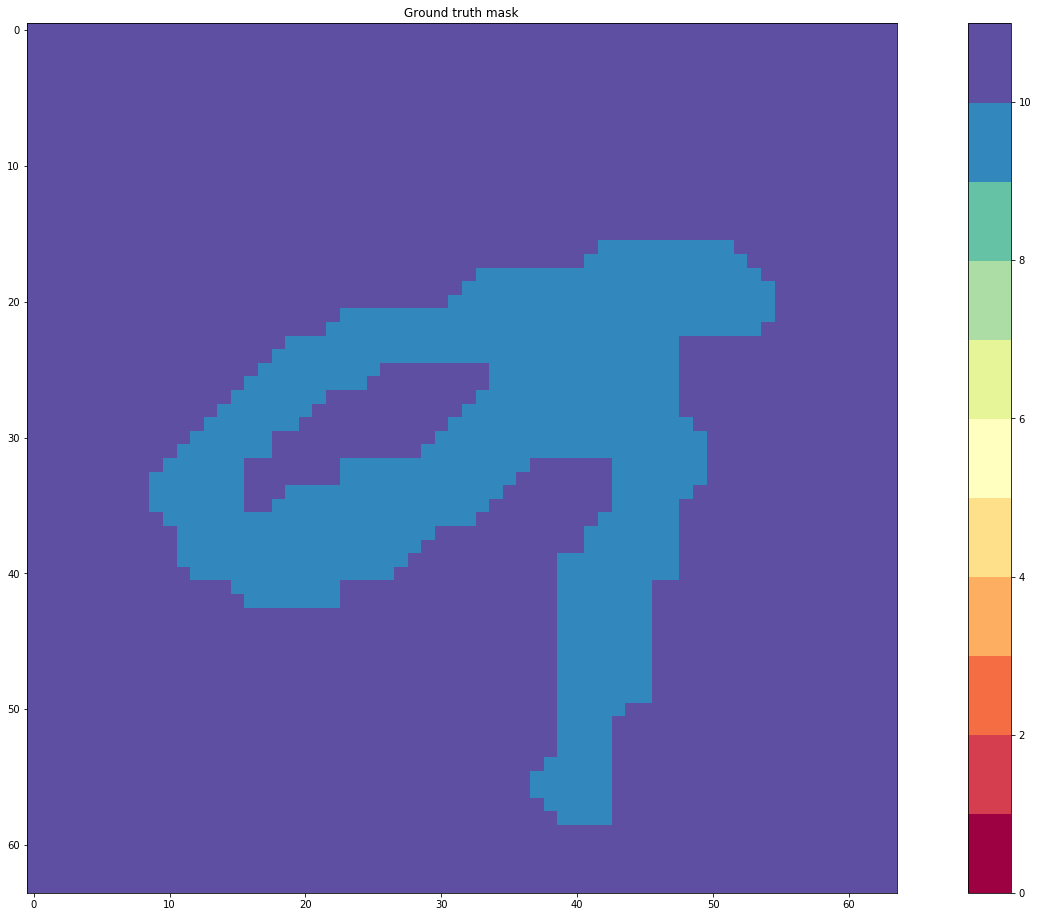

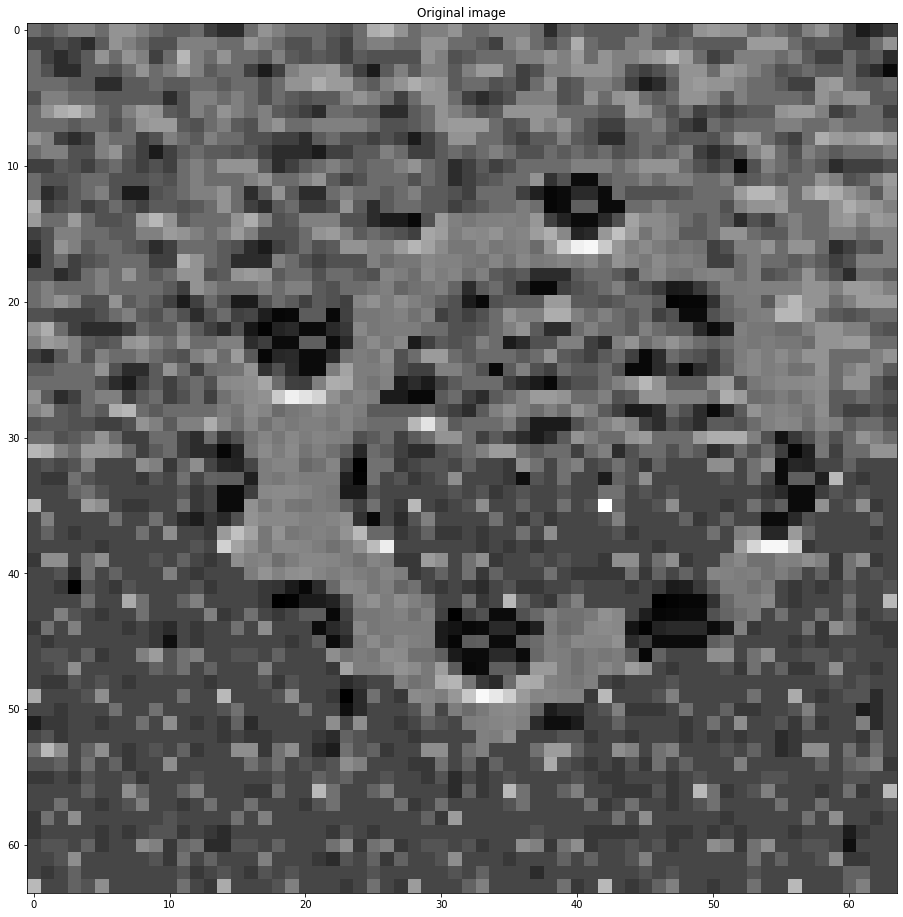

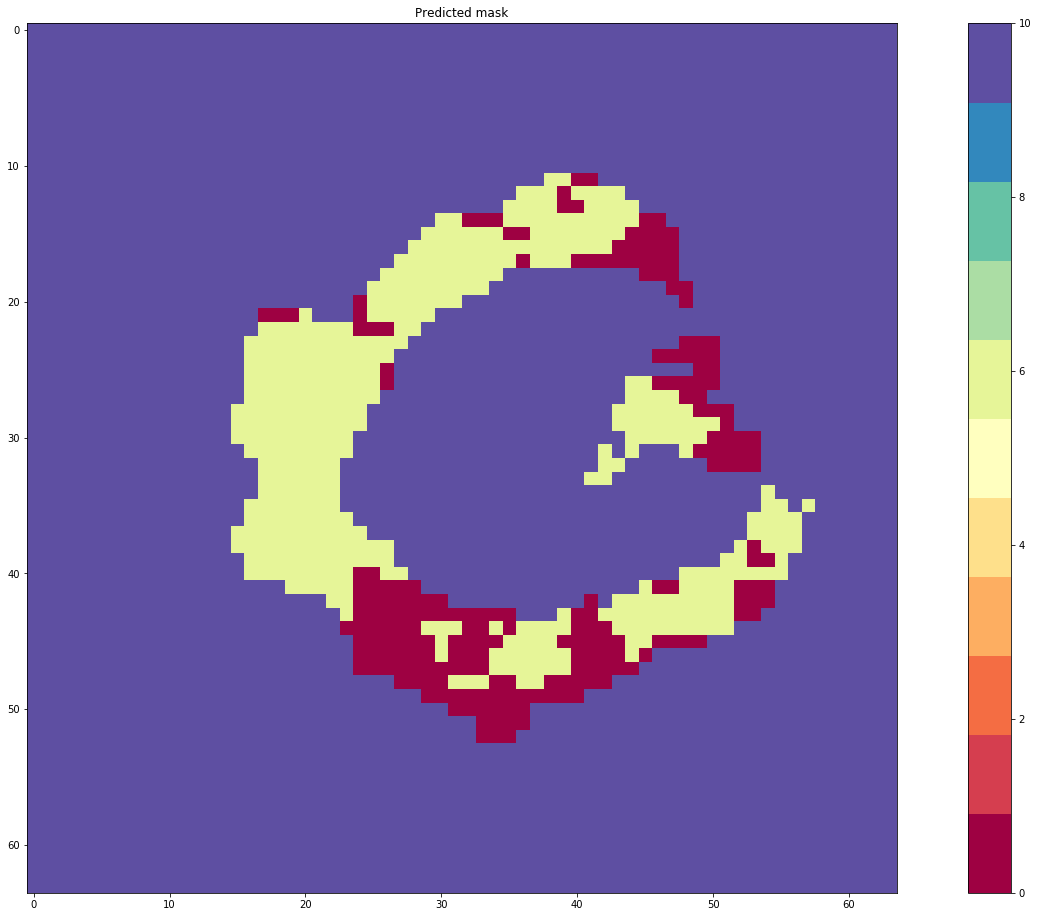

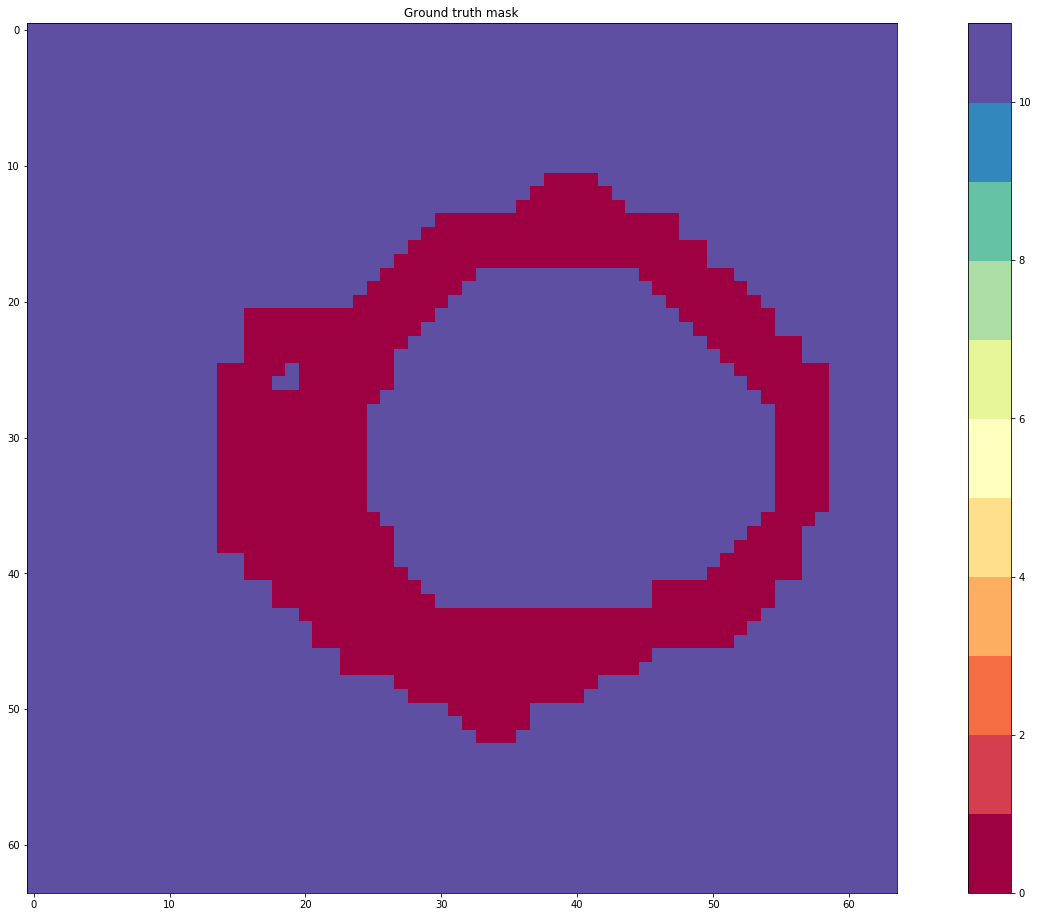

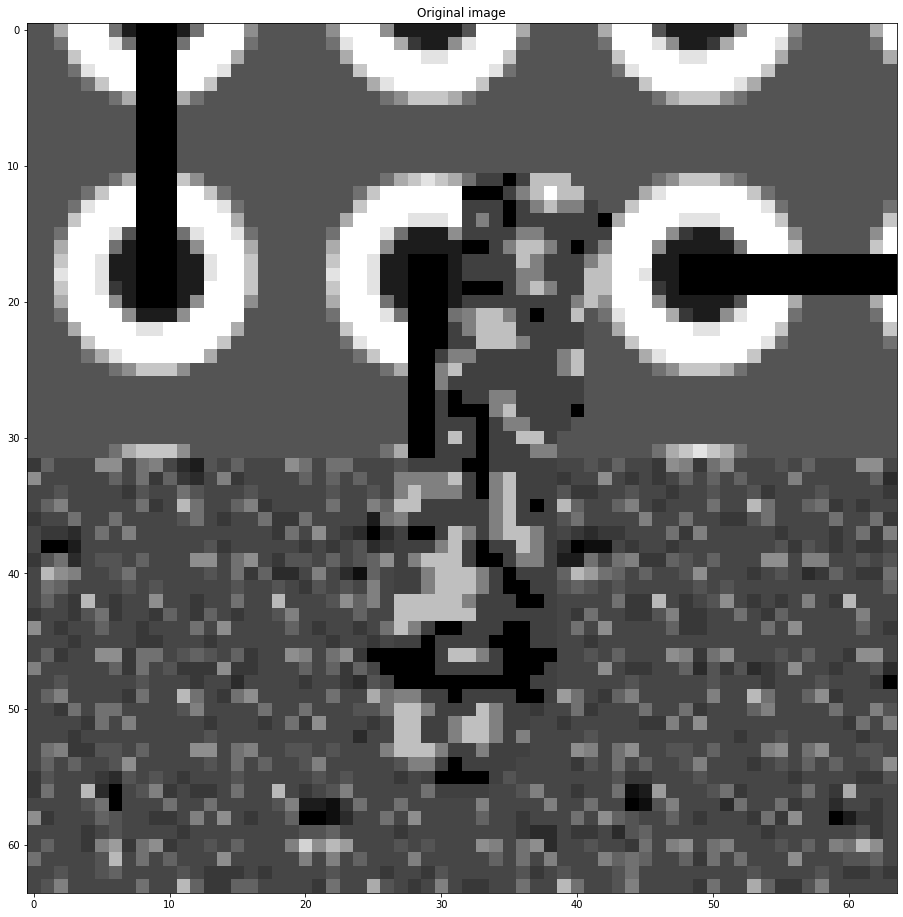

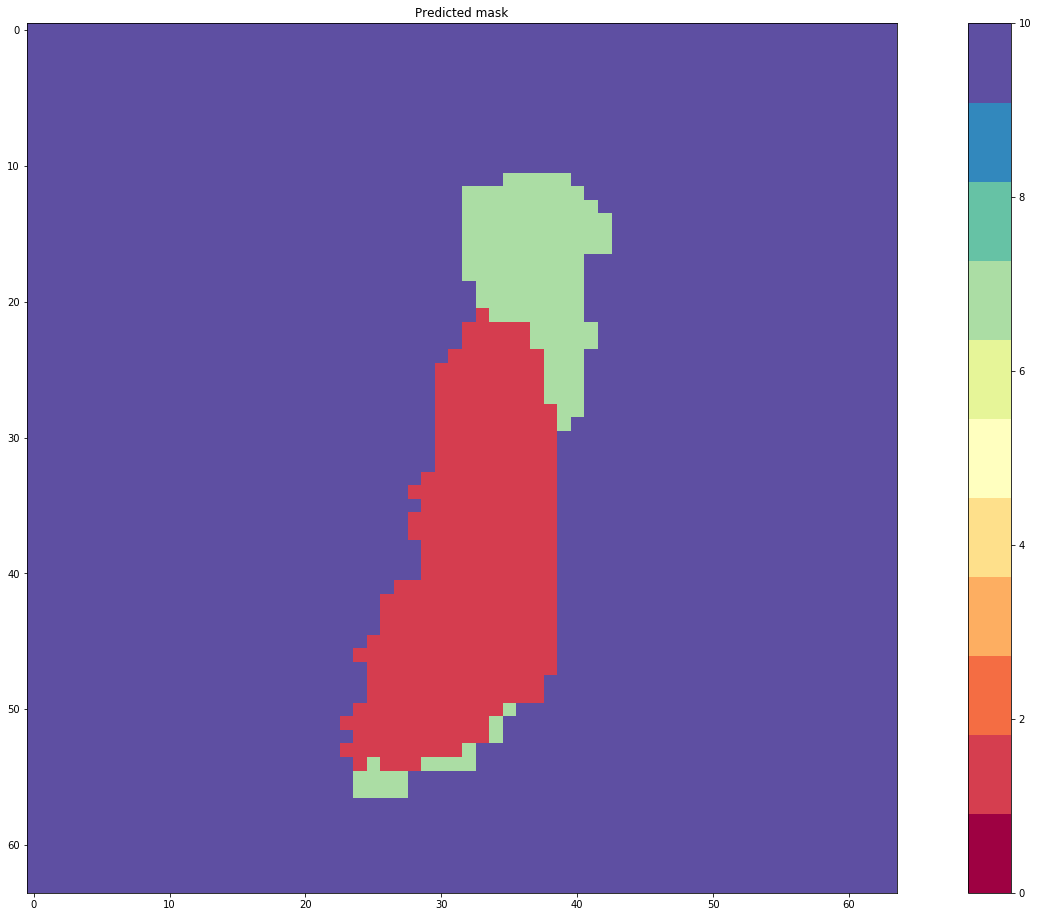

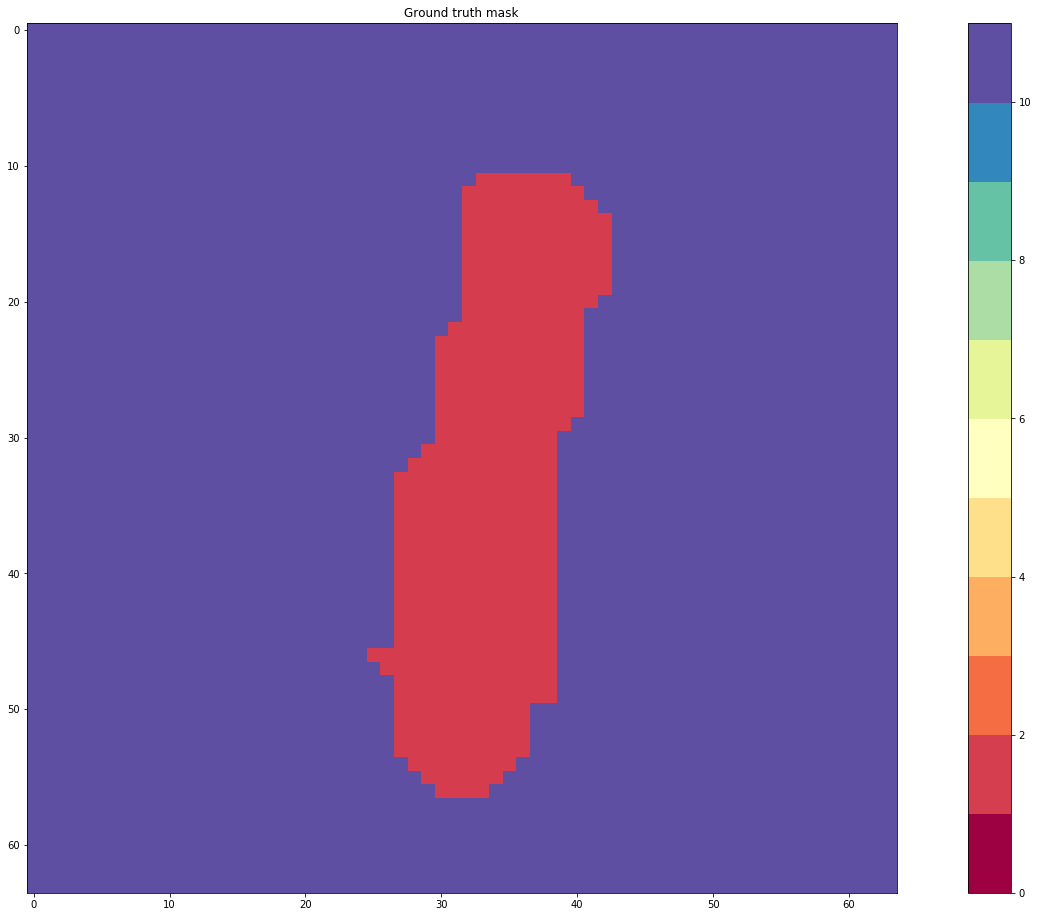

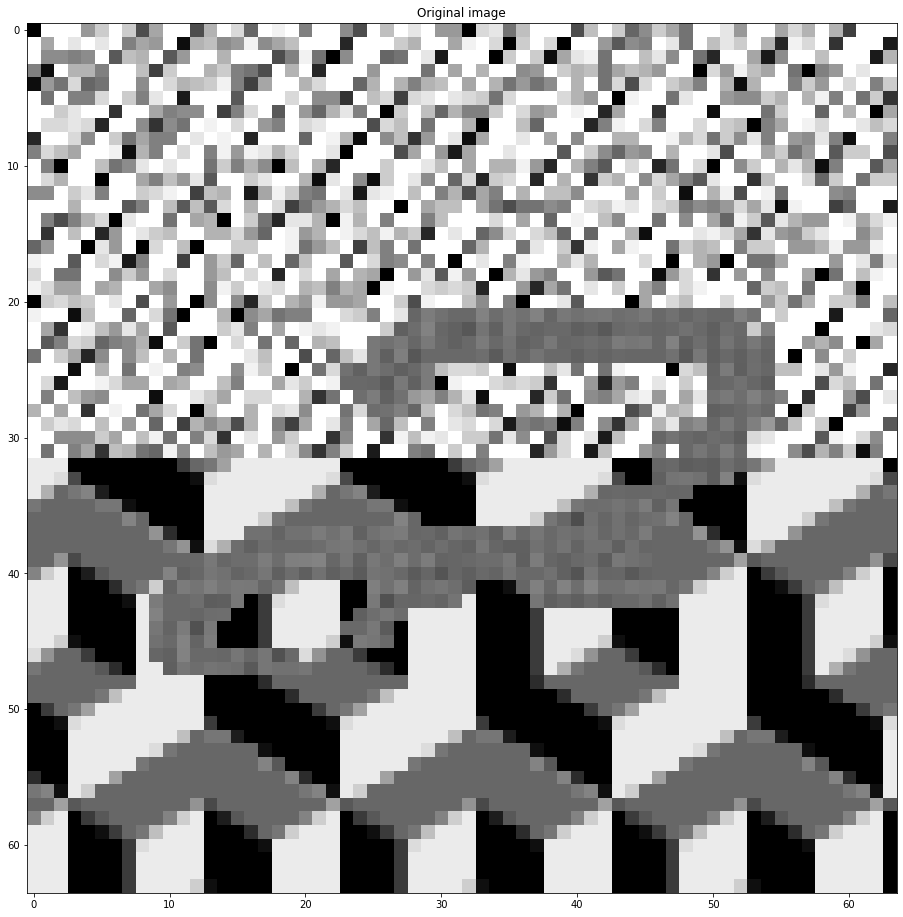

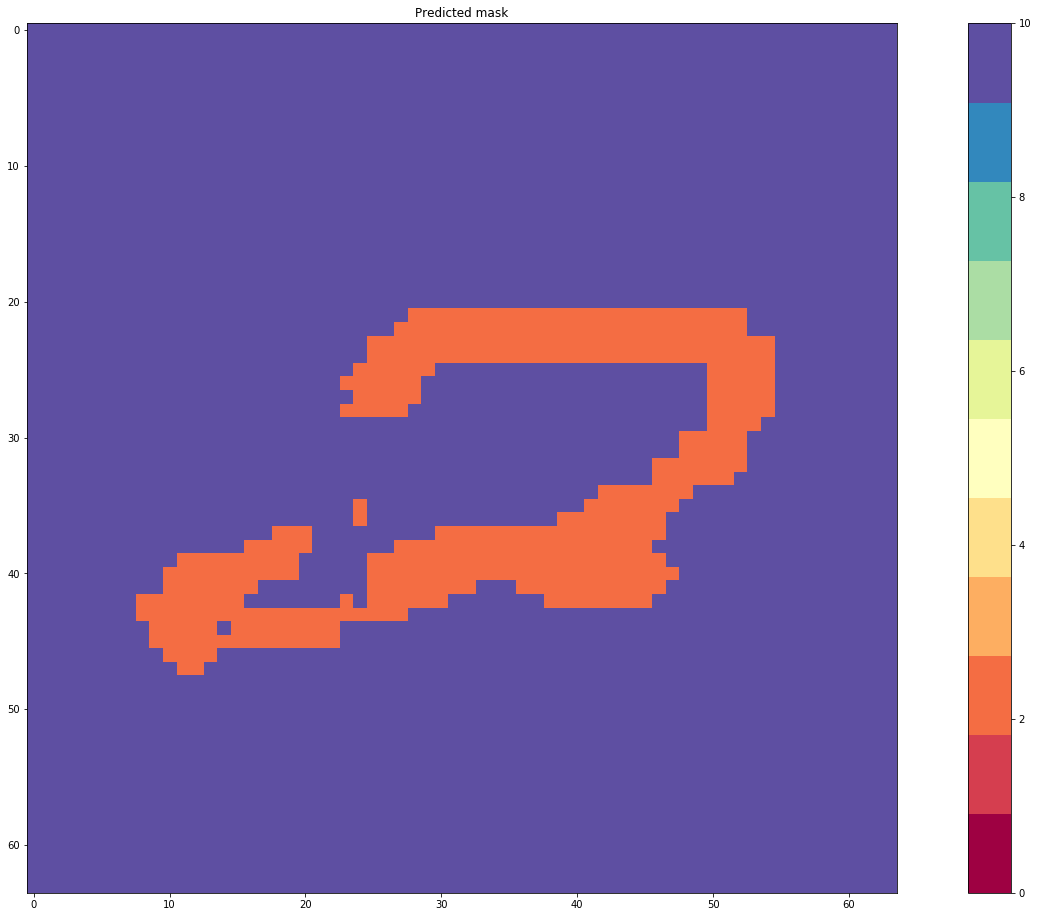

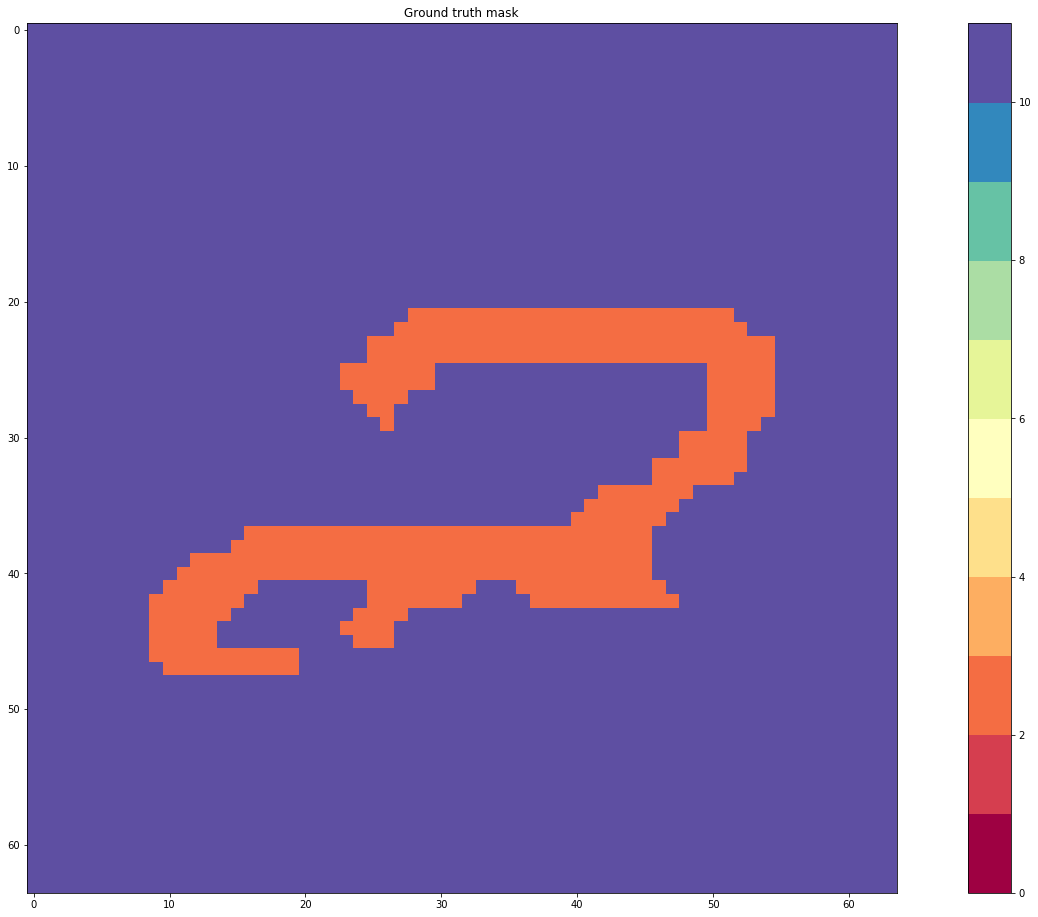

In [8]:
# save few predictions to the folder
str_folder = str(trainparam.outfolder)
biased_gen_dict = gen_texture_mnist(biased_config,'test', return_dict=True)
next_dict = next(biased_gen_dict)
# plot loss and other metrics
plot_loss(fit_out,  str_folder)
plot_metric(trainparam.metrics, fit_out, str_folder)
# plot predictions
plot_predict_and_gt(trainunet.model, next_dict[0], next_dict[1], range(13), str_folder, trainparam.n_classes)

# Option B: load saved model

In [15]:
# Your path:
Path_to_folder = "../../output/TexturedMnist/06_24_14_16_fil32_depth4_lr0.0003_scale1_batch100"

trainparam = TrainingParameters(
    dataset_name = 'TexturedMnist',
                 n_classes=11
                ,scale = 1
                ,batch_size = BATCH_SIZE
                ,last_activation = 'softmax'
                ,n_depth = 4
                ,n_filter_base = 32  # 16
                ,pool = 2
                ,lr = 3.e-4
                ,epochs = 200
                ,validation_steps = int(N_VAL/BATCH_SIZE)
                ,steps_per_epoch = int(N_TRAIN/BATCH_SIZE)
                ,loss = "categorical_crossentropy"
                #,optimizer = Adam(lr=3.e-4)
                ,metrics = ['accuracy','iou_coef','dice_coef']
                ,input_shape=(None, None, 1)
                ,n_train= N_TRAIN
                ,n_val = N_VAL
    ,outfolder = Path(Path_to_folder)
)

In [16]:
biased_test_dict = gen_texture_mnist(biased_config,'test', return_dict=True)
next_dict = next(biased_test_dict)
str_folder = str(trainparam.outfolder)
trainunet = TrainUnet(trainparam)
trainunet.csbdUnet()
trainunet.load_weights()
trainunet.compile()

## optionally plot predictions

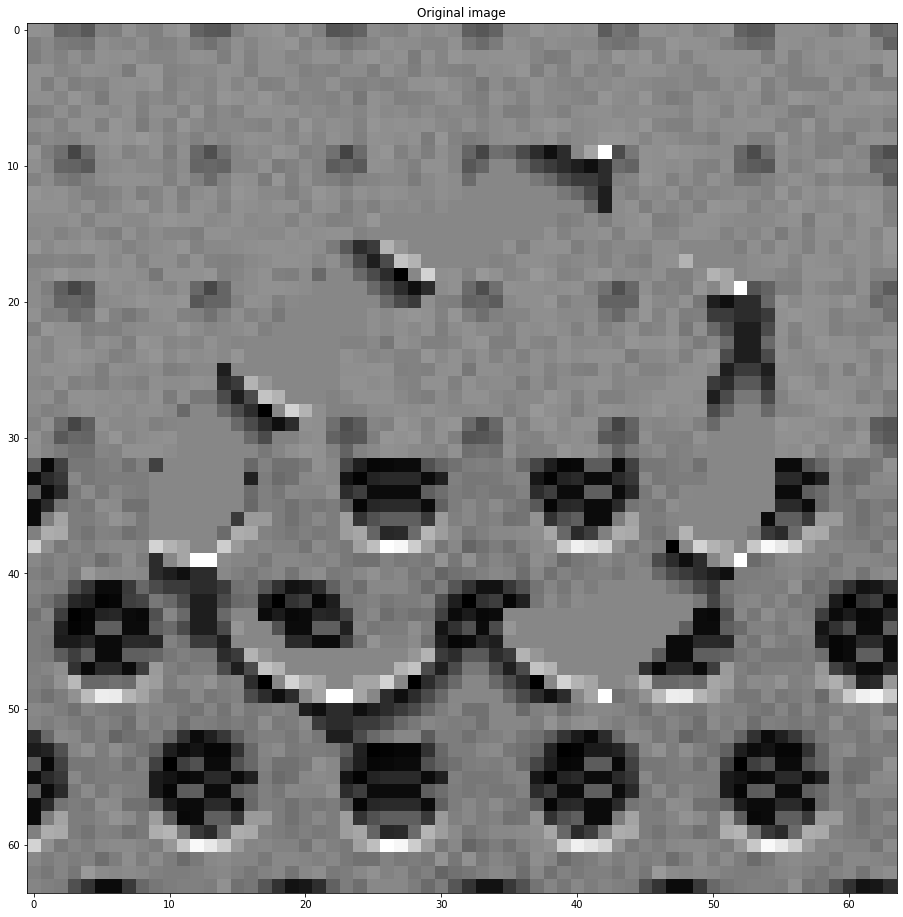

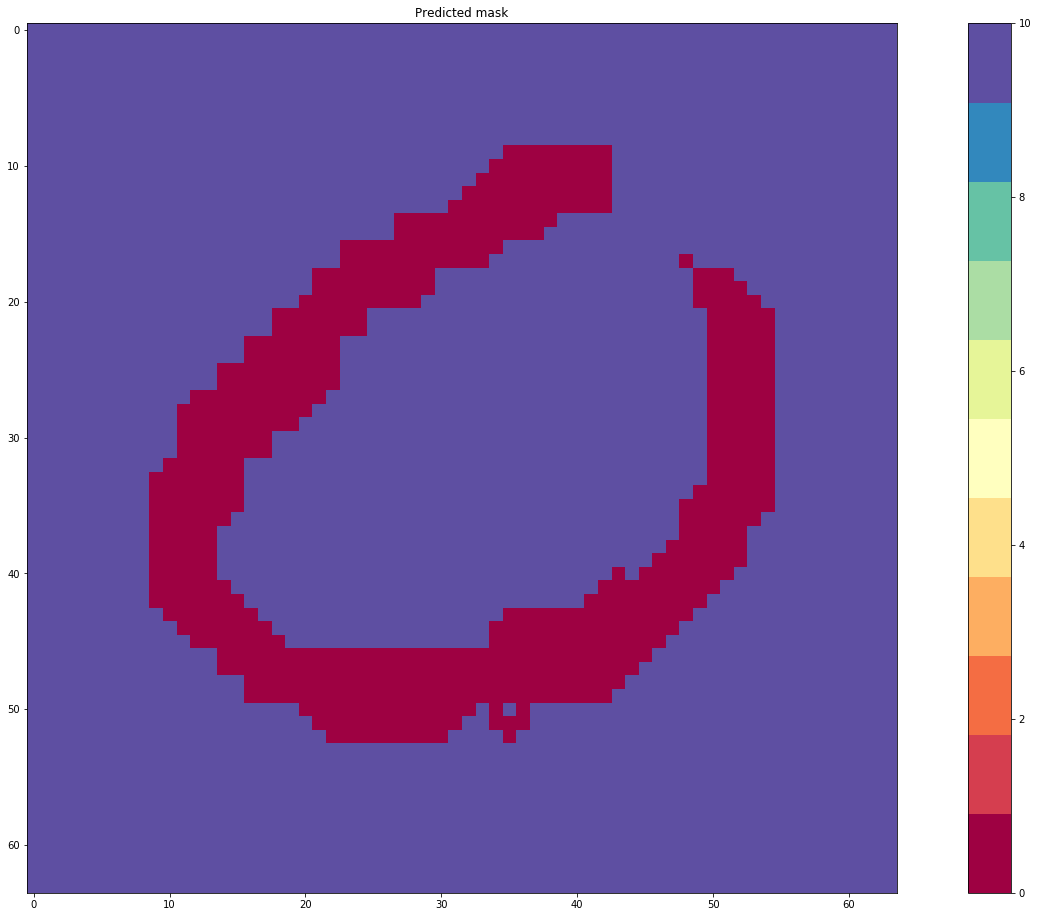

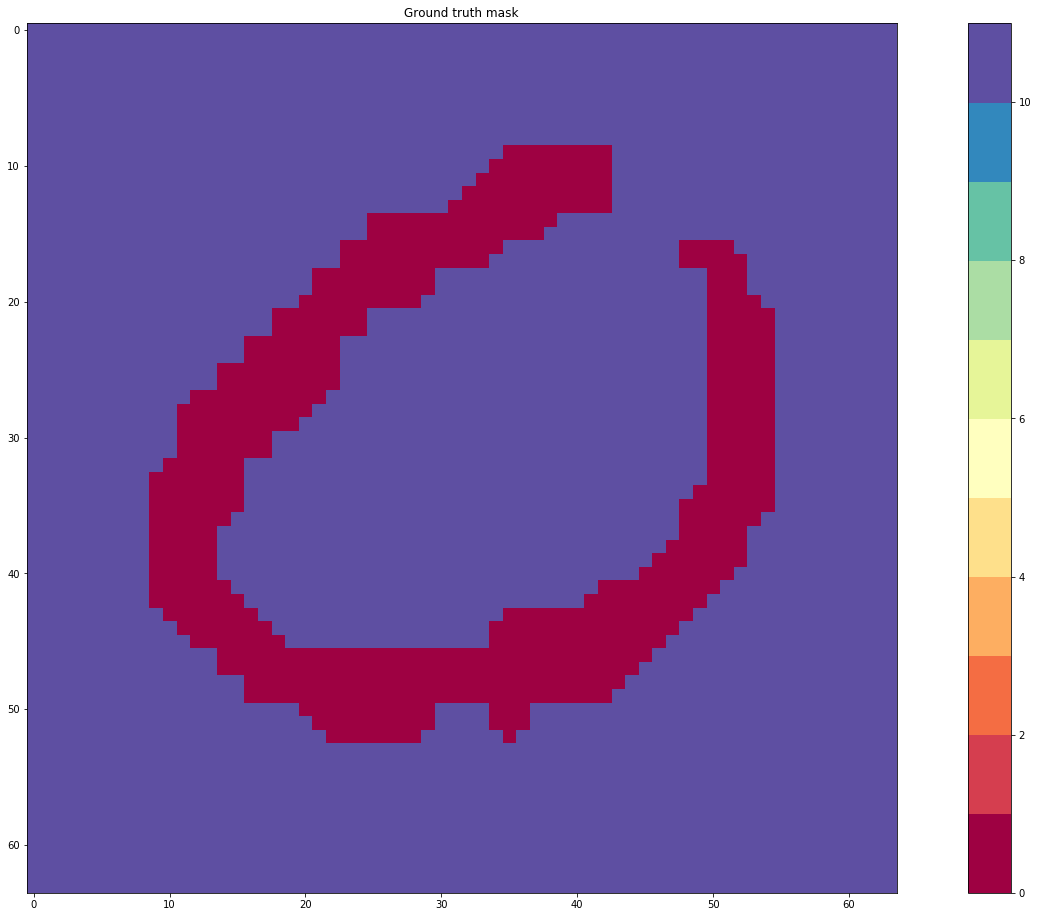

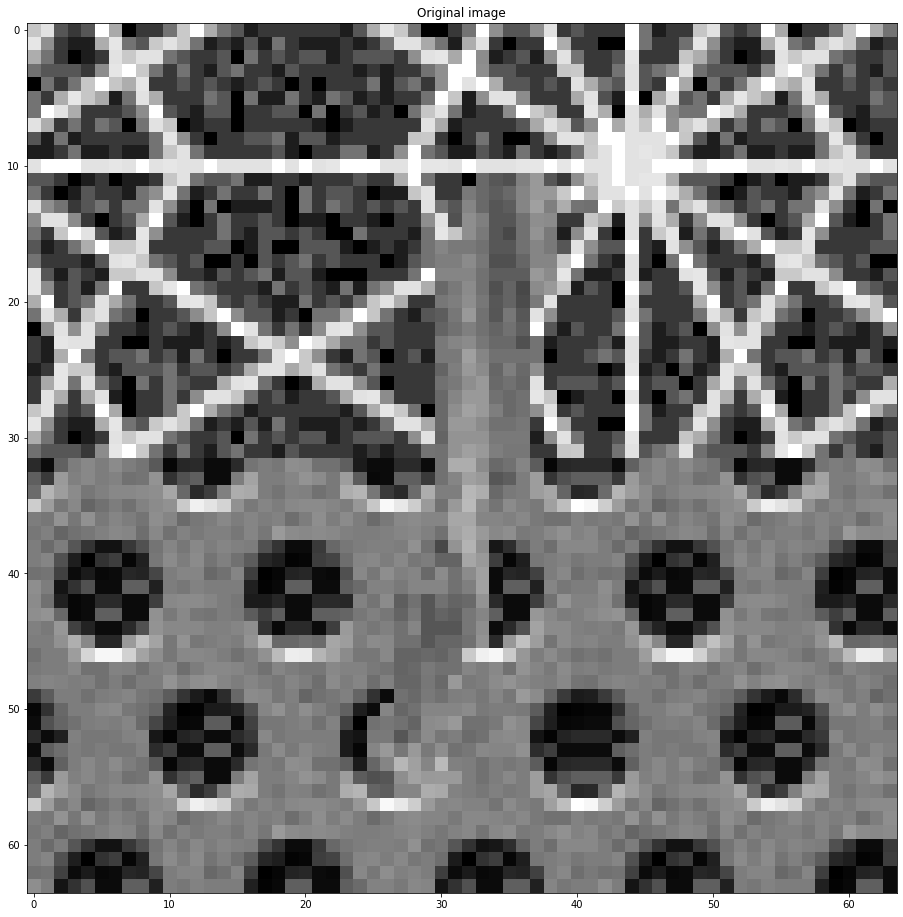

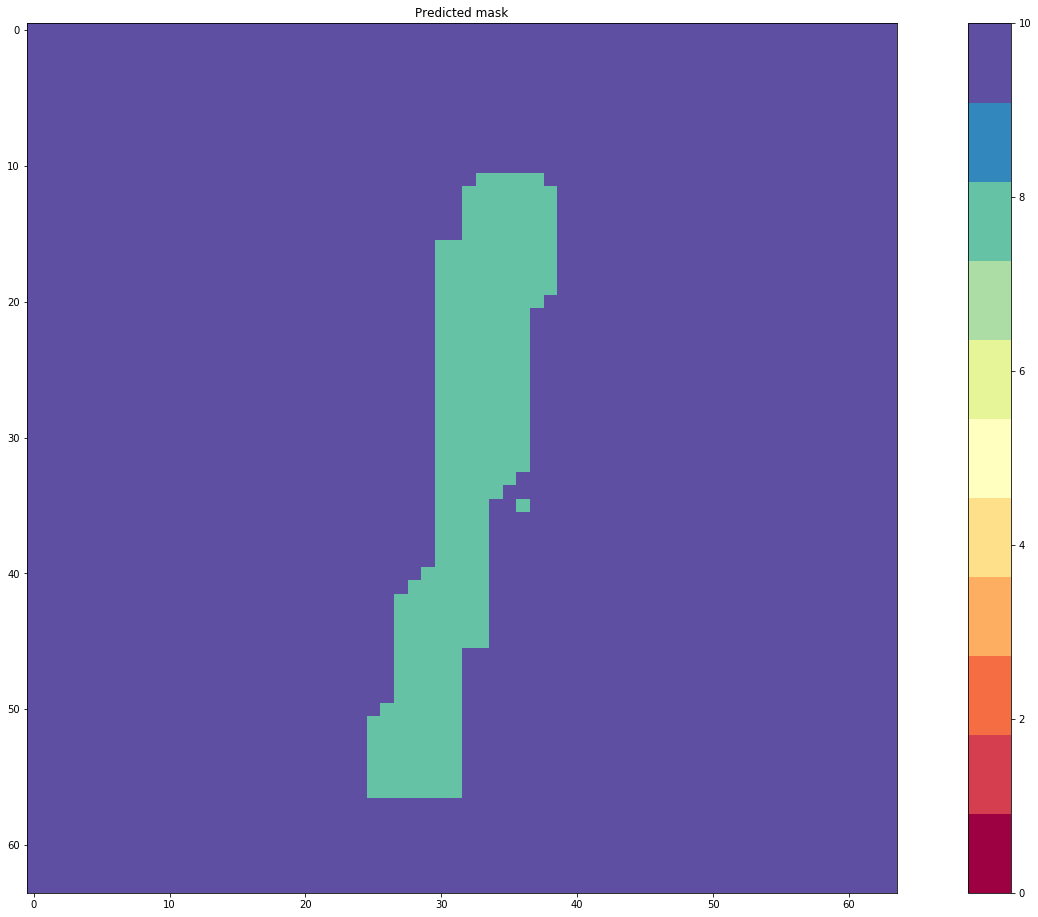

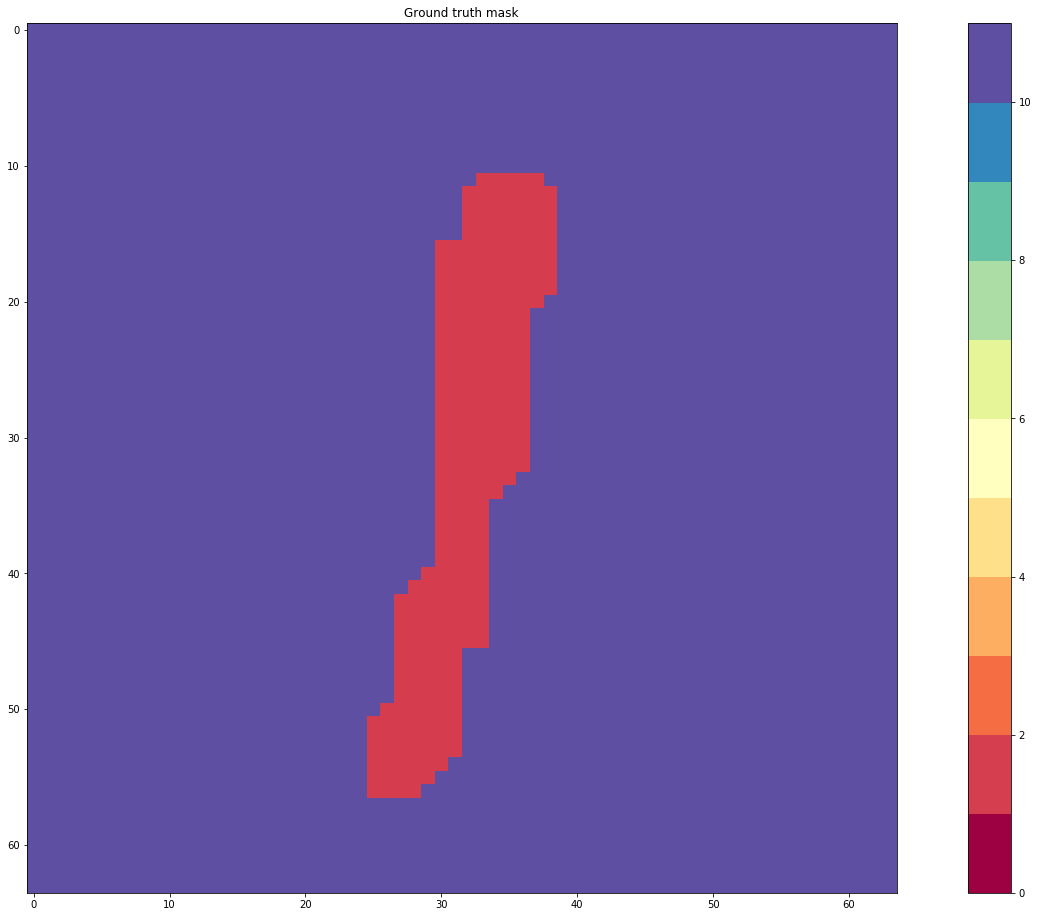

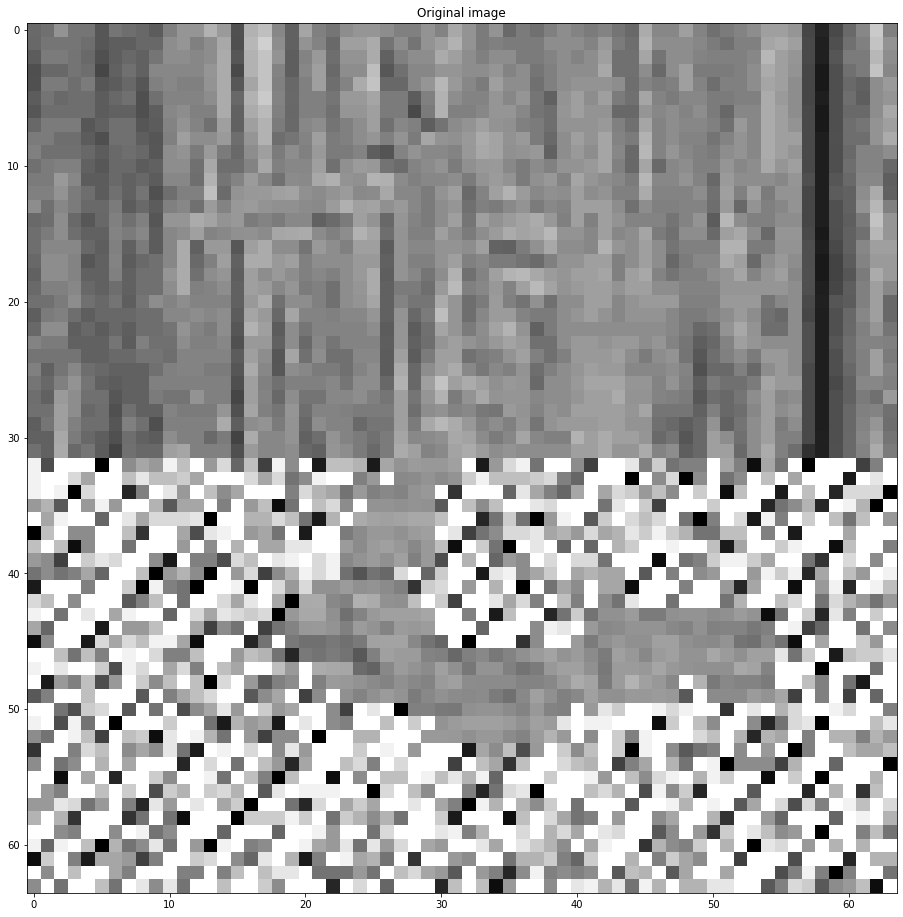

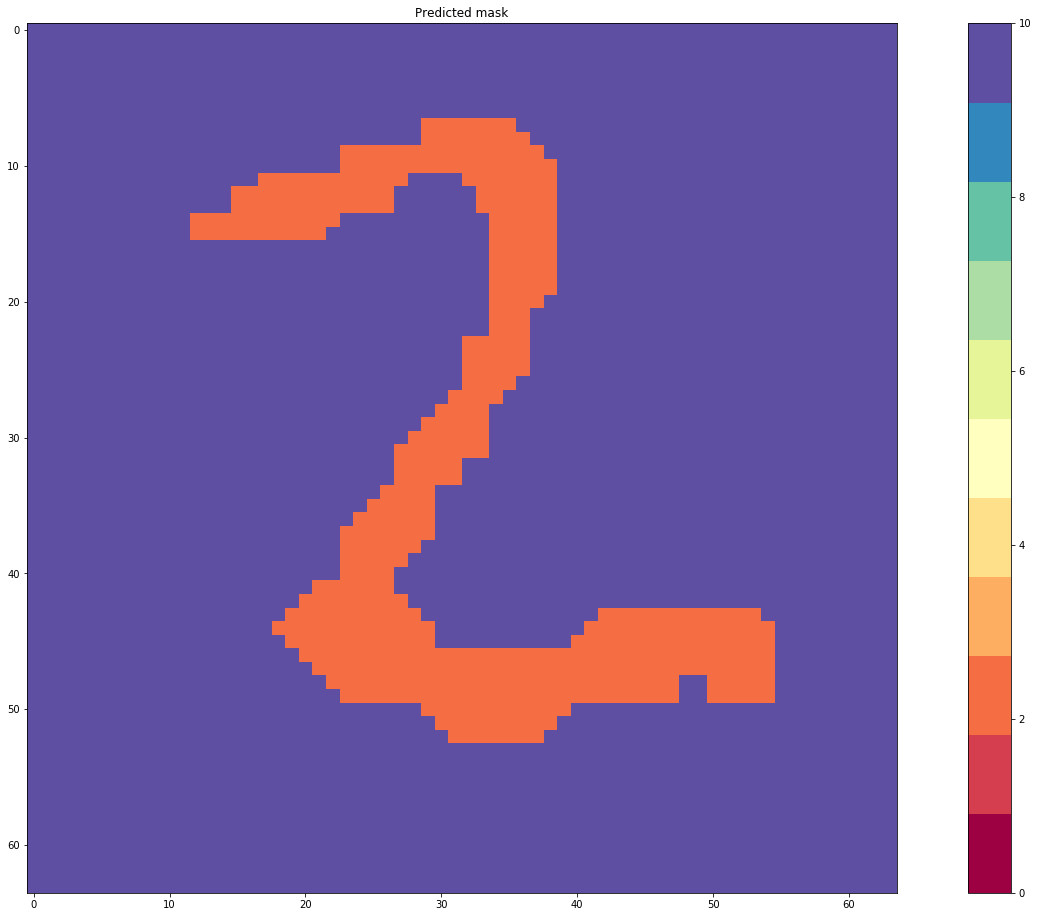

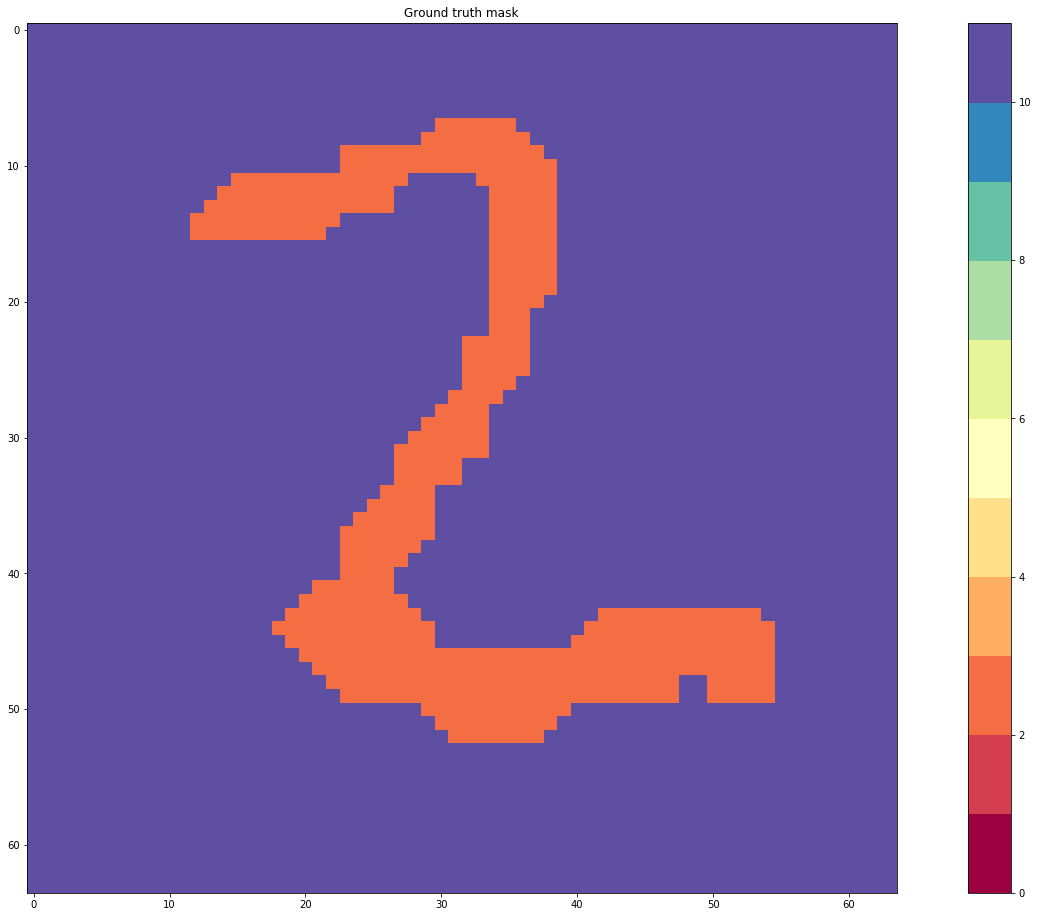

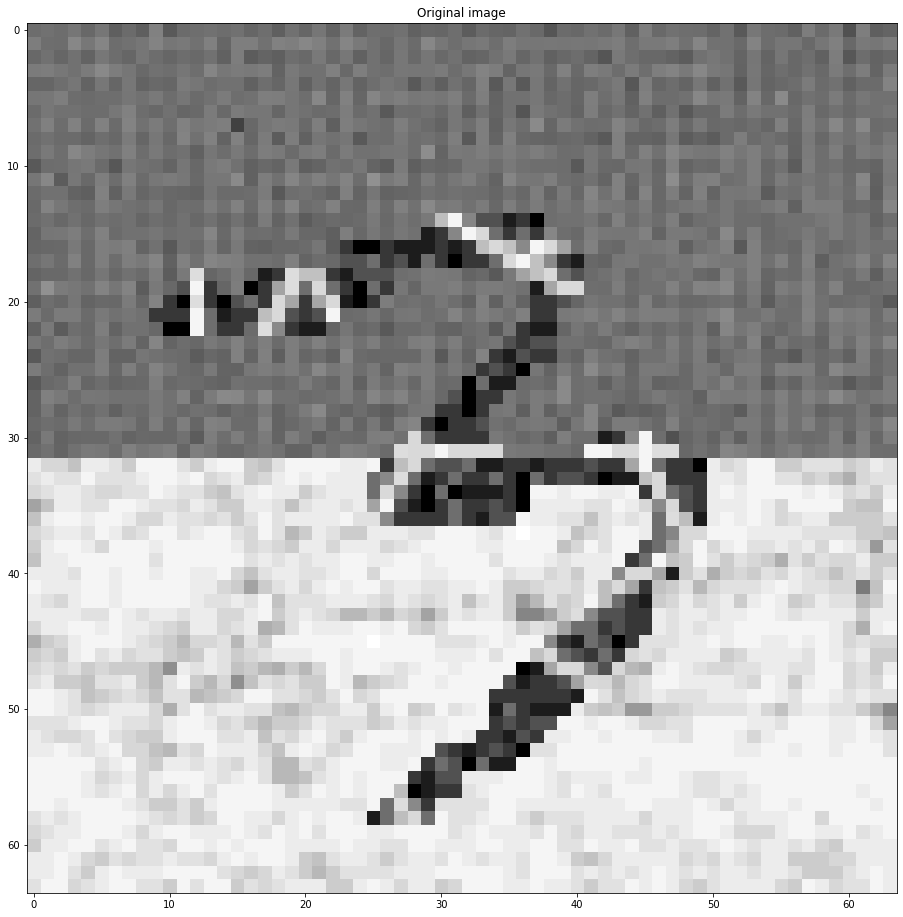

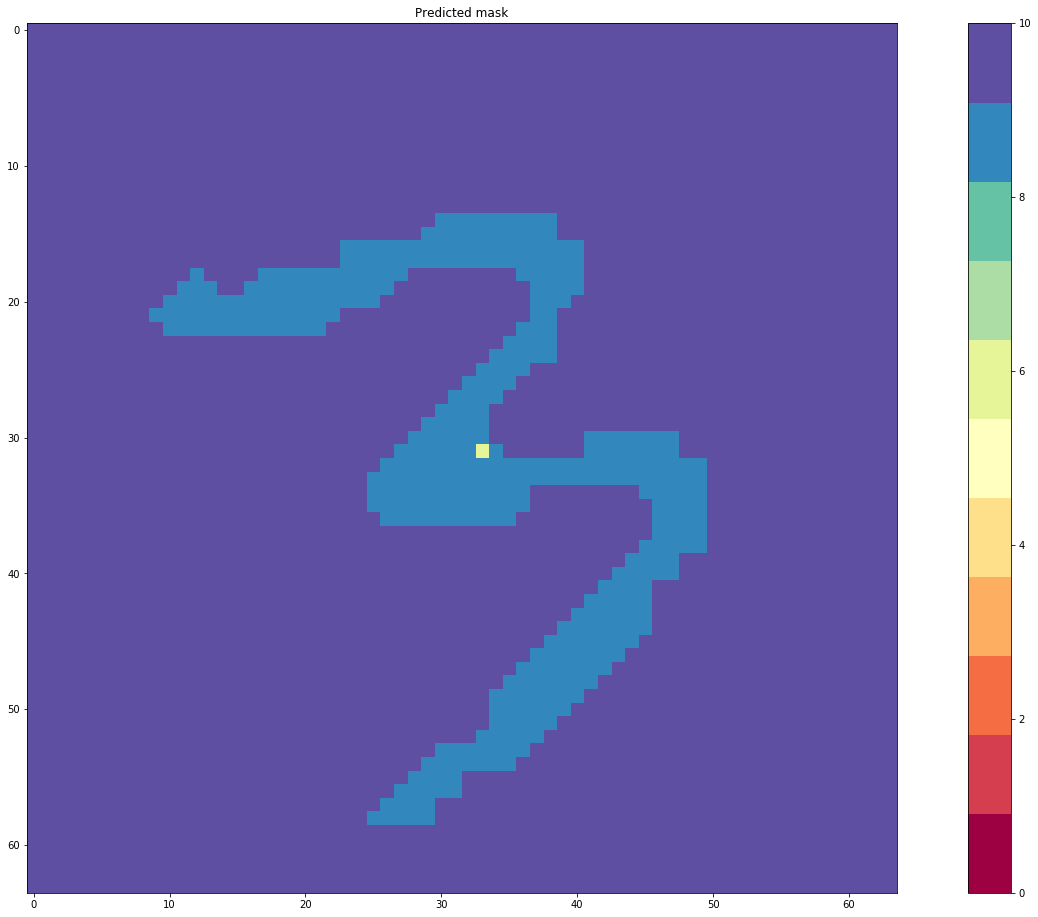

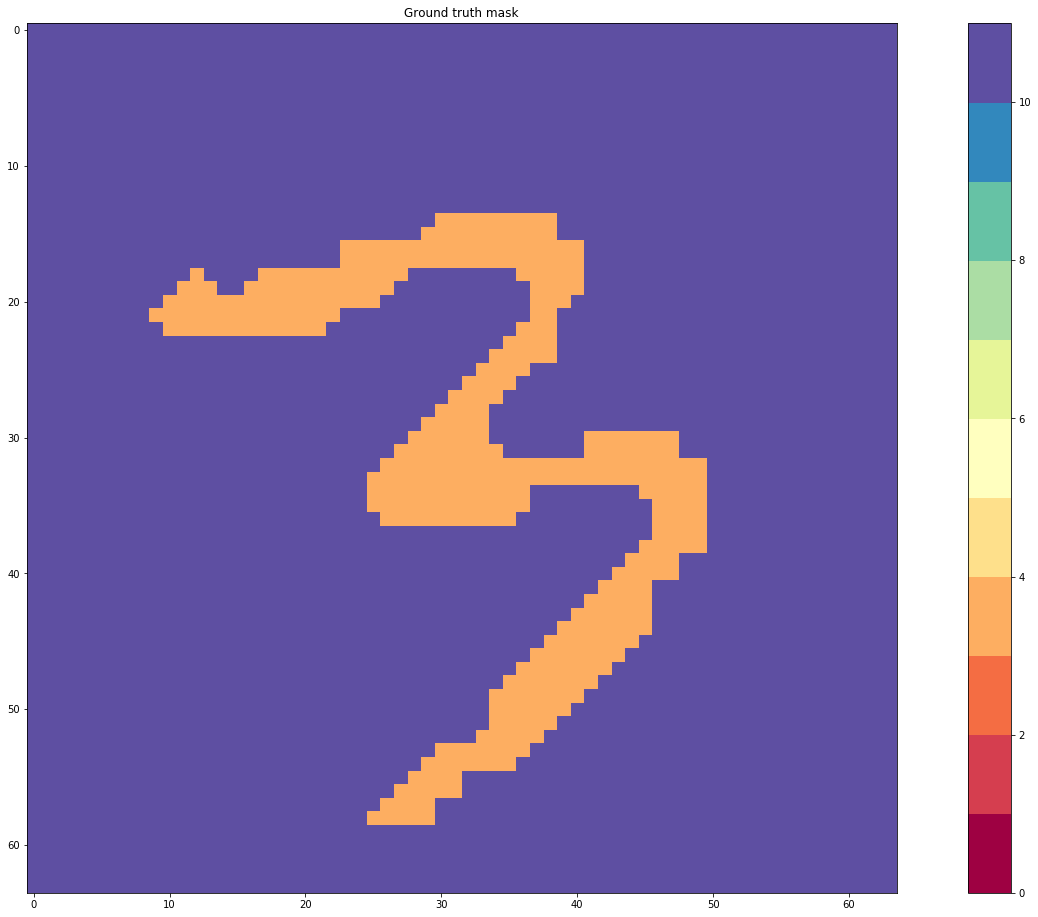

In [17]:
plot_predict_and_gt(trainunet.model, next_dict[0], next_dict[1], range(0,4), str_folder, trainparam.n_classes)


# 3. Seg-Grad-CAM

## 3.1 Set up layers for propagation of gradients

In [18]:
b_necks = trainunet.findBottleneck()
prop_from_layer = trainunet.model.layers[-1].name
prop_to_layer = b_necks[1]

activations in b-neck:  104 , 105


## 3.2 Choose an image
We chose a poorly segmented image to demonstrate what was "important" for the U-Net to segment different parts of the image.

In [19]:
cls = 2
imid = cls # id of the image in its batch
image = next_dict[0][imid]

## 3.3 A. Seg-Grad-CAM for a pixel

Shape of RoI:  (64, 64)
Lengths of i and j index lists: 498 498


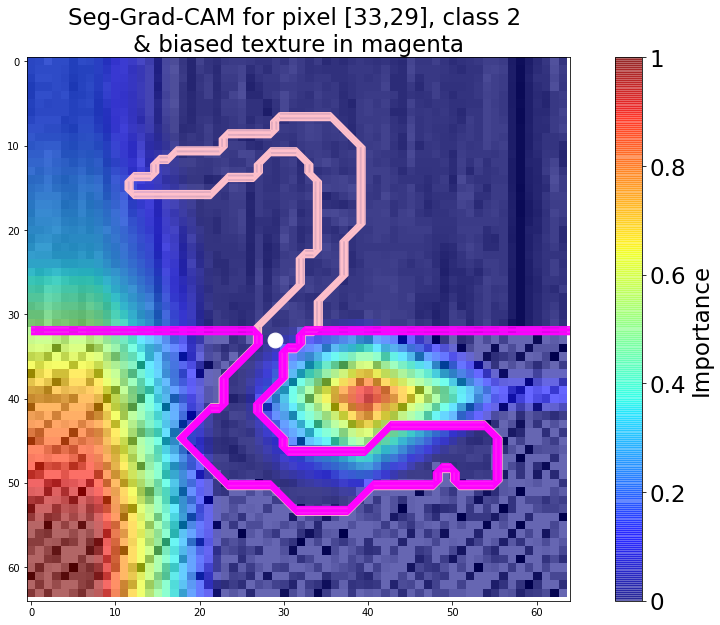

In [20]:
# create a SegGradCAM object
pixsgc = SegGradCAM(trainunet.model, image, cls,  prop_to_layer,prop_from_layer, roi=PixelRoI(33,29,image),
                 normalize=True, abs_w=False, posit_w=False)
# compute SegGradCAM
pixsgc.SGC()
# create an object with plotting functionality
plotter = SegGradCAMplot(pixsgc,trainunet,next_dict, imid)
# plot explanations on 1 picture
plotter.explainPixel()

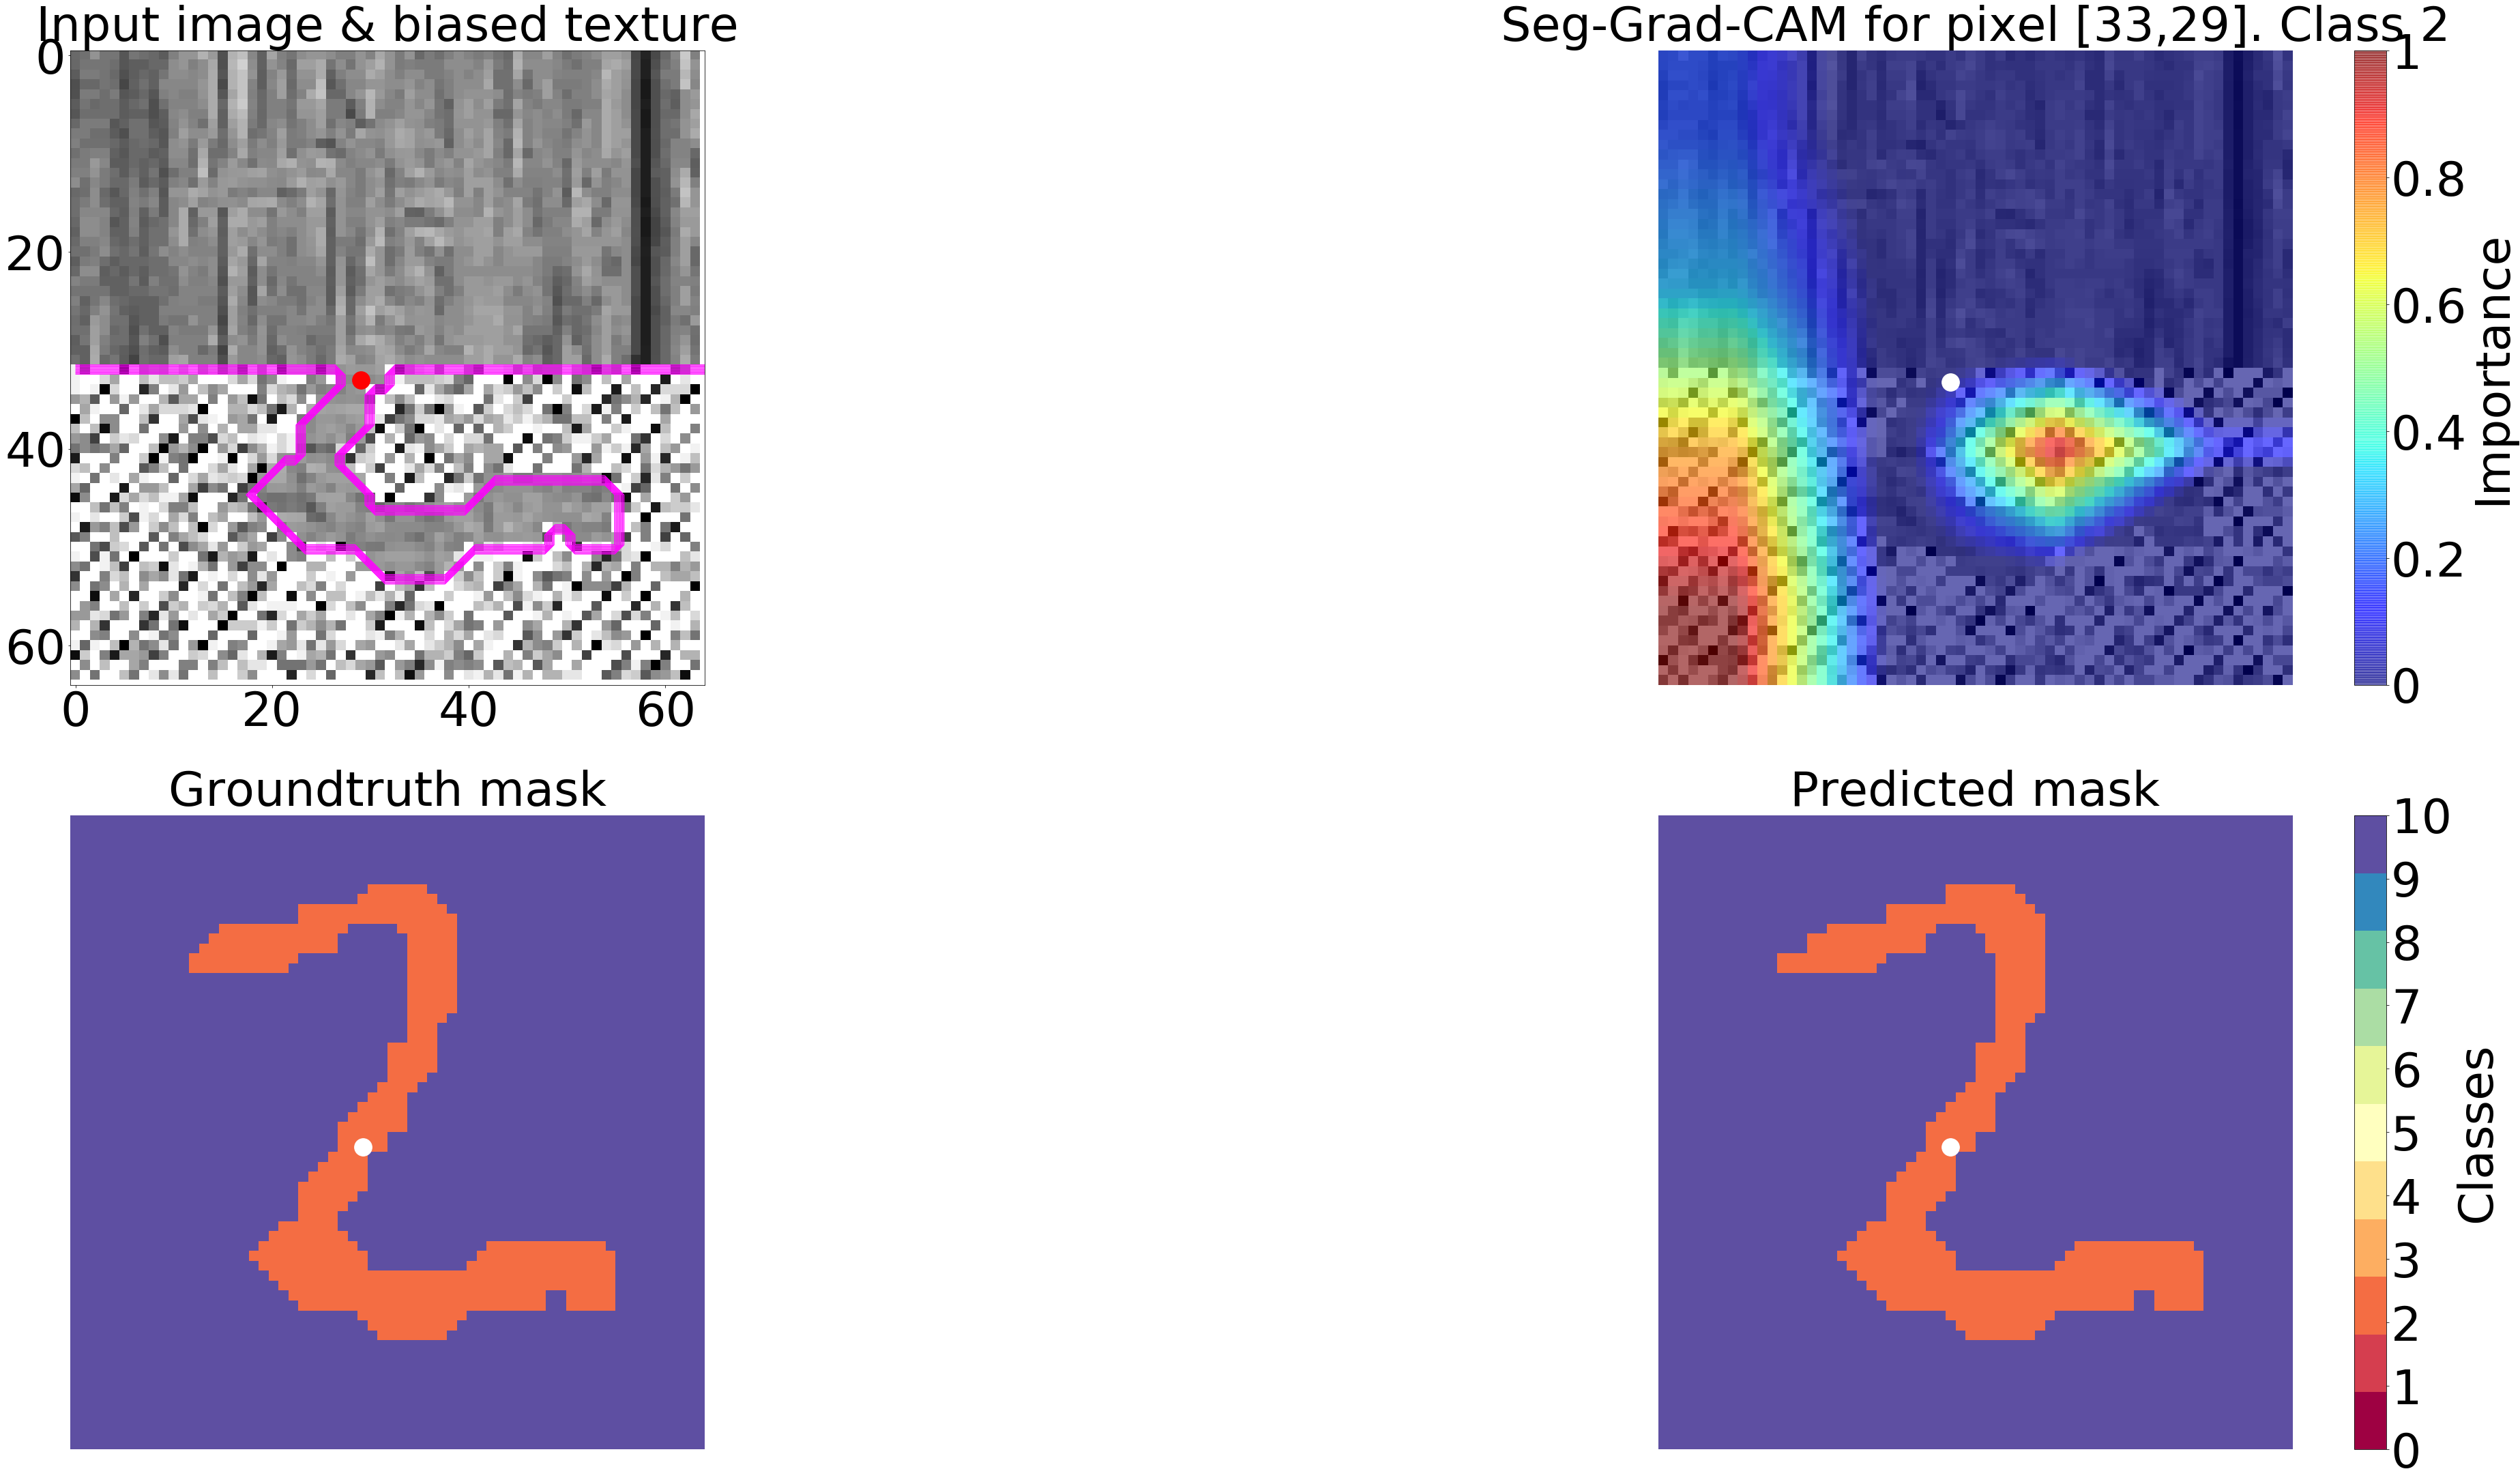

In [21]:
#Plot 4 images: original, ground truth, predicted mask, seg-grad-cam explanations for a selected single pixel
plotter.pixelGtPrediction()

## 3.3 B. Seg-Grad-CAM for the class (all pixels that were predicted as class 'cls')

Shape of RoI:  (64, 64)
Lengths of i and j index lists: 498 498


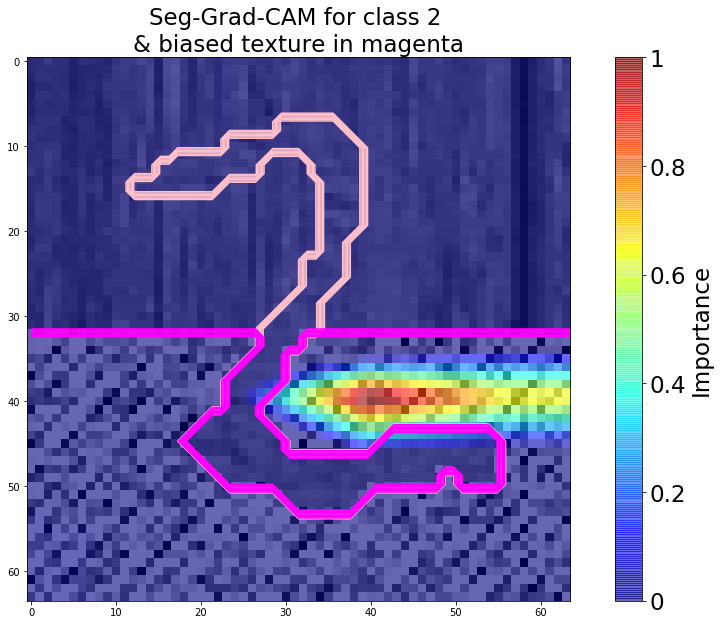

In [22]:
clsroi = ClassRoI(trainunet.model,image,cls)
clssgc = SegGradCAM(trainunet.model, image, cls,  prop_to_layer,prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc,trainunet,next_dict, imid)
clsplotter.explainClass()

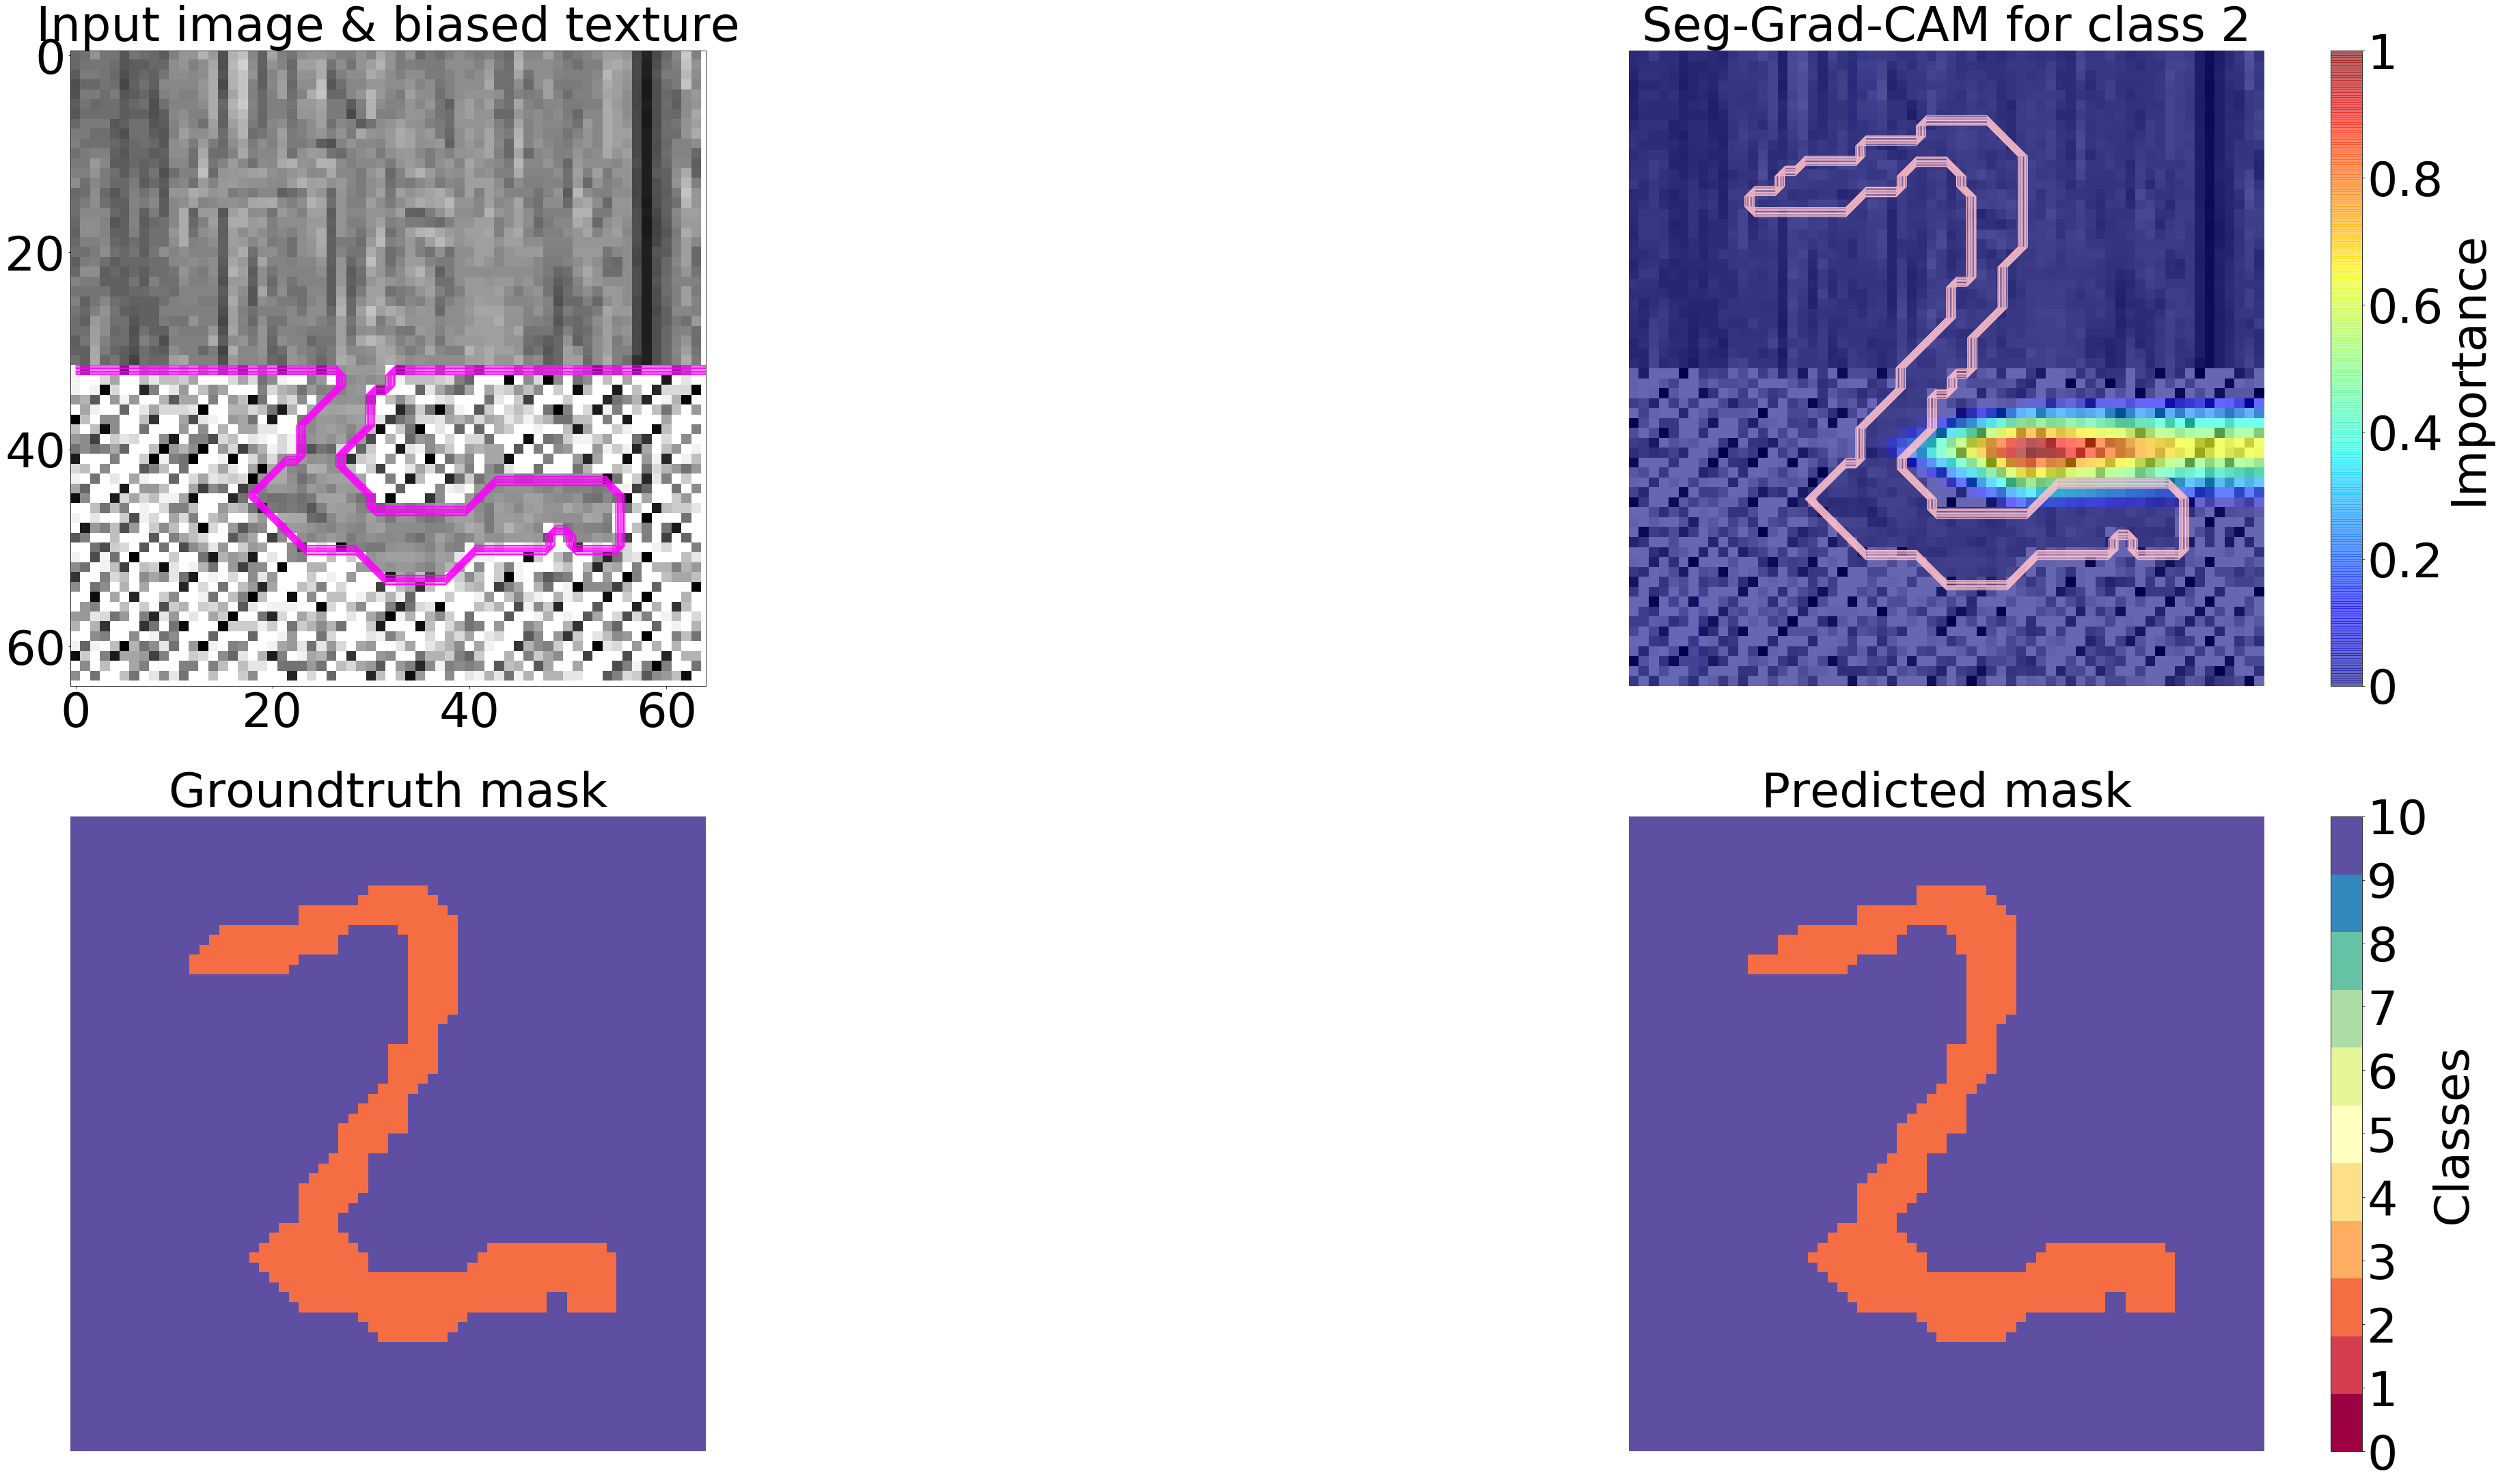

In [23]:
clsplotter.classGtPrediction()

## 3.3 C. Seg-Grad-CAM for a region of interest
### 3.3.C.1 for the largest set of connected pixels predicted as 'cls'

Shape of RoI:  (64, 64)
Lengths of i and j index lists: 498 498
connectedComponents values, counts:  [0 1] [3598  498]
argmax:  1
Shape of RoI:  (64, 64)
Lengths of i and j index lists: 498 498


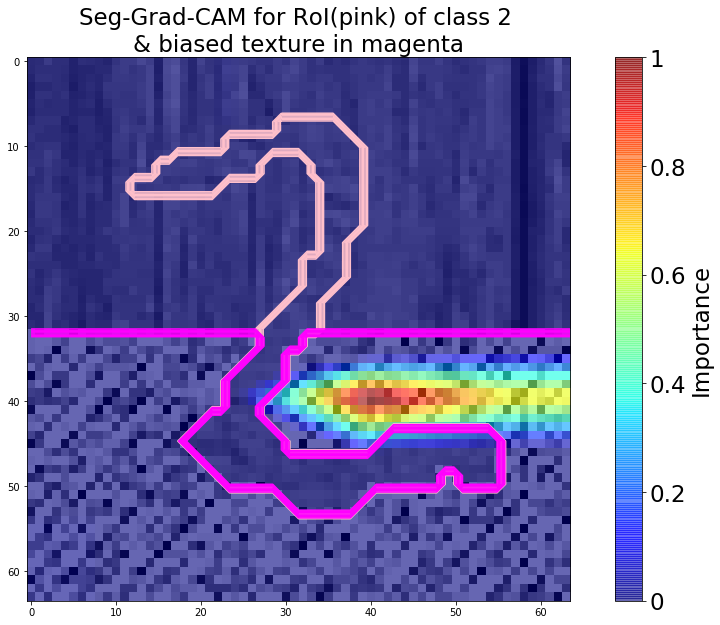

In [24]:
largeroi = ClassRoI(trainunet.model,image,cls)
# find the largest connected component of pixels predicted as 'cls'
largeroi.largestComponent()

largesgc = SegGradCAM(trainunet.model, image, cls,  prop_to_layer,prop_from_layer, roi=largeroi,
                 normalize=True, abs_w=False, posit_w=False)
largesgc.SGC()
roiplotter = SegGradCAMplot(largesgc,trainunet,next_dict, imid)
roiplotter.explainRoi()

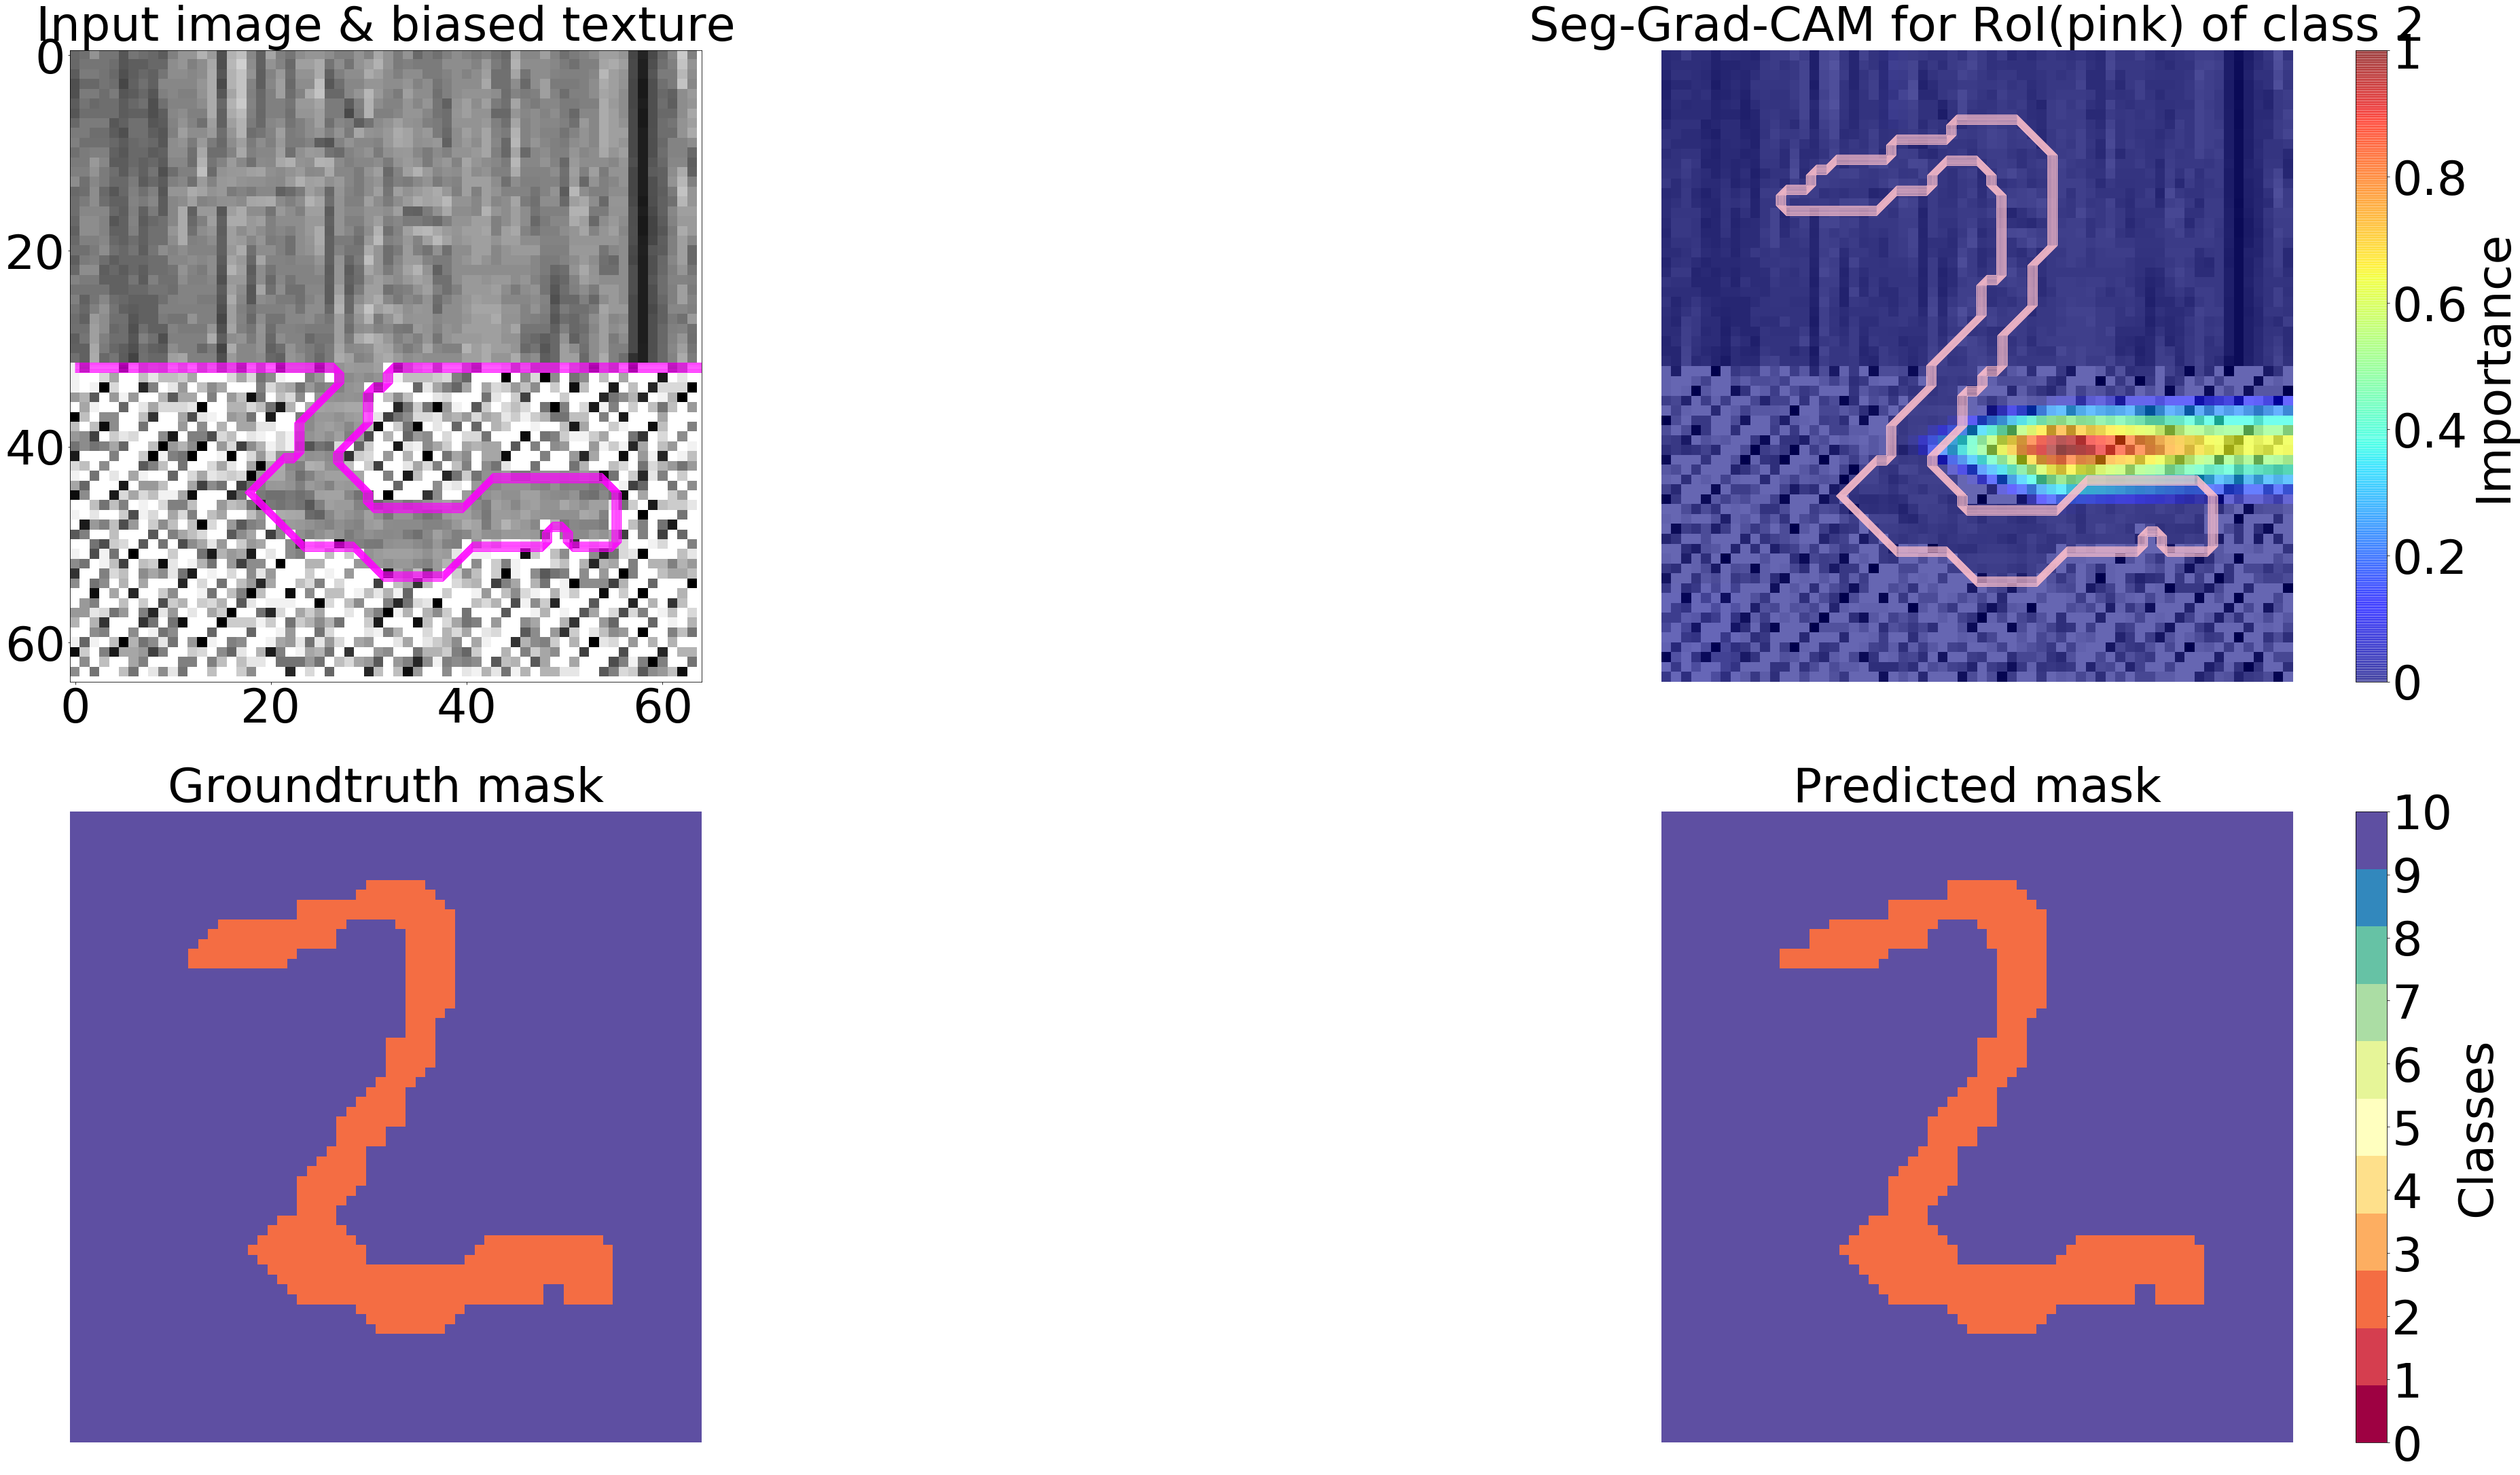

In [25]:
roiplotter.roiGtPrediction()

### 3.3.C.2 for the smallest set of connected pixels predicted as 'cls'

Shape of RoI:  (64, 64)
Lengths of i and j index lists: 498 498
connectedComponents values, counts:  [0 1] [3598  498]
argmin:  1
Shape of RoI:  (64, 64)
Lengths of i and j index lists: 498 498


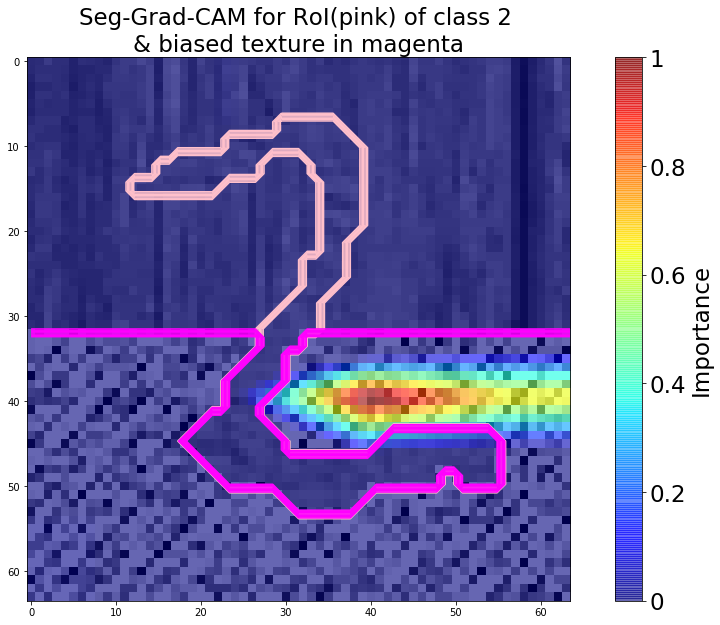

In [26]:
smallroi = ClassRoI(trainunet.model,image,cls)
# Now, for the smallest component
smallroi.smallestComponent()

smallsgc = SegGradCAM(trainunet.model, image, cls,  prop_to_layer,prop_from_layer, roi=smallroi,
                 normalize=True, abs_w=False, posit_w=False)
smallsgc.SGC()
smallroiplotter = SegGradCAMplot(smallsgc,trainunet,next_dict, imid)
smallroiplotter.explainRoi()

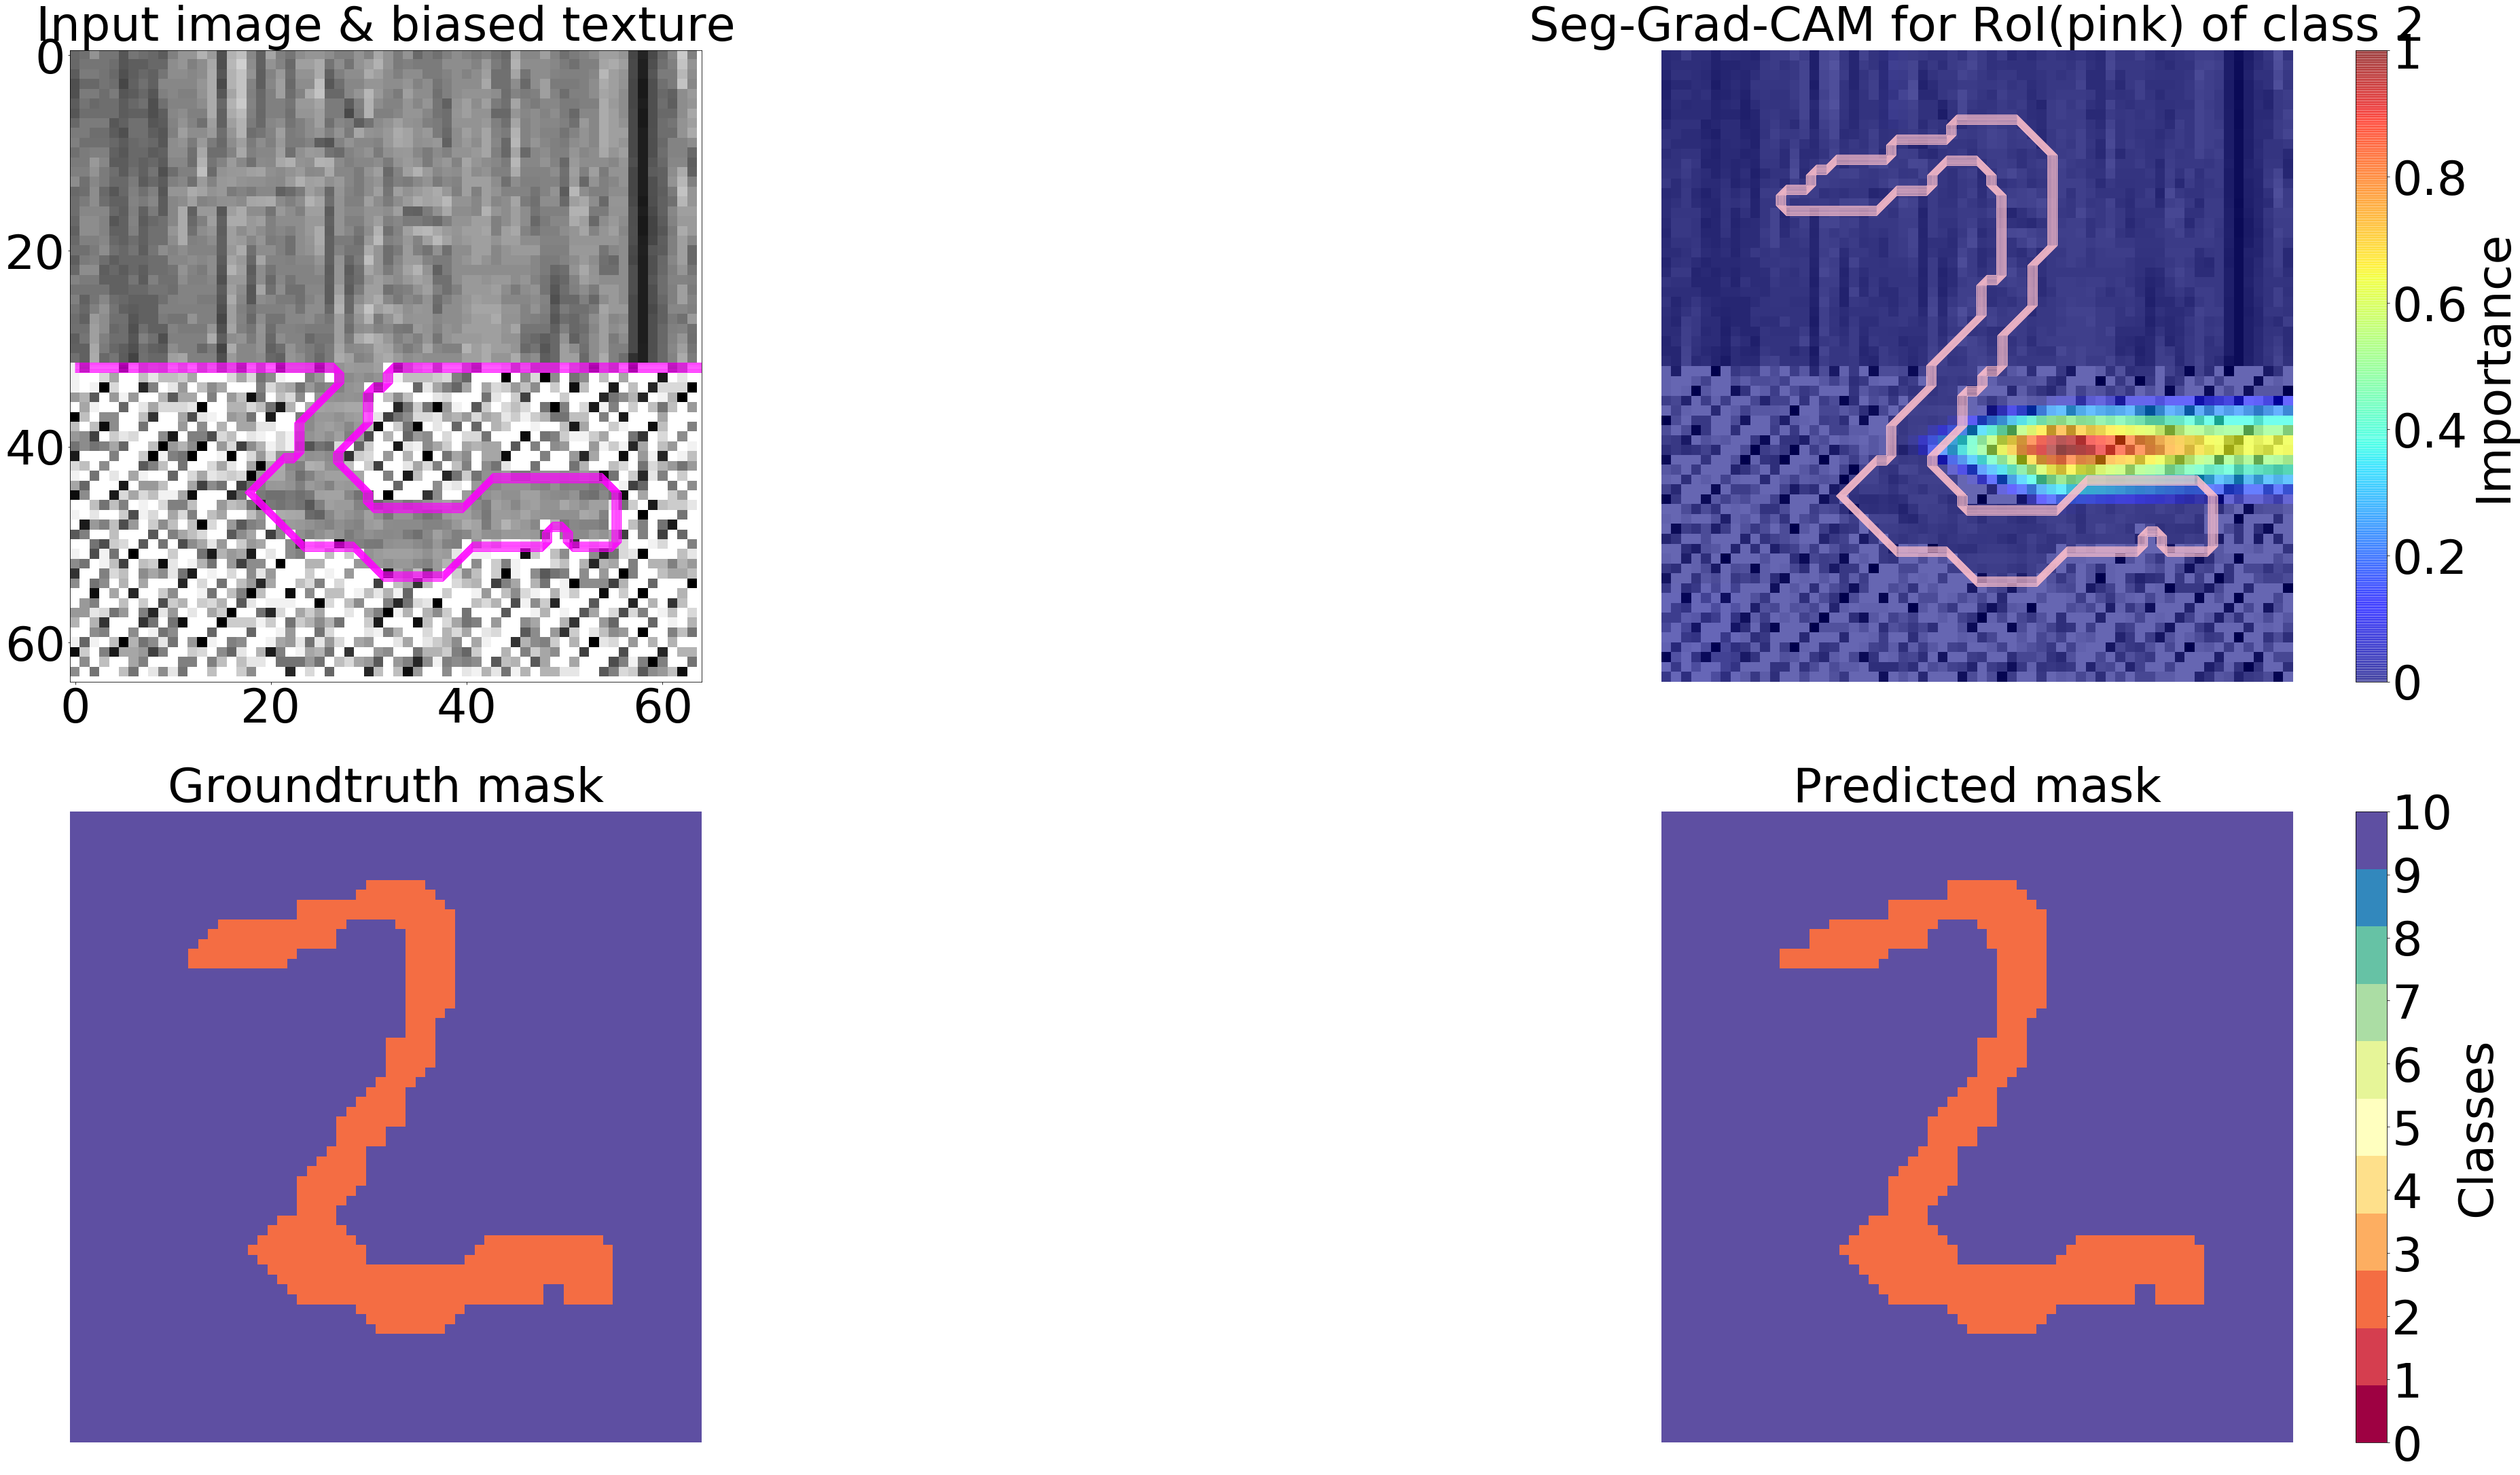

In [27]:
smallroiplotter.roiGtPrediction()